# Classifying Confusion with RNN

This notebook holds our confusion classification pipeline for various RNN architectures. Experiments occur with no data augmentation and are thus called BASELINE conditions.


In [1]:
import pickle
import os
import random
import shutil

import numpy as np

import torch
from torch import nn
from torch import utils
from torch import autograd
from torchvision import datasets

from utils import pickle_loader
from utils import plot_metrics

from train import train

MANUAL_SEED = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


MAX_SEQUENCE_LENGTH = 150 # 5 seconds
INPUT_SIZE = 14
HIDDEN_SIZE = 256
OUTPUT_SIZE = 2
BATCH_SIZE = 256

## RNN model classes

In [2]:
class ConfusionRNN(nn.Module):
    """
        Basic/Vanilla RNN.
    """
    def __init__(self, input_size, hidden_size, output_size, batch_size, num_layers=1):
        super(ConfusionRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(1)

    def forward(self, inputs, hidden):
        # change input shape to (max_seq_size,batch_size,input_features):
        inputs = inputs.permute(1, 0, 2)
        output, hidden = self.rnn(inputs, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self, batch_size):
        """ Initializes the hidden state with zero tensors.
        """
        return autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                             self.hidden_size, device=DEVICE))

In [3]:
class ConfusionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size, num_layers=1):
        super(ConfusionLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(1)


    def forward(self, inputs, hidden):
        # change input shape to (max_seq_size,batch_size,input_features):
        inputs = inputs.permute(1, 0, 2)
        output, hidden = self.lstm(inputs, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self, batch_size):
        """ Initializes the hidden state and cell state with zero tensors.
        """
        return (autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                              self.hidden_size, device=DEVICE)),
                autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                              self.hidden_size, device=DEVICE)))

In [4]:
class ConfusionGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size, num_layers=1):
        super(ConfusionGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(1)


    def forward(self, inputs, hidden):
        # change input shape to (max_seq_size,batch_size,input_features):
        inputs = inputs.permute(1, 0, 2)
        output, hidden = self.gru(inputs, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self, batch_size):
        """ Initializes the hidden state with zero tensors.
        """
        return autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                             self.hidden_size, device=DEVICE))


## Cross Validation

### The following cell implements 10-fold CV.

In [8]:
def cross_validate(model_type,
                   folds,
                   epochs,
                   criterion_type,
                   optimizer_type,
                   confused_path,
                   not_confused_path,
                   print_every,
                   plot_every,
                   hidden_size,
                   num_layers,
                   early_stopping=False,
                   early_stopping_patience=10,
                   rate_decay=False,
                   rate_decay_patience=5,
                   initial_learning_rate=0.001,
                   verbose=False):
    """
        Perform Cross Validation on the model with k-folds.

        Args:
            model_type (string): the type of RNN to use. Must be 'lstm' or 'gru'
            folds: value of k for k-fold CV
            epochs (int): the max number of epochs to train the model for each fold
            criterion_type (string): the name loss function to use for training.
            optimizer_type (string): the name of learning algorithm to use for training.
            confused_path (string): the path to the folder containing the
                confused data samples
            not_confused_path (string): the path to the folder containing the
                not_confused data samples
            print_every (int): the number of batches to train for before
                printing relevant stats
            plot_every (int): the number of batches to train for before
                recording relevant stats, which will be plotted after each fold
            hidden_size (int):
            num_layers (int):
            early_stopping (boolean): if True, training will stop after
                early_stopping_patience epochs without improvement
            early_stopping_patience (int): number of epochs without improvement
                that can pass before training is stopped
            rate_decay (boolean): if True, learning rate will decrease by half
                each rate_decay_patience epochs without improvement
            rate_decay_patience (int): number of epochs without improvement
                before reducing learning rate
            initial_learning_rate (float): the first and highest rate used
            verbose (boolean): if True, function will print additional stats

        Returns: (list,list,list)
            cv_val_accs (list): validation accuracy for each fold
            cv_val_sensis (list): validation sensitivity for each fold
            cv_val_specifs (list): validation specificity for each fold

    """

    confused_file_names = os.listdir(confused_path)
    not_confused_file_names = os.listdir(not_confused_path)
    if '.DS_Store' in confused_file_names:
        confused_file_names.remove('.DS_Store')
    if '.DS_Store' in not_confused_file_names:
        not_confused_file_names.remove('.DS_Store')

    infile = open('grouped_10_fold_split_list_2.pickle', 'rb')
    split = pickle.load(infile)
    infile.close()

    train_confused_splits = split[0]
    val_confused_splits = split[1]
    train_not_confused_splits = split[2]
    val_not_confused_splits = split[3]


    cv_val_accs = []
    cv_val_sensis = []
    cv_val_specifs = []

    cv_val_aucs = []

    for k in range(folds):
        print("\nFold ", k+1)

        # Get data item file names for this fold and downsample not_confused to balance training set
        train_confused = train_confused_splits[k]
        val_confused = val_confused_splits[k]
        train_not_confused = random.sample(train_not_confused_splits[k], k=(len(train_confused)))
        #train_not_confused = train_not_confused_splits[k]

        print("confused items in training set: ", len(train_confused))
        print("not_confused items in training set: ", len(train_not_confused))



        val_not_confused = val_not_confused_splits[k]

        print("confused items in validation set: ", len(val_confused))
        print("not_confused items in validation set: ", len(val_not_confused))

        if verbose:
            #print("\nTraining confused items:\n")
            #print(train_confused)
            #print("\nTraining not_confused items:\n")
            #print(train_not_confused)
            print("\nValidation confused items:\n")
            print(val_confused)
            #print("\nValidation not_confused items:\n")
            #print(val_not_confused)
            print()


        local_train_confused_path = './dataset/augmented/train/confused/'
        local_val_confused_path = './dataset/augmented/val/confused/'
        local_train_not_confused_path = './dataset/augmented/train/not_confused/'
        local_val_not_confused_path = './dataset/augmented/val/not_confused/'

        # Remove any old directories
        if os.path.exists(local_train_confused_path):
            shutil.rmtree(local_train_confused_path)
        if os.path.exists(local_val_confused_path):
            shutil.rmtree(local_val_confused_path)
        if os.path.exists(local_train_not_confused_path):
            shutil.rmtree(local_train_not_confused_path)
        if os.path.exists(local_val_not_confused_path):
            shutil.rmtree(local_val_not_confused_path)

        # Make new temp directories
        os.makedirs(local_train_confused_path)
        for i in train_confused:
            shutil.copy(src=confused_path+i, dst=local_train_confused_path+i)

        os.makedirs(local_val_confused_path)
        for i in val_confused:
            shutil.copy(src=confused_path+i, dst=local_val_confused_path+i)

        os.makedirs(local_train_not_confused_path)
        for i in train_not_confused:
            shutil.copy(src=not_confused_path+i, dst=local_train_not_confused_path+i)

        os.makedirs(local_val_not_confused_path)
        for i in val_not_confused:
            shutil.copy(src=not_confused_path+i, dst=local_val_not_confused_path+i)

        # Prepare training and validation data
        training_data = datasets.DatasetFolder('./dataset/augmented/train/',
                                               loader=pickle_loader,
                                               extensions='.pkl')

        training_data_loader = utils.data.DataLoader(training_data,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     num_workers=1 if DEVICE.type == 'cuda' else 5,
                                                     pin_memory=True, drop_last=True)

        validation_data = datasets.DatasetFolder('./dataset/augmented/val/',
                                                 loader=pickle_loader,
                                                 extensions='.pkl')

        validation_data_loader = utils.data.DataLoader(validation_data,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False,
                                                       num_workers=1 if DEVICE.type == 'cuda' else 5,
                                                       pin_memory=True, drop_last=True)
        print("Training data: ", training_data)
        print("Validation data: ", validation_data)
        torch.manual_seed(MANUAL_SEED)

        if model_type == 'lstm':
            model = ConfusionLSTM(input_size=INPUT_SIZE, hidden_size=hidden_size,
                                  output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE,
                                  num_layers=num_layers)
            print(model)
        elif model_type == 'gru':
            model = ConfusionGRU(input_size=INPUT_SIZE, hidden_size=hidden_size,
                                 output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE,
                                 num_layers=num_layers)
            print(model)

        else:
            model = ConfusionRNN(input_size=INPUT_SIZE, hidden_size=hidden_size,
                                 output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE,
                                 num_layers=num_layers)
            print(model)

        model = model.to(DEVICE)
        #save fresh model to clear any old ones out
        torch.save(model.state_dict(), './'+ 'best_rnn'+'_fold_'+str(k) +'.pt')



        # Train and evaluate for the k'th fold
        model, \
        (training_accs, \
        validation_accs, \
        training_losses, \
        training_aucs, \
        validation_losses, \
        validation_recalls, \
        validation_specifs, \
        validation_aucs) = train(model=model,
                                epochs=epochs,
                                criterion_type=criterion_type,
                                optimizer_type=optimizer_type,
                                train_loader=training_data_loader,
                                val_loader=validation_data_loader,
                                print_every=print_every,
                                plot_every=plot_every,
                                early_stopping=early_stopping,
                                early_stopping_patience=early_stopping_patience,
                                rate_decay=rate_decay,
                                rate_decay_patience=rate_decay_patience,
                                initial_learning_rate=initial_learning_rate,
                                model_name='best_rnn'+'_fold_'+str(k),
                                verbose=True)

        plot_metrics(training_accs, training_losses, training_aucs,
                     validation_accs, validation_losses, validation_recalls,
                     validation_specifs, validation_aucs)

        # store metrics for last epoch of the current fold of CV
        cv_val_accs.append(validation_accs[-1])
        cv_val_sensis.append(validation_recalls[-1])
        cv_val_specifs.append(validation_specifs[-1])
        cv_val_aucs.append(validation_aucs[-1])

    #clean up temp directories
    shutil.rmtree(local_val_confused_path)
    shutil.rmtree(local_val_not_confused_path)
    shutil.rmtree(local_train_confused_path)
    shutil.rmtree(local_train_not_confused_path)

    if verbose:
        print("\n%d-fold CV accuracy: %f"% (folds, sum(cv_val_accs)/len(cv_val_accs)))
        print("%d-fold CV sensitivity: %f "% (folds, sum(cv_val_sensis)/len(cv_val_sensis)))
        print("%d-fold CV specificity: %f "% (folds, sum(cv_val_specifs)/len(cv_val_specifs)))
        print("%d-fold CV AUC: %f "% (folds, sum(cv_val_aucs)/len(cv_val_aucs)))
    return cv_val_accs, cv_val_sensis, cv_val_specifs, cv_val_aucs


## LSTM CV:


Fold  1
confused items in training set:  284
not_confused items in training set:  284
confused items in validation set:  56
not_confused items in validation set:  1228

Validation confused items:

['131a_H-CDV-5-1.pkl', '131a_H-CDV-5-2.pkl', '131a_H-CDV-5-3.pkl', '131a_H-CDV-5-4.pkl', '131a_H-SortTwoFactors-12-1.pkl', '131a_H-SortTwoFactors-12-2.pkl', '131a_H-SortTwoFactors-12-3.pkl', '131a_H-SortTwoFactors-12-4.pkl', '131b_V-SortTwoFactors-21-1.pkl', '131b_V-SortTwoFactors-21-2.pkl', '131b_V-SortTwoFactors-21-3.pkl', '131b_V-SortTwoFactors-21-4.pkl', '132a_V-CDV-2-1.pkl', '132a_V-CDV-2-2.pkl', '132a_V-CDV-2-3.pkl', '132a_V-CDV-2-4.pkl', '132a_V-SortOverall-21-1.pkl', '132a_V-SortOverall-21-2.pkl', '132a_V-SortOverall-21-3.pkl', '132a_V-SortOverall-21-4.pkl', '132a_V-SortOverall-9-1.pkl', '132a_V-SortOverall-9-2.pkl', '132a_V-SortOverall-9-3.pkl', '132a_V-SortOverall-9-4.pkl', '132a_V-SortTwoFactors-6-1.pkl', '132a_V-SortTwoFactors-6-2.pkl', '132a_V-SortTwoFactors-6-3.pkl', '132a_V-So

[epoch: 17, batches:     2] loss: 0.51586 | accuracy: 0.74023
Training accuracy for epoch:  0.740234375
validation accuracy:  0.7625
validation loss:  0.5272010505199433
validation recall:  0.6607142857142857
validation specificity:  0.5661764705882353
validation AUC:  0.6547473155929038
Old best AUC:  0.6451622315592904
New best SUC:  0.6547473155929038
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 18, batches:     2] loss: 0.50931 | accuracy: 0.74219
Training accuracy for epoch:  0.7421875
validation accuracy:  0.77265625
validation loss:  0.5018069088459015
validation recall:  0.6428571428571429
validation specificity:  0.5392156862745098
validation AUC:  0.6311712184873949
Epochs without improvement:  1
[epoch: 19, batches:     2] loss: 0.50337 | accuracy: 0.75195
Training accuracy for epoch:  0.751953125
validation accuracy:  0.78046875
validation loss:  0.4876433193683624
validation recall:  0.6428571428571429
validation specificity:  0.5718954248366013

[epoch: 40, batches:     2] loss: 0.42342 | accuracy: 0.79492
Training accuracy for epoch:  0.794921875
validation accuracy:  0.78203125
validation loss:  0.47396559119224546
validation recall:  0.8035714285714286
validation specificity:  0.5294117647058824
validation AUC:  0.704861111111111
Old best AUC:  0.7030228758169935
New best SUC:  0.704861111111111
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 41, batches:     2] loss: 0.42286 | accuracy: 0.80078
Training accuracy for epoch:  0.80078125
validation accuracy:  0.784375
validation loss:  0.4627864837646484
validation recall:  0.7857142857142857
validation specificity:  0.576797385620915
validation AUC:  0.7228495564892624
Old best AUC:  0.704861111111111
New best SUC:  0.7228495564892624
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 42, batches:     2] loss: 0.42372 | accuracy: 0.80469
Training accuracy for epoch:  0.8046875
validation accuracy:  0.76796875
validation loss:  0

Training accuracy for epoch:  0.828125
validation accuracy:  0.79921875
validation loss:  0.44477314949035646
validation recall:  0.7678571428571429
validation specificity:  0.6552287581699346
validation AUC:  0.7351628151260505
Epochs without improvement:  8
[epoch: 65, batches:     2] loss: 0.37647 | accuracy: 0.84180
Training accuracy for epoch:  0.841796875
validation accuracy:  0.7734375
validation loss:  0.49078527092933655
validation recall:  0.7142857142857143
validation specificity:  0.6764705882352942
validation AUC:  0.7408088235294117
Epochs without improvement:  9
[epoch: 66, batches:     2] loss: 0.37321 | accuracy: 0.82031
Training accuracy for epoch:  0.8203125
validation accuracy:  0.77578125
validation loss:  0.4760995924472809
validation recall:  0.6964285714285714
validation specificity:  0.6805555555555556
validation AUC:  0.7250816993464052
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015


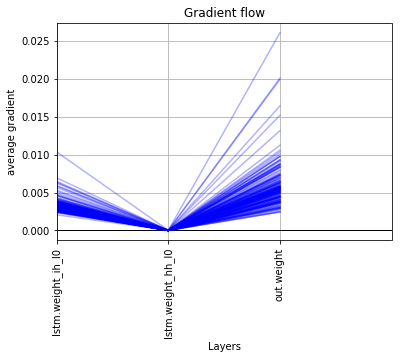

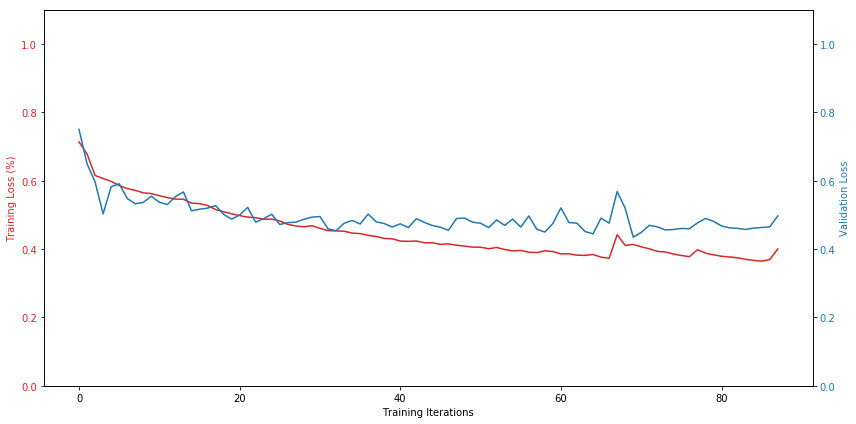

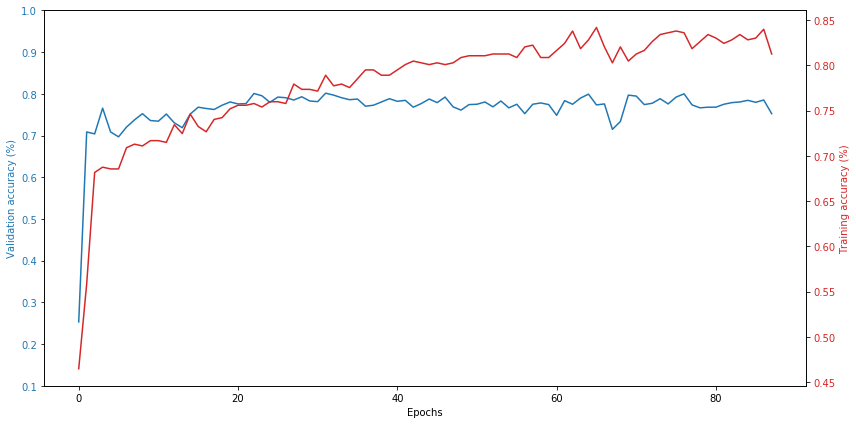

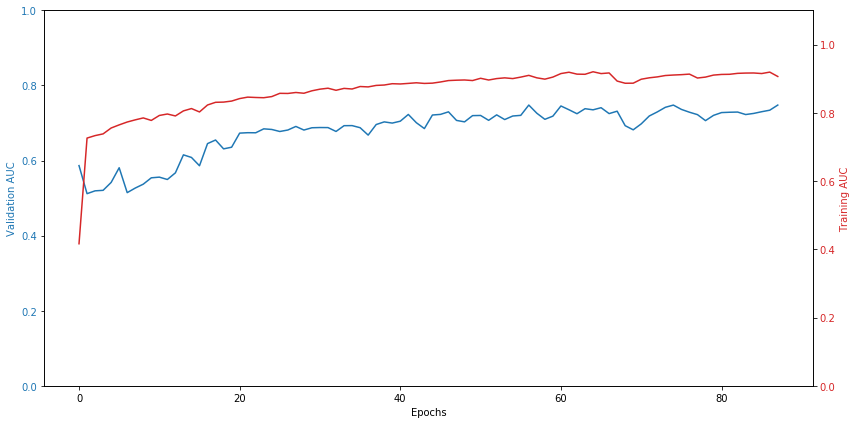

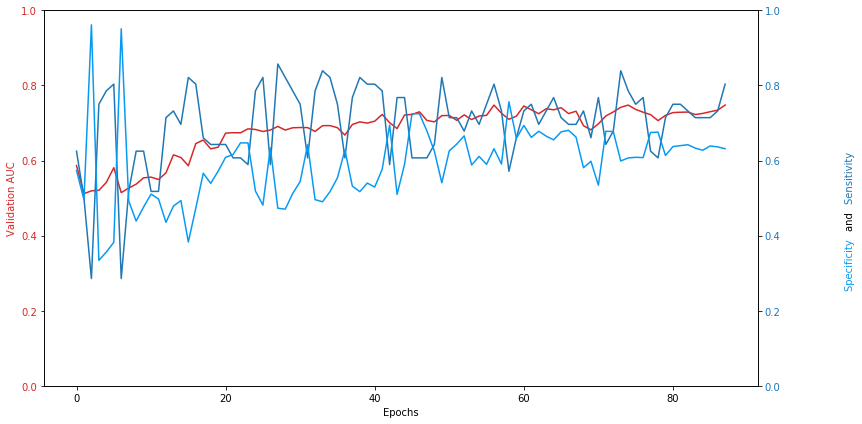


Fold  2
confused items in training set:  308
not_confused items in training set:  308
confused items in validation set:  32
not_confused items in validation set:  1252

Validation confused items:

['126a_V-SortTwoFactors-6-1.pkl', '126a_V-SortTwoFactors-6-2.pkl', '126a_V-SortTwoFactors-6-3.pkl', '126a_V-SortTwoFactors-6-4.pkl', '133a_H-CDV-16-1.pkl', '133a_H-CDV-16-2.pkl', '133a_H-CDV-16-3.pkl', '133a_H-CDV-16-4.pkl', '1b_V-CDV-17-1.pkl', '1b_V-CDV-17-2.pkl', '1b_V-CDV-17-3.pkl', '1b_V-CDV-17-4.pkl', '36a_V-SortTwoFactors-2-1.pkl', '36a_V-SortTwoFactors-2-2.pkl', '36a_V-SortTwoFactors-2-3.pkl', '36a_V-SortTwoFactors-2-4.pkl', '48a_V-SortTwoFactors-12-1.pkl', '48a_V-SortTwoFactors-12-2.pkl', '48a_V-SortTwoFactors-12-3.pkl', '48a_V-SortTwoFactors-12-4.pkl', '63a_H-SortTwoFactors-5-1.pkl', '63a_H-SortTwoFactors-5-2.pkl', '63a_H-SortTwoFactors-5-3.pkl', '63a_H-SortTwoFactors-5-4.pkl', '8a_V-SortTwoFactors-10-1.pkl', '8a_V-SortTwoFactors-10-2.pkl', '8a_V-SortTwoFactors-10-3.pkl', '8a_V-Sor

Training accuracy for epoch:  0.70703125
validation accuracy:  0.6390625
validation loss:  0.6713004946708679
validation recall:  0.6875
validation specificity:  0.688301282051282
validation AUC:  0.6912059294871794
Epochs without improvement:  1
[epoch: 20, batches:     2] loss: 0.53558 | accuracy: 0.71875
Training accuracy for epoch:  0.71875
validation accuracy:  0.69453125
validation loss:  0.6268501281738281
validation recall:  0.6875
validation specificity:  0.6955128205128205
validation AUC:  0.708809094551282
Epochs without improvement:  2
[epoch: 21, batches:     2] loss: 0.52906 | accuracy: 0.71094
Training accuracy for epoch:  0.7109375
validation accuracy:  0.6421875
validation loss:  0.6428483128547668
validation recall:  0.71875
validation specificity:  0.7131410256410257
validation AUC:  0.7163461538461537
Epochs without improvement:  3
[epoch: 22, batches:     2] loss: 0.52009 | accuracy: 0.73828
Training accuracy for epoch:  0.73828125
validation accuracy:  0.60703125


[epoch: 45, batches:     2] loss: 0.51194 | accuracy: 0.75195
Training accuracy for epoch:  0.751953125
validation accuracy:  0.6765625
validation loss:  0.6299718379974365
validation recall:  0.75
validation specificity:  0.6610576923076923
validation AUC:  0.6920823317307692
Epochs without improvement:  27
[epoch: 46, batches:     2] loss: 0.50709 | accuracy: 0.74805
Training accuracy for epoch:  0.748046875
validation accuracy:  0.6765625
validation loss:  0.6278834342956543
validation recall:  0.6875
validation specificity:  0.7107371794871795
validation AUC:  0.6881510416666666
Epochs without improvement:  28
[epoch: 47, batches:     2] loss: 0.50462 | accuracy: 0.75586
Training accuracy for epoch:  0.755859375
validation accuracy:  0.67734375
validation loss:  0.6290356874465942
validation recall:  0.6875
validation specificity:  0.6939102564102564
validation AUC:  0.6788611778846154
Epochs without improvement:  29
[epoch: 48, batches:     2] loss: 0.50252 | accuracy: 0.75586
Tra

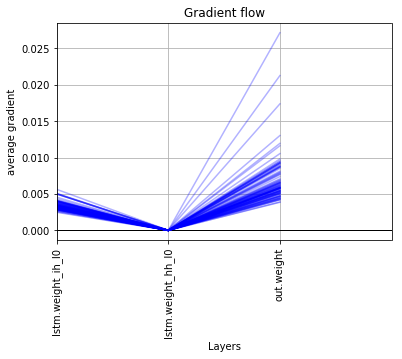

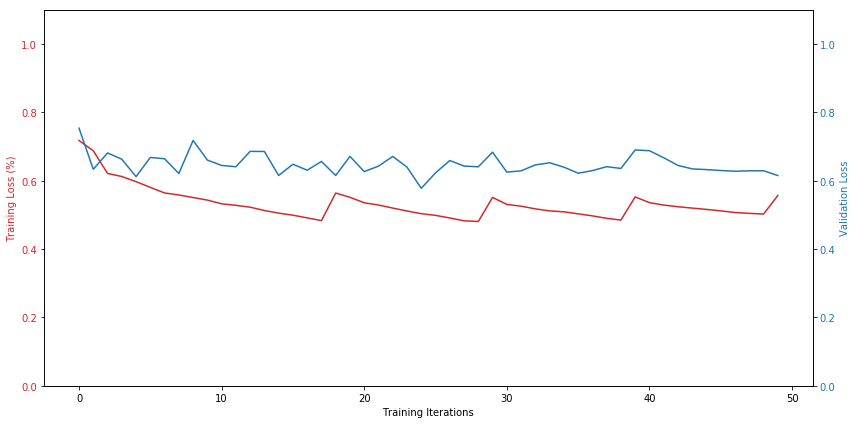

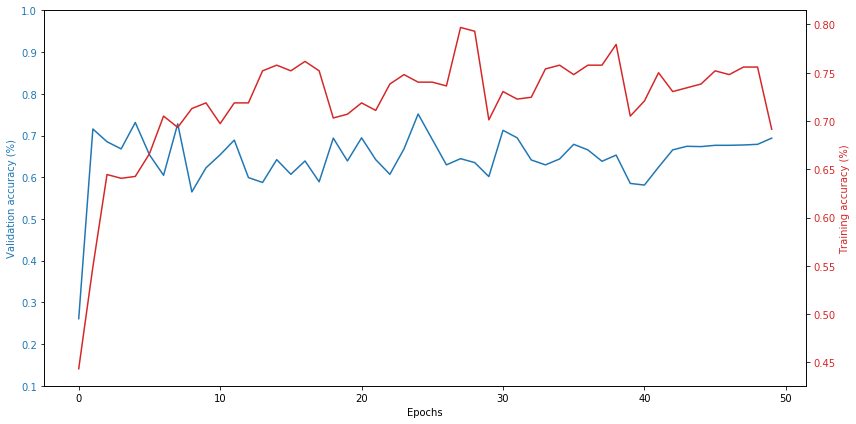

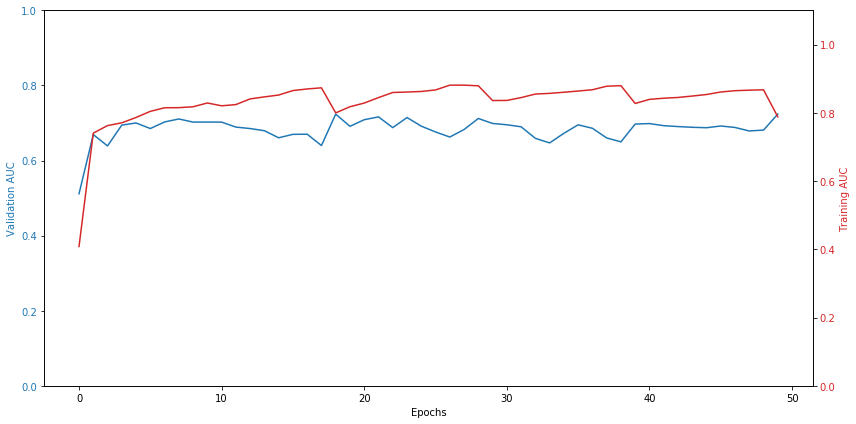

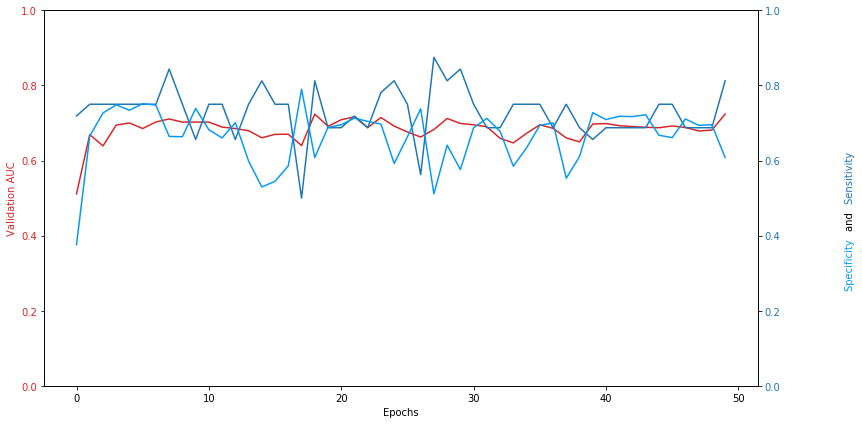


Fold  3
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  40
not_confused items in validation set:  1244

Validation confused items:

['111a_H-SortTwoFactors-3-1.pkl', '111a_H-SortTwoFactors-3-2.pkl', '111a_H-SortTwoFactors-3-3.pkl', '111a_H-SortTwoFactors-3-4.pkl', '137a_H-FE-4-1.pkl', '137a_H-FE-4-2.pkl', '137a_H-FE-4-3.pkl', '137a_H-FE-4-4.pkl', '137a_H-SortTwoFactors-2-1.pkl', '137a_H-SortTwoFactors-2-2.pkl', '137a_H-SortTwoFactors-2-3.pkl', '137a_H-SortTwoFactors-2-4.pkl', '137b_V-FE-20-1.pkl', '137b_V-FE-20-2.pkl', '137b_V-FE-20-3.pkl', '137b_V-FE-20-4.pkl', '145b_V-SortTwoFactors-10-1.pkl', '145b_V-SortTwoFactors-10-2.pkl', '145b_V-SortTwoFactors-10-3.pkl', '145b_V-SortTwoFactors-10-4.pkl', '145b_V-SortTwoFactors-24-1.pkl', '145b_V-SortTwoFactors-24-2.pkl', '145b_V-SortTwoFactors-24-3.pkl', '145b_V-SortTwoFactors-24-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-2.pkl', '14a_V-SortTwoFactors-3-3.pkl

Training accuracy for epoch:  0.740234375
validation accuracy:  0.59375
validation loss:  0.6598710417747498
validation recall:  0.5
validation specificity:  0.6580645161290323
validation AUC:  0.5980846774193548
Epochs without improvement:  7
[epoch: 20, batches:     2] loss: 0.49281 | accuracy: 0.76562
Training accuracy for epoch:  0.765625
validation accuracy:  0.59609375
validation loss:  0.6498346090316772
validation recall:  0.675
validation specificity:  0.535483870967742
validation AUC:  0.6248991935483871
Epochs without improvement:  8
[epoch: 21, batches:     2] loss: 0.49055 | accuracy: 0.75781
Training accuracy for epoch:  0.7578125
validation accuracy:  0.5640625
validation loss:  0.6731361746788025
validation recall:  0.875
validation specificity:  0.4346774193548387
validation AUC:  0.6221774193548386
Epochs without improvement:  9
[epoch: 22, batches:     2] loss: 0.48508 | accuracy: 0.74805
Training accuracy for epoch:  0.748046875
validation accuracy:  0.55
validation

[epoch: 44, batches:     2] loss: 0.47076 | accuracy: 0.78516
Training accuracy for epoch:  0.78515625
validation accuracy:  0.55859375
validation loss:  0.64082190990448
validation recall:  0.5
validation specificity:  0.8217741935483871
validation AUC:  0.6588508064516129
Epochs without improvement:  12
[epoch: 45, batches:     2] loss: 0.46258 | accuracy: 0.80273
Training accuracy for epoch:  0.802734375
validation accuracy:  0.58984375
validation loss:  0.6115173459053039
validation recall:  0.5
validation specificity:  0.8338709677419355
validation AUC:  0.6547782258064516
Epochs without improvement:  13
[epoch: 46, batches:     2] loss: 0.45761 | accuracy: 0.81250
Training accuracy for epoch:  0.8125
validation accuracy:  0.59453125
validation loss:  0.6193769454956055
validation recall:  0.525
validation specificity:  0.7790322580645161
validation AUC:  0.6597983870967741
Epochs without improvement:  14
[epoch: 47, batches:     2] loss: 0.45416 | accuracy: 0.80859
Training accur

Training accuracy for epoch:  0.8203125
validation accuracy:  0.60859375
validation loss:  0.6309704780578613
validation recall:  0.55
validation specificity:  0.7540322580645161
validation AUC:  0.684758064516129
Epochs without improvement:  3
[epoch: 70, batches:     2] loss: 0.43012 | accuracy: 0.82227
Training accuracy for epoch:  0.822265625
validation accuracy:  0.609375
validation loss:  0.6367778182029724
validation recall:  0.55
validation specificity:  0.7709677419354839
validation AUC:  0.6876209677419356
Epochs without improvement:  4
[epoch: 71, batches:     2] loss: 0.42851 | accuracy: 0.82031
Training accuracy for epoch:  0.8203125
validation accuracy:  0.6125
validation loss:  0.633410906791687
validation recall:  0.55
validation specificity:  0.7774193548387097
validation AUC:  0.6917741935483871
Epochs without improvement:  5
[epoch: 72, batches:     2] loss: 0.42752 | accuracy: 0.81641
Training accuracy for epoch:  0.81640625
validation accuracy:  0.60234375
validati

Validation AUC:  0.7123790322580645
Validation Loss:  0.6190794348716736
Epochs without improvement:  10
[epoch: 95, batches:     2] loss: 0.41526 | accuracy: 0.82617
Training accuracy for epoch:  0.826171875
validation accuracy:  0.615625
validation loss:  0.6223178505897522
validation recall:  0.55
validation specificity:  0.7790322580645161
validation AUC:  0.7072177419354838
Epochs without improvement:  11
[epoch: 96, batches:     2] loss: 0.40919 | accuracy: 0.82617
Training accuracy for epoch:  0.826171875
validation accuracy:  0.60234375
validation loss:  0.6327218413352966
validation recall:  0.55
validation specificity:  0.7943548387096774
validation AUC:  0.7025201612903226
Epochs without improvement:  12
[epoch: 97, batches:     2] loss: 0.40823 | accuracy: 0.82812
Training accuracy for epoch:  0.828125
validation accuracy:  0.61875
validation loss:  0.6210780084133148
validation recall:  0.55
validation specificity:  0.7830645161290323
validation AUC:  0.6999395161290323
Ep

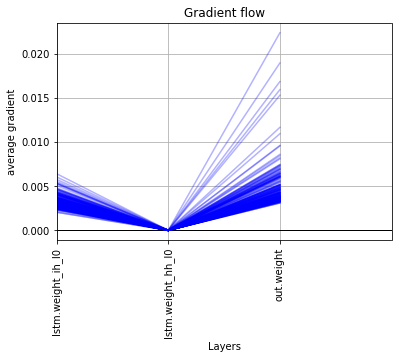

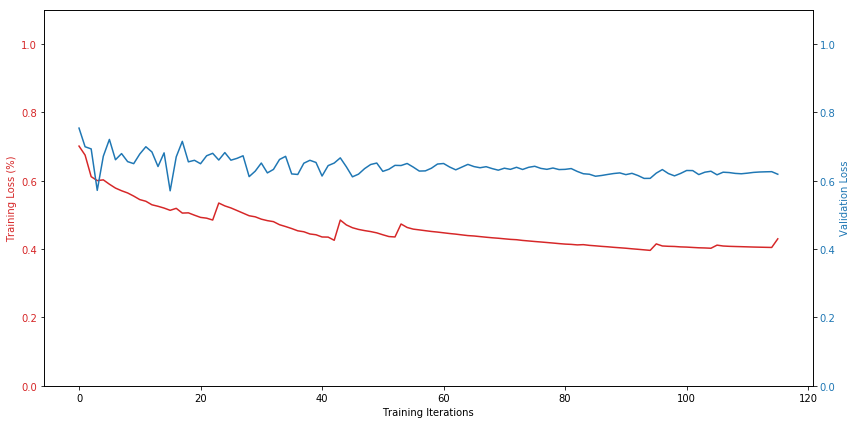

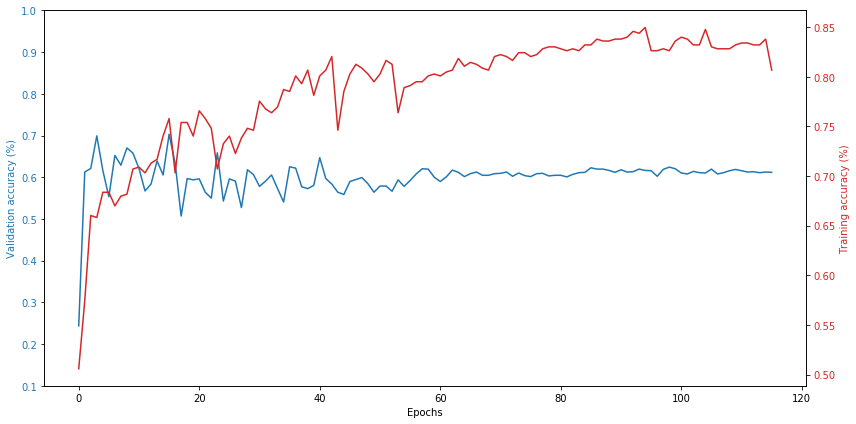

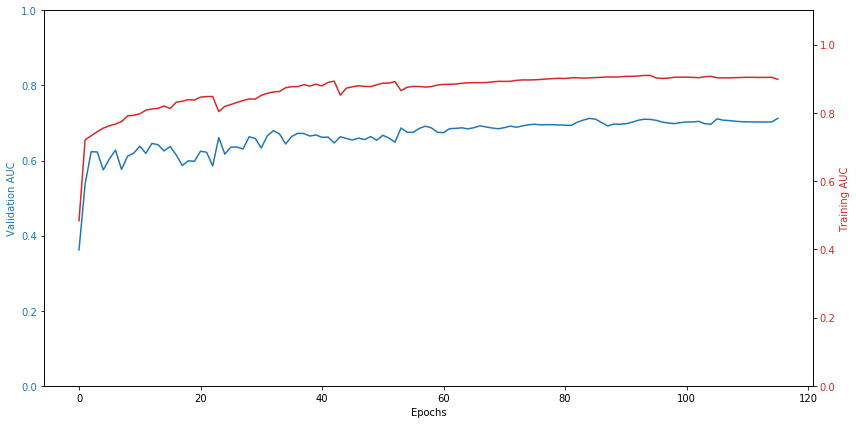

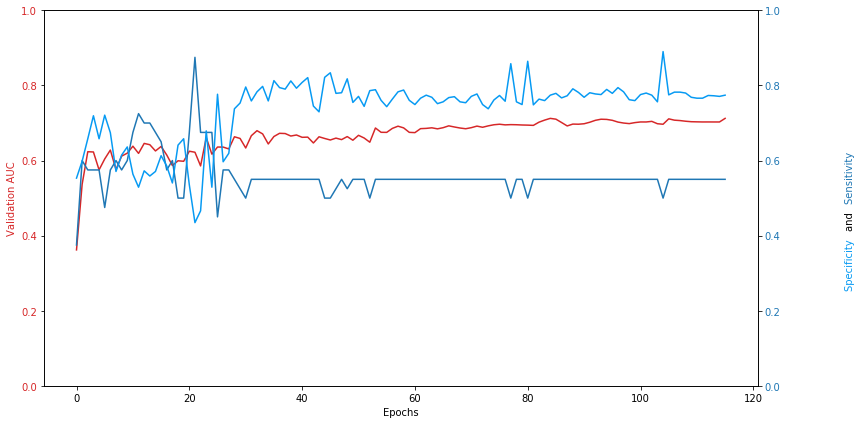


Fold  4
confused items in training set:  316
not_confused items in training set:  316
confused items in validation set:  24
not_confused items in validation set:  1260

Validation confused items:

['58a_V-SortTwoFactors-14-1.pkl', '58a_V-SortTwoFactors-14-2.pkl', '58a_V-SortTwoFactors-14-3.pkl', '58a_V-SortTwoFactors-14-4.pkl', '58a_V-SortTwoFactors-23-1.pkl', '58a_V-SortTwoFactors-23-2.pkl', '58a_V-SortTwoFactors-23-3.pkl', '58a_V-SortTwoFactors-23-4.pkl', '58a_V-SortTwoFactors-6-1.pkl', '58a_V-SortTwoFactors-6-2.pkl', '58a_V-SortTwoFactors-6-3.pkl', '58a_V-SortTwoFactors-6-4.pkl', '86a_V-FE-10-1.pkl', '86a_V-FE-10-2.pkl', '86a_V-FE-10-3.pkl', '86a_V-FE-10-4.pkl', '86a_V-SortTwoFactors-4-1.pkl', '86a_V-SortTwoFactors-4-2.pkl', '86a_V-SortTwoFactors-4-3.pkl', '86a_V-SortTwoFactors-4-4.pkl', '86b_H-CDV-6-1.pkl', '86b_H-CDV-6-2.pkl', '86b_H-CDV-6-3.pkl', '86b_H-CDV-6-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 632
    Root Location: ./dataset/augmented/train

[epoch: 20, batches:     2] loss: 0.58653 | accuracy: 0.67188
Training accuracy for epoch:  0.671875
validation accuracy:  0.8046875
validation loss:  0.5113780796527863
validation recall:  0.625
validation specificity:  0.7699044585987261
validation AUC:  0.7715631634819533
Epochs without improvement:  14
[epoch: 21, batches:     2] loss: 0.57550 | accuracy: 0.67578
Training accuracy for epoch:  0.67578125
validation accuracy:  0.78203125
validation loss:  0.5334881663322448
validation recall:  0.6666666666666666
validation specificity:  0.7587579617834395
validation AUC:  0.7952826433121019
Epochs without improvement:  15
[epoch: 22, batches:     2] loss: 0.56728 | accuracy: 0.70312
Training accuracy for epoch:  0.703125
validation accuracy:  0.76328125
validation loss:  0.5597803711891174
validation recall:  0.8333333333333334
validation specificity:  0.6711783439490446
validation AUC:  0.8102773354564756
Epochs without improvement:  16
[epoch: 23, batches:     2] loss: 0.56184 | ac

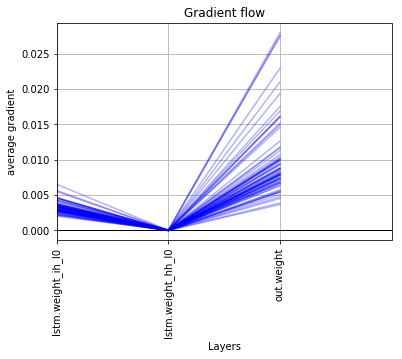

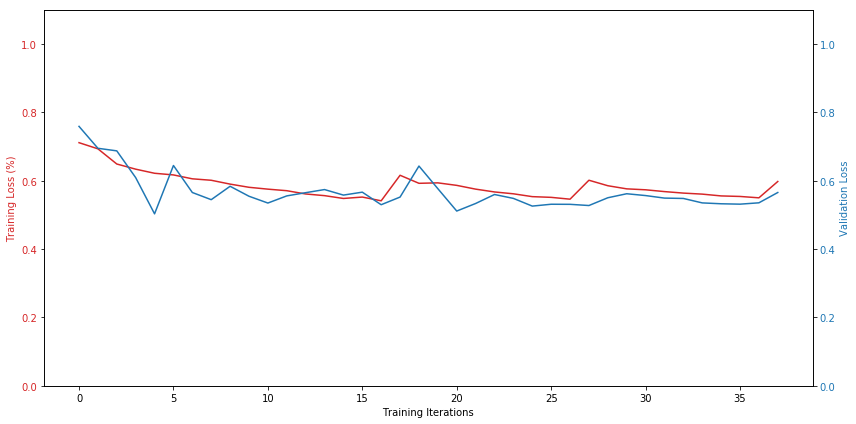

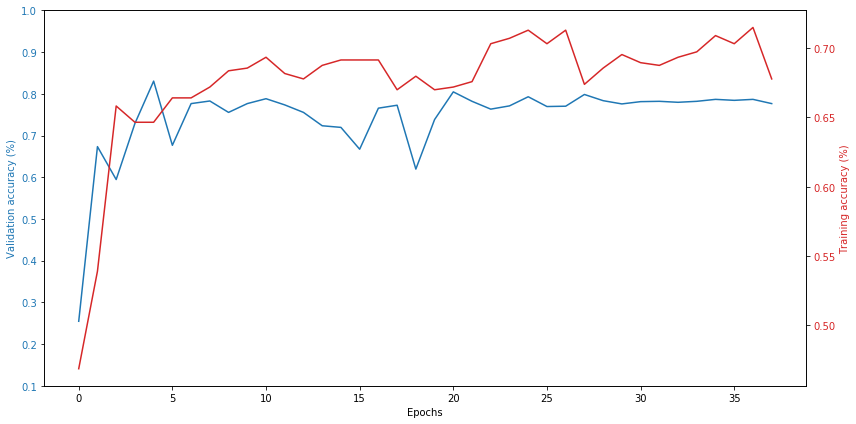

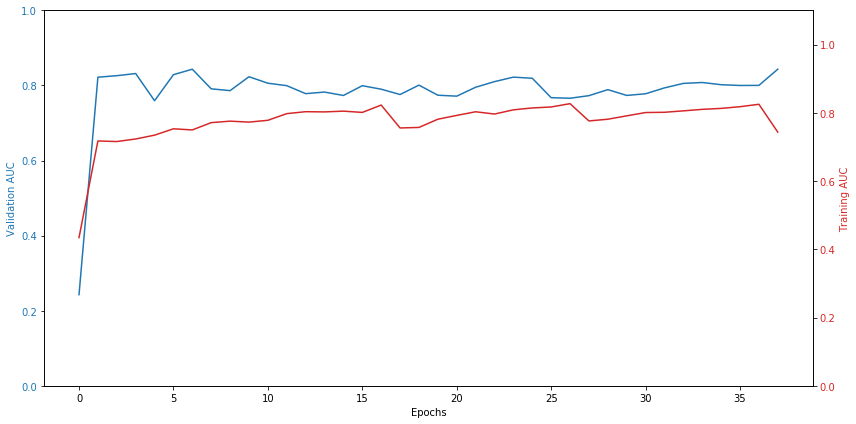

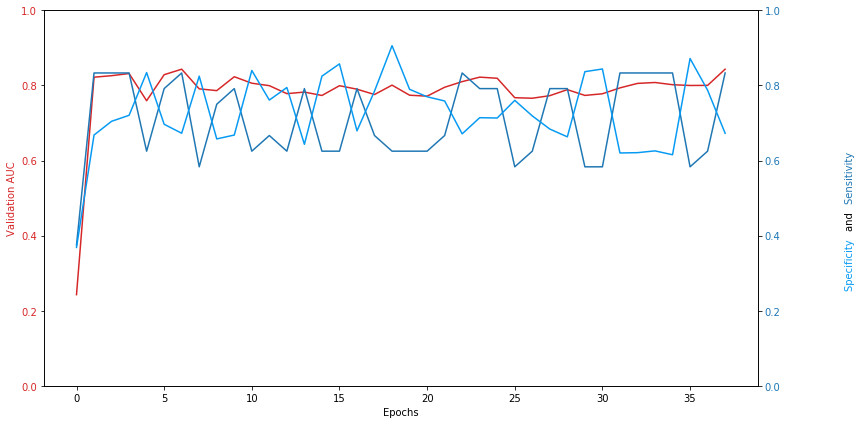


Fold  5
confused items in training set:  316
not_confused items in training set:  316
confused items in validation set:  24
not_confused items in validation set:  1260

Validation confused items:

['122a_V-SortTwoFactors-4-1.pkl', '122a_V-SortTwoFactors-4-2.pkl', '122a_V-SortTwoFactors-4-3.pkl', '122a_V-SortTwoFactors-4-4.pkl', '142a_V-CDV-15-1.pkl', '142a_V-CDV-15-2.pkl', '142a_V-CDV-15-3.pkl', '142a_V-CDV-15-4.pkl', '142b_H-CDV-22-1.pkl', '142b_H-CDV-22-2.pkl', '142b_H-CDV-22-3.pkl', '142b_H-CDV-22-4.pkl', '25a_H-RV-22-1.pkl', '25a_H-RV-22-2.pkl', '25a_H-RV-22-3.pkl', '25a_H-RV-22-4.pkl', '32a_V-SortTwoFactors-11-1.pkl', '32a_V-SortTwoFactors-11-2.pkl', '32a_V-SortTwoFactors-11-3.pkl', '32a_V-SortTwoFactors-11-4.pkl', '82a_V-SortTwoFactors-4-1.pkl', '82a_V-SortTwoFactors-4-2.pkl', '82a_V-SortTwoFactors-4-3.pkl', '82a_V-SortTwoFactors-4-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 632
    Root Location: ./dataset/augmented/train/
    Transforms (if any): N

[epoch: 20, batches:     2] loss: 0.55554 | accuracy: 0.69727
Training accuracy for epoch:  0.697265625
validation accuracy:  0.76953125
validation loss:  0.5366835296154022
validation recall:  0.7083333333333334
validation specificity:  0.5453821656050956
validation AUC:  0.688296178343949
Epochs without improvement:  5
[epoch: 21, batches:     2] loss: 0.54556 | accuracy: 0.70703
Training accuracy for epoch:  0.70703125
validation accuracy:  0.775
validation loss:  0.5350935161113739
validation recall:  0.7083333333333334
validation specificity:  0.5581210191082803
validation AUC:  0.6881634819532909
Epochs without improvement:  6
[epoch: 22, batches:     2] loss: 0.53427 | accuracy: 0.73242
Training accuracy for epoch:  0.732421875
validation accuracy:  0.74296875
validation loss:  0.5700902104377746
validation recall:  0.7083333333333334
validation specificity:  0.5453821656050956
validation AUC:  0.666202229299363
Epochs without improvement:  7
[epoch: 23, batches:     2] loss: 0.

[epoch: 45, batches:     2] loss: 0.54482 | accuracy: 0.70508
Training accuracy for epoch:  0.705078125
validation accuracy:  0.76875
validation loss:  0.5519423484802246
validation recall:  0.7083333333333334
validation specificity:  0.5549363057324841
validation AUC:  0.6746947983014862
No decrease in validation loss in 30 epochs. Stopping training early.
Finished Training
validation accuracy:  0.76875
validation loss:  0.5634372115135193
validation recall:  0.7083333333333334
validation specificity:  0.6679936305732485
validation AUC:  0.7393511146496815


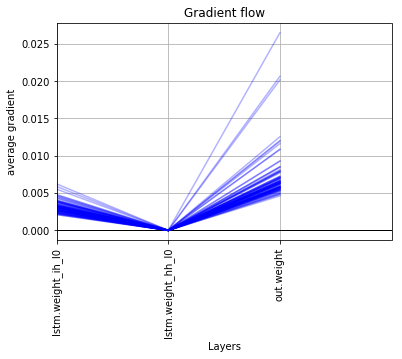

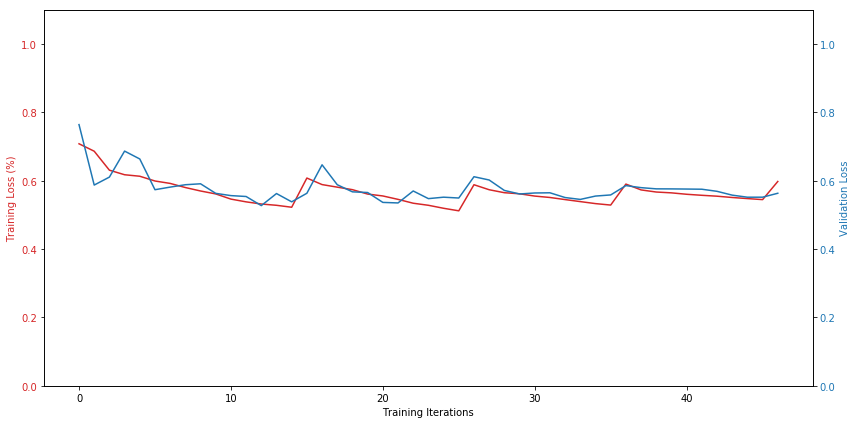

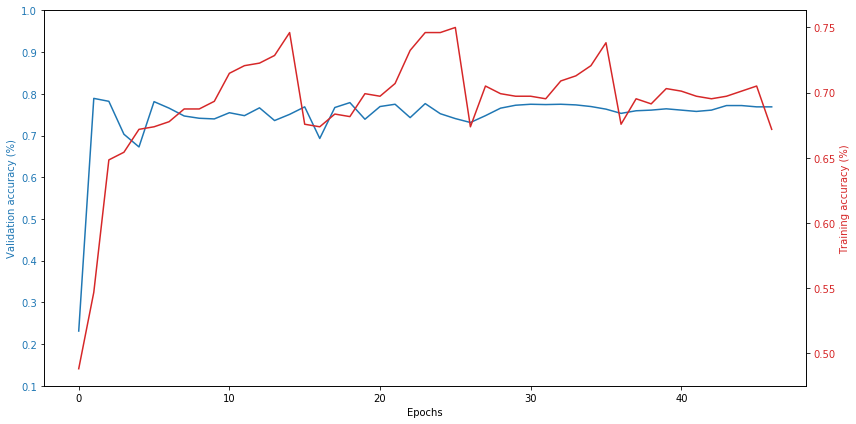

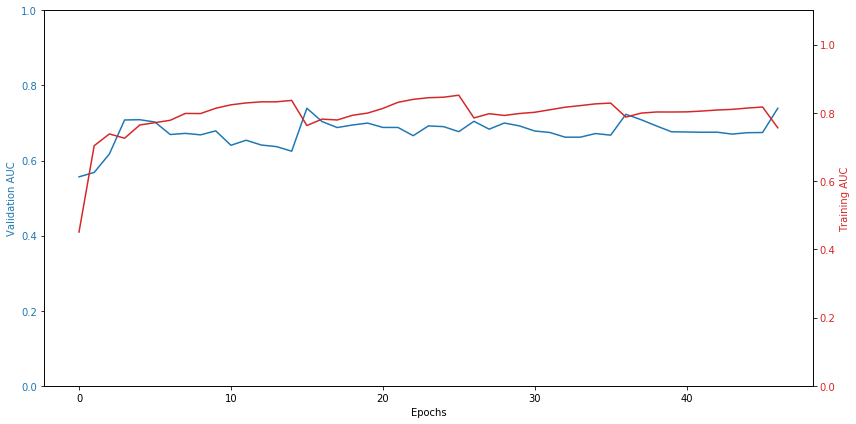

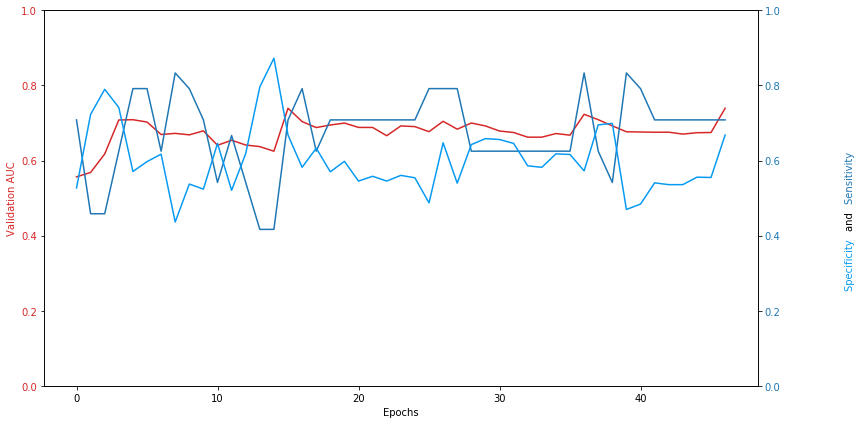


Fold  6
confused items in training set:  324
not_confused items in training set:  324
confused items in validation set:  16
not_confused items in validation set:  1272

Validation confused items:

['10a_V-CDV-2-1.pkl', '10a_V-CDV-2-2.pkl', '10a_V-CDV-2-3.pkl', '10a_V-CDV-2-4.pkl', '12b_H-CDV-5-1.pkl', '12b_H-CDV-5-2.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-4.pkl', '3a_H-SortTwoFactors-11-1.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '3a_H-SortTwoFactors-11-4.pkl', '9a_H-SortTwoFactors-12-1.pkl', '9a_H-SortTwoFactors-12-2.pkl', '9a_H-SortTwoFactors-12-3.pkl', '9a_H-SortTwoFactors-12-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 648
    Root Location: ./dataset/augmented/train/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 1288
    Root Location: ./dataset/augmented/val/
    Transforms (if any): None
    Target Transforms (if any): None
ConfusionLSTM

[epoch: 22, batches:     2] loss: 0.57899 | accuracy: 0.69336
Training accuracy for epoch:  0.693359375
validation accuracy:  0.77109375
validation loss:  0.5674895763397216
validation recall:  0.75
validation specificity:  0.6431962025316456
validation AUC:  0.7485166139240507
Epochs without improvement:  15
[epoch: 23, batches:     2] loss: 0.57119 | accuracy: 0.70312
Training accuracy for epoch:  0.703125
validation accuracy:  0.76796875
validation loss:  0.5487147748470307
validation recall:  0.625
validation specificity:  0.6392405063291139
validation AUC:  0.7378856803797469
Epochs without improvement:  16
[epoch: 24, batches:     2] loss: 0.56362 | accuracy: 0.69727
Training accuracy for epoch:  0.697265625
validation accuracy:  0.74765625
validation loss:  0.5813015937805176
validation recall:  0.9375
validation specificity:  0.5625
validation AUC:  0.7733880537974683
Epochs without improvement:  17
[epoch: 25, batches:     2] loss: 0.55687 | accuracy: 0.70312
Training accuracy

[epoch: 47, batches:     2] loss: 0.54409 | accuracy: 0.70703
Training accuracy for epoch:  0.70703125
validation accuracy:  0.78359375
validation loss:  0.5552091658115387
validation recall:  0.875
validation specificity:  0.5348101265822784
validation AUC:  0.7602848101265822
Epochs without improvement:  22
[epoch: 48, batches:     2] loss: 0.53962 | accuracy: 0.71289
Training accuracy for epoch:  0.712890625
validation accuracy:  0.778125
validation loss:  0.5623197197914124
validation recall:  0.9375
validation specificity:  0.5411392405063291
validation AUC:  0.7572191455696202
Epochs without improvement:  23
[epoch: 49, batches:     2] loss: 0.53728 | accuracy: 0.72070
Training accuracy for epoch:  0.720703125
validation accuracy:  0.778125
validation loss:  0.5640136361122131
validation recall:  0.875
validation specificity:  0.5585443037974683
validation AUC:  0.7436708860759493
Epochs without improvement:  24
[epoch: 50, batches:     2] loss: 0.53470 | accuracy: 0.72461
Traini

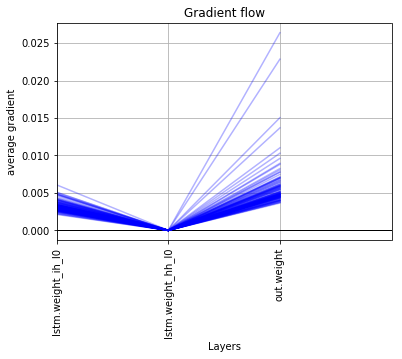

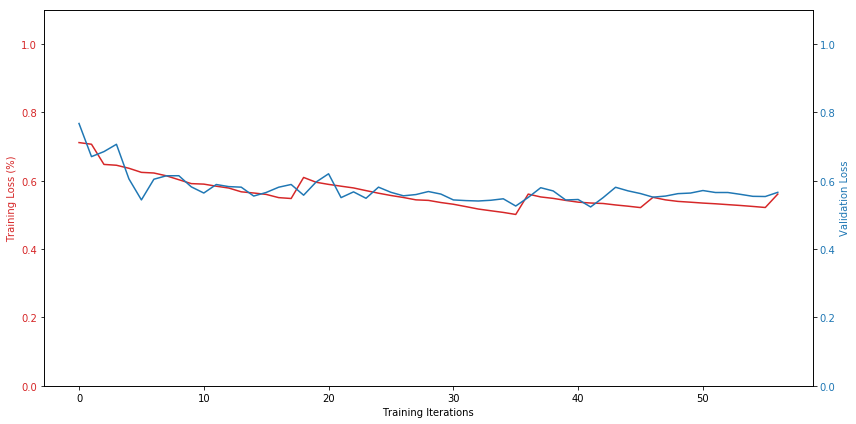

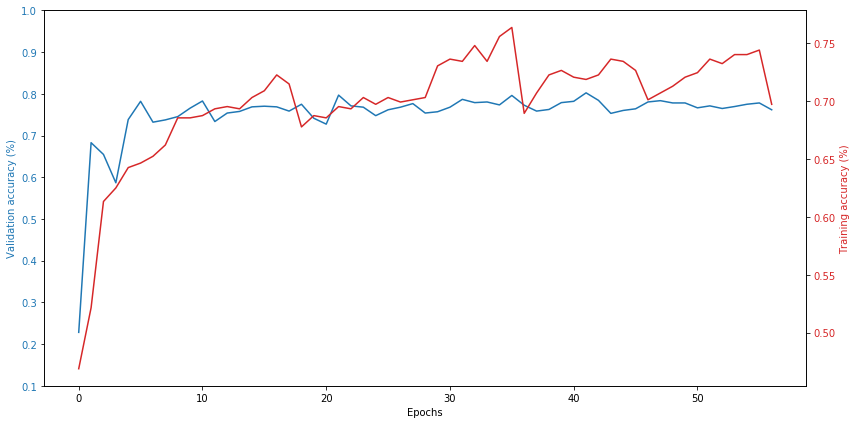

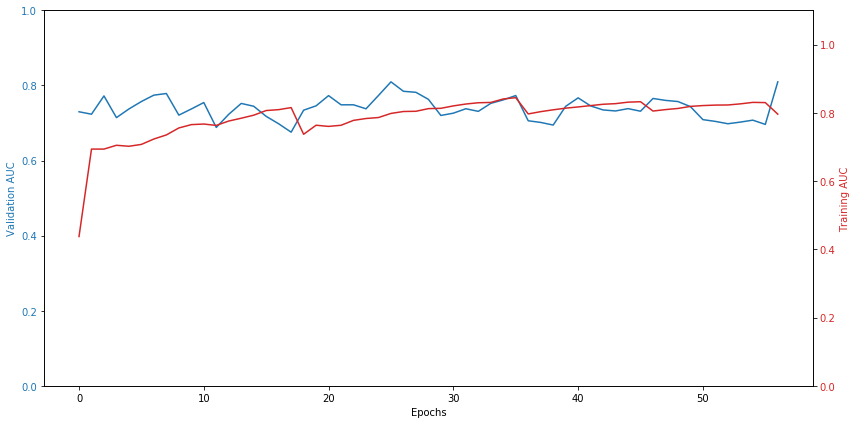

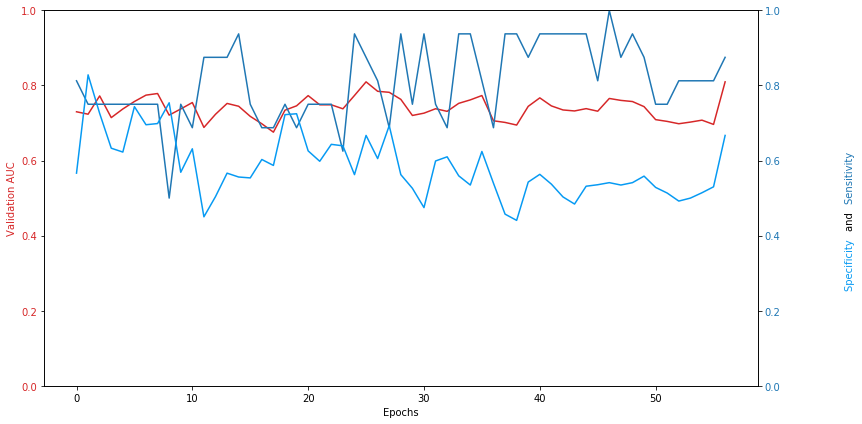


Fold  7
confused items in training set:  296
not_confused items in training set:  296
confused items in validation set:  44
not_confused items in validation set:  1240

Validation confused items:

['105a_H-FE-17-1.pkl', '105a_H-FE-17-2.pkl', '105a_H-FE-17-3.pkl', '105a_H-FE-17-4.pkl', '105a_H-RV-22-1.pkl', '105a_H-RV-22-2.pkl', '105a_H-RV-22-3.pkl', '105a_H-RV-22-4.pkl', '105a_H-RV-8-1.pkl', '105a_H-RV-8-2.pkl', '105a_H-RV-8-3.pkl', '105a_H-RV-8-4.pkl', '105b_V-FE-20-1.pkl', '105b_V-FE-20-2.pkl', '105b_V-FE-20-3.pkl', '105b_V-FE-20-4.pkl', '105b_V-FE-8-1.pkl', '105b_V-FE-8-2.pkl', '105b_V-FE-8-3.pkl', '105b_V-FE-8-4.pkl', '105b_V-RV-5-1.pkl', '105b_V-RV-5-2.pkl', '105b_V-RV-5-3.pkl', '105b_V-RV-5-4.pkl', '134b_H-CDV-15-1.pkl', '134b_H-CDV-15-2.pkl', '134b_H-CDV-15-3.pkl', '134b_H-CDV-15-4.pkl', '134b_H-CDV-4-1.pkl', '134b_H-CDV-4-2.pkl', '134b_H-CDV-4-3.pkl', '134b_H-CDV-4-4.pkl', '50a_V-SortTwoFactors-22-1.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '50a_V

[epoch: 19, batches:     2] loss: 0.48614 | accuracy: 0.76953
Training accuracy for epoch:  0.76953125
validation accuracy:  0.715625
validation loss:  0.5834533333778381
validation recall:  0.7045454545454546
validation specificity:  0.6634304207119741
validation AUC:  0.6534458664313033
Epochs without improvement:  6
[epoch: 20, batches:     2] loss: 0.48530 | accuracy: 0.75586
Training accuracy for epoch:  0.755859375
validation accuracy:  0.71875
validation loss:  0.5634109914302826
validation recall:  0.6363636363636364
validation specificity:  0.6593851132686084
validation AUC:  0.6489776404824948
Epochs without improvement:  7
[epoch: 21, batches:     2] loss: 0.48353 | accuracy: 0.78320
Training accuracy for epoch:  0.783203125
validation accuracy:  0.73359375
validation loss:  0.5732379198074341
validation recall:  0.5909090909090909
validation specificity:  0.790453074433657
validation AUC:  0.6406847602235952
Epochs without improvement:  8
[epoch: 22, batches:     2] loss: 0

[epoch: 43, batches:     2] loss: 0.47518 | accuracy: 0.76562
Training accuracy for epoch:  0.765625
validation accuracy:  0.784375
validation loss:  0.5691211342811584
validation recall:  0.6136363636363636
validation specificity:  0.7119741100323624
validation AUC:  0.6481318034716095
Epochs without improvement:  9
[epoch: 44, batches:     2] loss: 0.47053 | accuracy: 0.77734
Training accuracy for epoch:  0.77734375
validation accuracy:  0.78203125
validation loss:  0.5642616391181946
validation recall:  0.6818181818181818
validation specificity:  0.6383495145631068
validation AUC:  0.6388275963518681
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.00075
New learning rate: 0.000375
Validation AUC:  0.6881987349220359
Validation Loss:  0.5668969273567199
Epochs without improvement:  10
[epoch: 45, batches:     2] loss: 0.51567 | accuracy: 0.70508
Training accuracy for epoch:  0.705078125
validation accuracy:  0.7421875
validation loss:  0

[epoch: 67, batches:     2] loss: 0.50692 | accuracy: 0.72656
Training accuracy for epoch:  0.7265625
validation accuracy:  0.76171875
validation loss:  0.5957035779953003
validation recall:  0.7272727272727273
validation specificity:  0.6990291262135923
validation AUC:  0.6827007943512797
Epochs without improvement:  12
[epoch: 68, batches:     2] loss: 0.50477 | accuracy: 0.73242
Training accuracy for epoch:  0.732421875
validation accuracy:  0.76171875
validation loss:  0.5946985721588135
validation recall:  0.7272727272727273
validation specificity:  0.7038834951456311
validation AUC:  0.6807700794351279
Epochs without improvement:  13
[epoch: 69, batches:     2] loss: 0.50349 | accuracy: 0.73242
Training accuracy for epoch:  0.732421875
validation accuracy:  0.76328125
validation loss:  0.5943572878837585
validation recall:  0.7272727272727273
validation specificity:  0.7063106796116505
validation AUC:  0.6802919976463666
Epochs without improvement:  14
[epoch: 70, batches:     2]

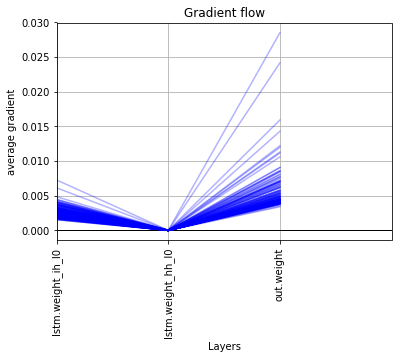

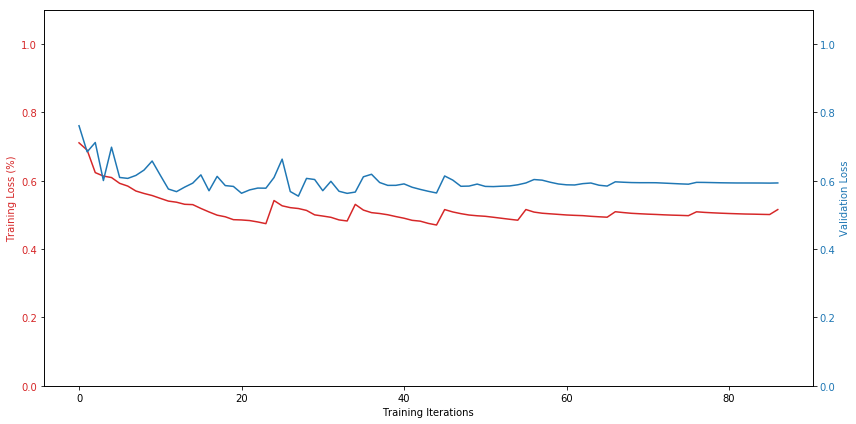

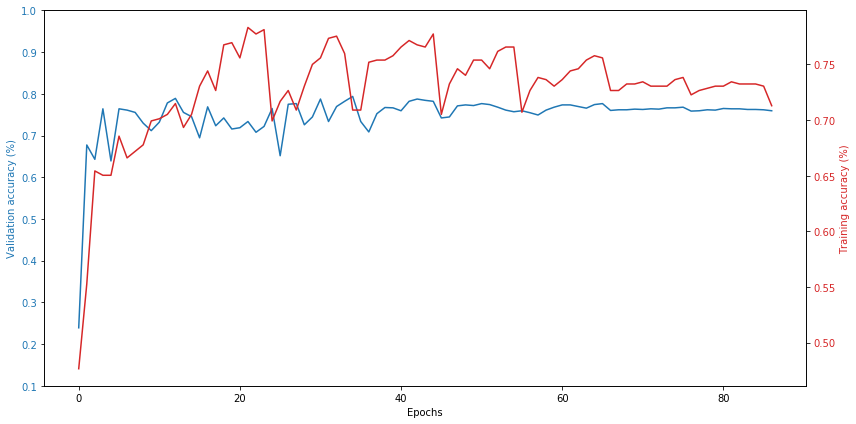

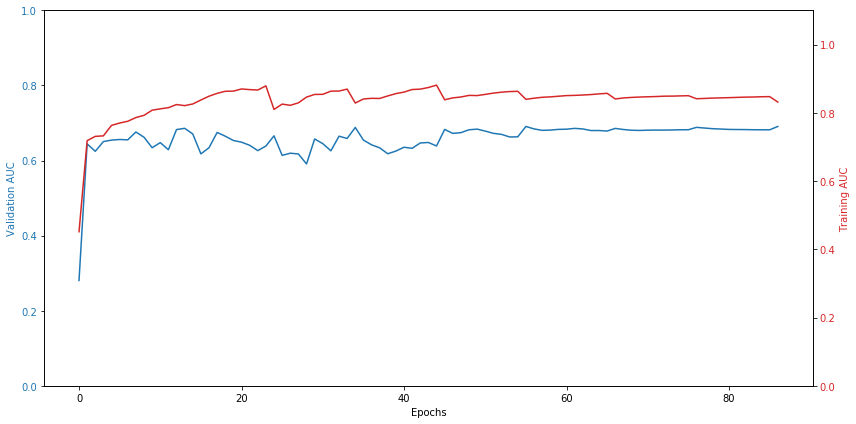

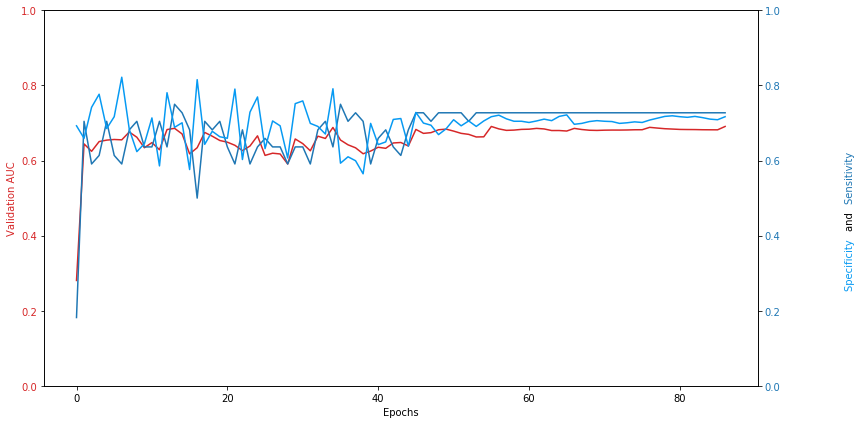


Fold  8
confused items in training set:  304
not_confused items in training set:  304
confused items in validation set:  36
not_confused items in validation set:  1248

Validation confused items:

['121a_H-CDV-9-1.pkl', '121a_H-CDV-9-2.pkl', '121a_H-CDV-9-3.pkl', '121a_H-CDV-9-4.pkl', '121a_H-SortTwoFactors-20-1.pkl', '121a_H-SortTwoFactors-20-2.pkl', '121a_H-SortTwoFactors-20-3.pkl', '121a_H-SortTwoFactors-20-4.pkl', '121b_V-FE-2-1.pkl', '121b_V-FE-2-2.pkl', '121b_V-FE-2-3.pkl', '121b_V-FE-2-4.pkl', '121b_V-SortTwoFactors-11-1.pkl', '121b_V-SortTwoFactors-11-2.pkl', '121b_V-SortTwoFactors-11-3.pkl', '121b_V-SortTwoFactors-11-4.pkl', '129b_V-SortTwoFactors-23-1.pkl', '129b_V-SortTwoFactors-23-2.pkl', '129b_V-SortTwoFactors-23-3.pkl', '129b_V-SortTwoFactors-23-4.pkl', '141a_H-RV-18-1.pkl', '141a_H-RV-18-2.pkl', '141a_H-RV-18-3.pkl', '141a_H-RV-18-4.pkl', '141a_H-SortTwoFactors-22-1.pkl', '141a_H-SortTwoFactors-22-2.pkl', '141a_H-SortTwoFactors-22-3.pkl', '141a_H-SortTwoFactors-22-4.pkl

[epoch: 19, batches:     2] loss: 0.54439 | accuracy: 0.70703
Training accuracy for epoch:  0.70703125
validation accuracy:  0.6625
validation loss:  0.6676219820976257
validation recall:  0.6388888888888888
validation specificity:  0.5385852090032154
validation AUC:  0.6065112540192926
Epochs without improvement:  12
[epoch: 20, batches:     2] loss: 0.54042 | accuracy: 0.72266
Training accuracy for epoch:  0.72265625
validation accuracy:  0.72734375
validation loss:  0.6368773102760314
validation recall:  0.4444444444444444
validation specificity:  0.7138263665594855
validation AUC:  0.570002679528403
Epochs without improvement:  13
[epoch: 21, batches:     2] loss: 0.53092 | accuracy: 0.72461
Training accuracy for epoch:  0.724609375
validation accuracy:  0.77265625
validation loss:  0.5870428383350372
validation recall:  0.5833333333333334
validation specificity:  0.5506430868167203
validation AUC:  0.5730618077884959
Epochs without improvement:  14
[epoch: 22, batches:     2] loss

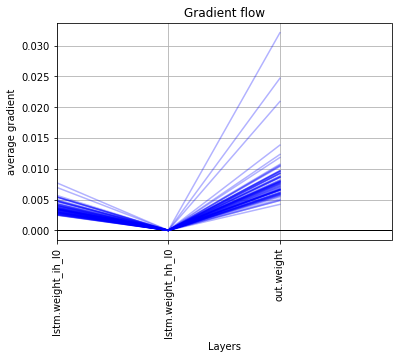

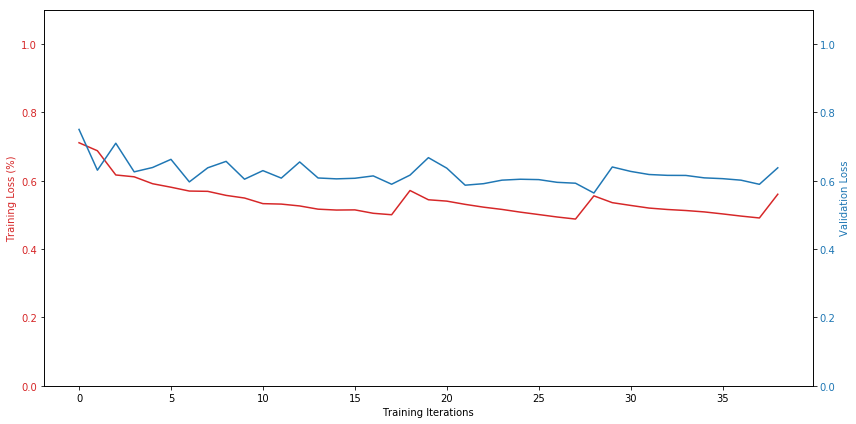

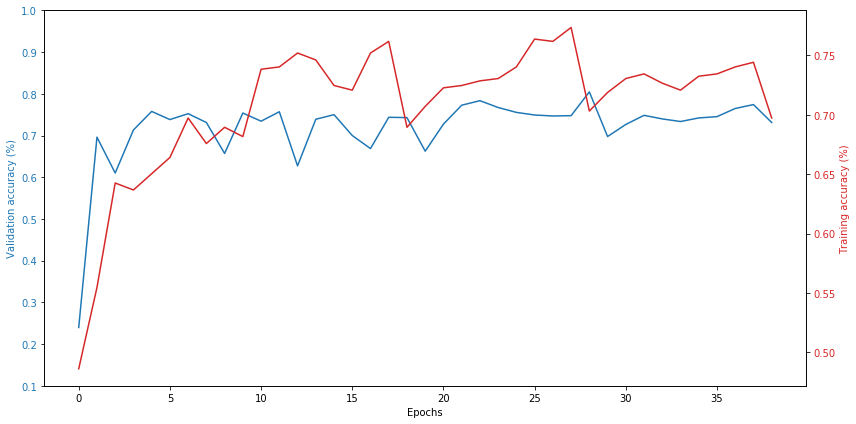

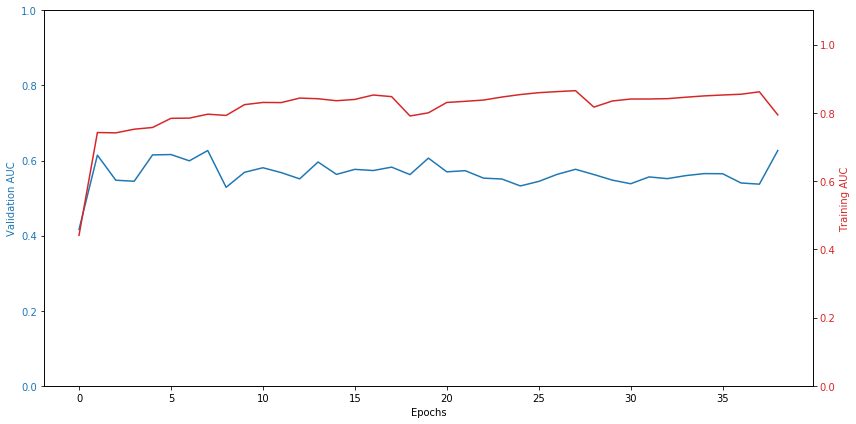

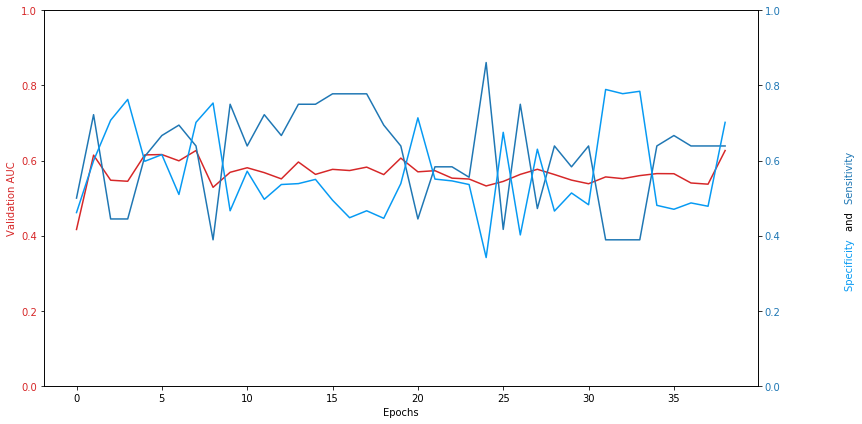


Fold  9
confused items in training set:  324
not_confused items in training set:  324
confused items in validation set:  16
not_confused items in validation set:  1268

Validation confused items:

['103a_H-CDV-12-1.pkl', '103a_H-CDV-12-2.pkl', '103a_H-CDV-12-3.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-4.pkl', '11a_H-SortTwoFactors-5-1.pkl', '11a_H-SortTwoFactors-5-2.pkl', '11a_H-SortTwoFactors-5-3.pkl', '11a_H-SortTwoFactors-5-4.pkl', '143a_H-CDV-17-1.pkl', '143a_H-CDV-17-2.pkl', '143a_H-CDV-17-3.pkl', '143a_H-CDV-17-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 648
    Root Location: ./dataset/augmented/train/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 1284
    Root Location: ./dataset/augmented/val/
    Transforms (if any): None
    Target Transforms (if any): None
ConfusionLSTM(
  (lstm): LSTM(14,

[epoch: 21, batches:     2] loss: 0.50180 | accuracy: 0.77344
Training accuracy for epoch:  0.7734375
validation accuracy:  0.70703125
validation loss:  0.5617863237857819
validation recall:  0.4375
validation specificity:  0.8931962025316456
validation AUC:  0.6042325949367089
Old best AUC:  0.5784216772151899
New best SUC:  0.6042325949367089
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 22, batches:     2] loss: 0.49539 | accuracy: 0.76367
Training accuracy for epoch:  0.763671875
validation accuracy:  0.759375
validation loss:  0.537759667634964
validation recall:  0.4375
validation specificity:  0.9121835443037974
validation AUC:  0.5946400316455696
Epochs without improvement:  1
[epoch: 23, batches:     2] loss: 0.49278 | accuracy: 0.75391
Training accuracy for epoch:  0.75390625
validation accuracy:  0.74140625
validation loss:  0.5549525678157806
validation recall:  0.4375
validation specificity:  0.9113924050632911
validation AUC:  0.5907337816455698

[epoch: 45, batches:     2] loss: 0.49826 | accuracy: 0.76367
Training accuracy for epoch:  0.763671875
validation accuracy:  0.6859375
validation loss:  0.5708856523036957
validation recall:  0.5625
validation specificity:  0.7737341772151899
validation AUC:  0.6631724683544303
Old best AUC:  0.6589200949367089
New best SUC:  0.6631724683544303
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 46, batches:     2] loss: 0.46387 | accuracy: 0.76953
Training accuracy for epoch:  0.76953125
validation accuracy:  0.5265625
validation loss:  0.7203518748283386
validation recall:  0.5625
validation specificity:  0.6360759493670886
validation AUC:  0.6225276898734178
Epochs without improvement:  1
[epoch: 47, batches:     2] loss: 0.47352 | accuracy: 0.77344
Training accuracy for epoch:  0.7734375
validation accuracy:  0.6890625
validation loss:  0.5602928340435028
validation recall:  0.5625
validation specificity:  0.745253164556962
validation AUC:  0.6569916930379747


[epoch: 70, batches:     2] loss: 0.42951 | accuracy: 0.81836
Training accuracy for epoch:  0.818359375
validation accuracy:  0.6703125
validation loss:  0.5884853839874268
validation recall:  0.5625
validation specificity:  0.7207278481012658
validation AUC:  0.6589200949367089
Epochs without improvement:  22
[epoch: 71, batches:     2] loss: 0.42347 | accuracy: 0.82227
Training accuracy for epoch:  0.822265625
validation accuracy:  0.70625
validation loss:  0.5659744083881378
validation recall:  0.5625
validation specificity:  0.7231012658227848
validation AUC:  0.6614418512658229
Epochs without improvement:  23
[epoch: 72, batches:     2] loss: 0.41782 | accuracy: 0.83203
Training accuracy for epoch:  0.83203125
validation accuracy:  0.73515625
validation loss:  0.5488124132156372
validation recall:  0.5625
validation specificity:  0.7341772151898734
validation AUC:  0.6603540348101266
Epochs without improvement:  24
[epoch: 73, batches:     2] loss: 0.41474 | accuracy: 0.83398
Trai

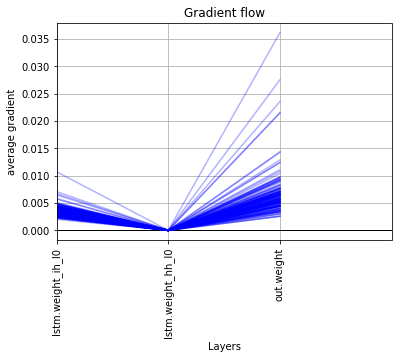

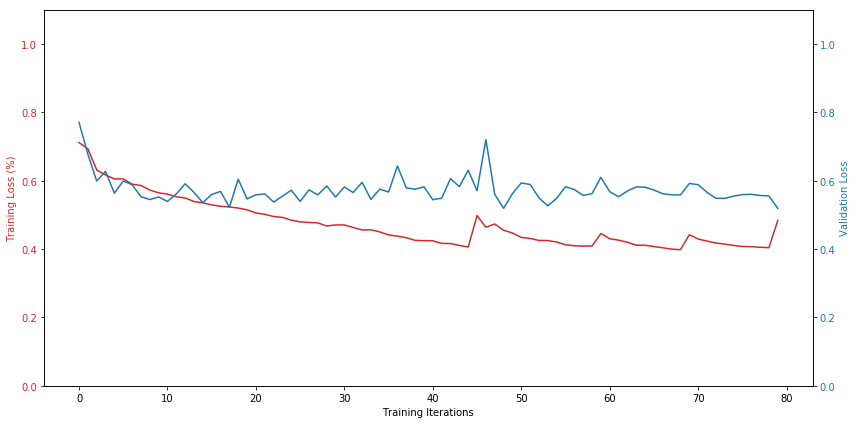

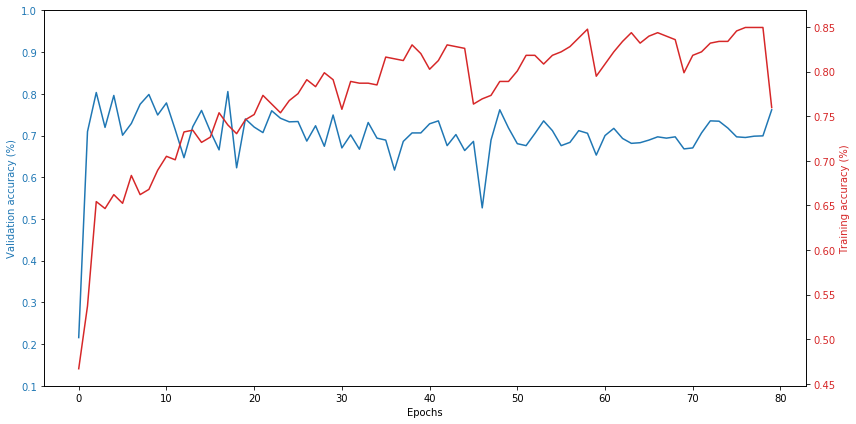

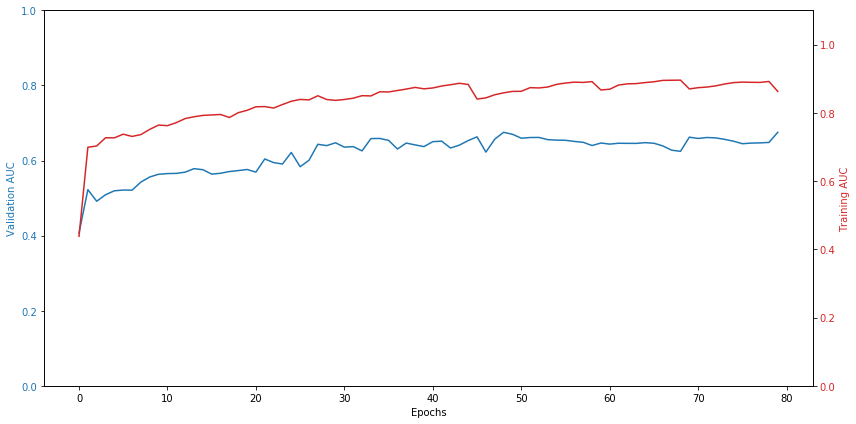

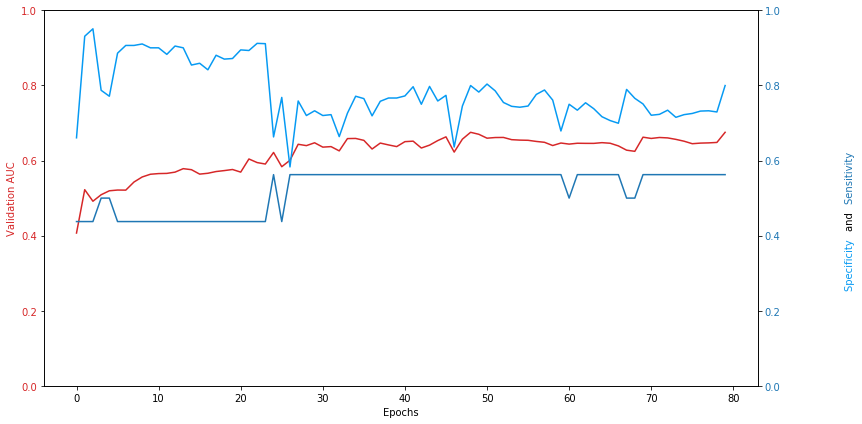


Fold  10
confused items in training set:  288
not_confused items in training set:  288
confused items in validation set:  52
not_confused items in validation set:  1228

Validation confused items:

['112a_V-SortTwoFactors-5-1.pkl', '112a_V-SortTwoFactors-5-2.pkl', '112a_V-SortTwoFactors-5-3.pkl', '112a_V-SortTwoFactors-5-4.pkl', '114a_V-SortTwoFactors-12-1.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '114a_V-SortTwoFactors-12-4.pkl', '130a_V-RV-10-1.pkl', '130a_V-RV-10-2.pkl', '130a_V-RV-10-3.pkl', '130a_V-RV-10-4.pkl', '35a_H-SortTwoFactors-15-1.pkl', '35a_H-SortTwoFactors-15-2.pkl', '35a_H-SortTwoFactors-15-3.pkl', '35a_H-SortTwoFactors-15-4.pkl', '35a_H-SortTwoFactors-22-1.pkl', '35a_H-SortTwoFactors-22-2.pkl', '35a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-22-4.pkl', '35a_H-SortTwoFactors-4-1.pkl', '35a_H-SortTwoFactors-4-2.pkl', '35a_H-SortTwoFactors-4-3.pkl', '35a_H-SortTwoFactors-4-4.pkl', '39a_H-SortTwoFactors-10-1.pkl', '39a_H-SortTwoFacto

[epoch: 17, batches:     2] loss: 0.54636 | accuracy: 0.70312
Training accuracy for epoch:  0.703125
validation accuracy:  0.83671875
validation loss:  0.5421169638633728
validation recall:  0.8461538461538461
validation specificity:  0.8281758957654723
validation AUC:  0.8708813580556249
Epochs without improvement:  4
[epoch: 18, batches:     2] loss: 0.54330 | accuracy: 0.70508
Training accuracy for epoch:  0.705078125
validation accuracy:  0.82890625
validation loss:  0.5557160973548889
validation recall:  0.8076923076923077
validation specificity:  0.8550488599348535
validation AUC:  0.8650400902029567
Epochs without improvement:  5
[epoch: 19, batches:     2] loss: 0.53715 | accuracy: 0.73047
Training accuracy for epoch:  0.73046875
validation accuracy:  0.81953125
validation loss:  0.5603831291198731
validation recall:  0.8269230769230769
validation specificity:  0.8517915309446255
validation AUC:  0.8595590077674768
Epochs without improvement:  6
[epoch: 20, batches:     2] loss

Training accuracy for epoch:  0.763671875
validation accuracy:  0.83125
validation loss:  0.5532557010650635
validation recall:  0.8076923076923077
validation specificity:  0.8835504885993485
validation AUC:  0.8838323728388875
Epochs without improvement:  28
[epoch: 42, batches:     2] loss: 0.52028 | accuracy: 0.76758
Training accuracy for epoch:  0.767578125
validation accuracy:  0.83203125
validation loss:  0.5530841231346131
validation recall:  0.8076923076923077
validation specificity:  0.8794788273615635
validation AUC:  0.8874342270107743
Epochs without improvement:  29
[epoch: 43, batches:     2] loss: 0.51749 | accuracy: 0.76953
Training accuracy for epoch:  0.76953125
validation accuracy:  0.82890625
validation loss:  0.5524814009666443
validation recall:  0.8653846153846154
validation specificity:  0.8273615635179153
validation AUC:  0.8863536707592082
No decrease in validation loss in 30 epochs. Stopping training early.
Finished Training
validation accuracy:  0.80234375
va

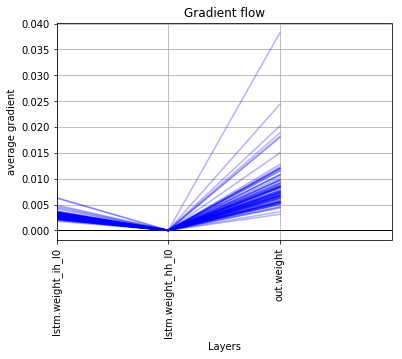

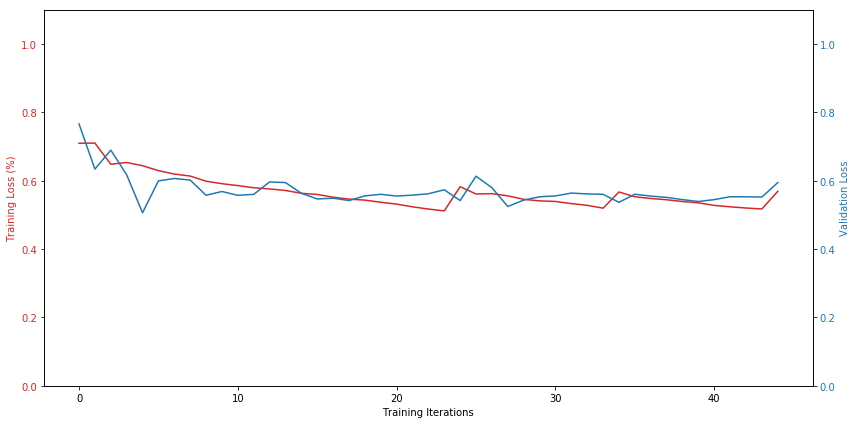

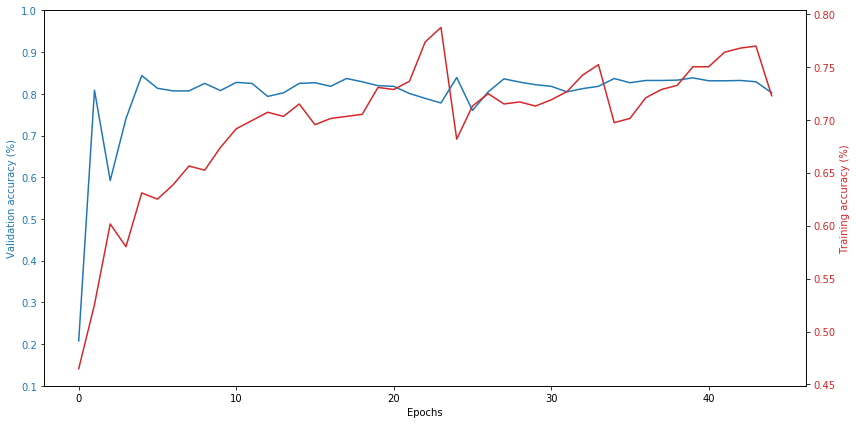

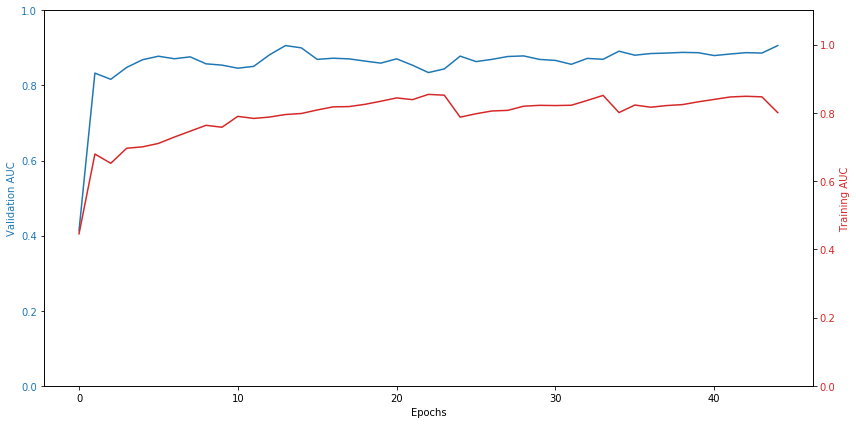

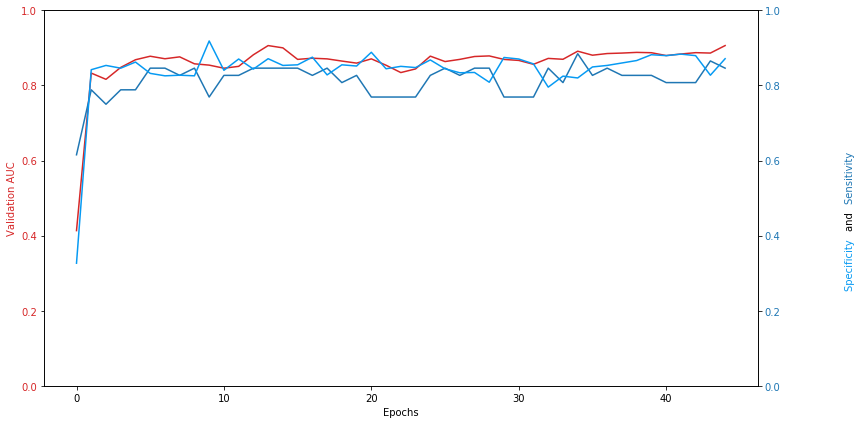


10-fold CV accuracy: 0.741953
10-fold CV sensitivity: 0.735755 
10-fold CV specificity: 0.711137 
10-fold CV AUC: 0.747542 


([0.75234375,
  0.69375,
  0.61171875,
  0.7765625,
  0.76875,
  0.76171875,
  0.759375,
  0.73125,
  0.76171875,
  0.80234375],
 [0.8035714285714286,
  0.8125,
  0.55,
  0.8333333333333334,
  0.7083333333333334,
  0.875,
  0.7272727272727273,
  0.6388888888888888,
  0.5625,
  0.8461538461538461],
 [0.6315359477124183,
  0.6081730769230769,
  0.7741935483870968,
  0.6727707006369427,
  0.6679936305732485,
  0.6669303797468354,
  0.7168284789644013,
  0.7017684887459807,
  0.7998417721518988,
  0.8713355048859935],
 [0.7478408029878618,
  0.7236828926282051,
  0.7123790322580645,
  0.8433850849256901,
  0.7393511146496815,
  0.8096815664556962,
  0.6908281847602235,
  0.6266970346552341,
  0.6752867879746836,
  0.9062891505888249])

In [9]:
np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

cross_validate(model_type='lstm',
                   folds=10,
                   epochs=300,
                   criterion_type='NLLLoss',
                   optimizer_type='Adam',
                   confused_path='./dataset/augmented/confused_highly_valid/',
                   not_confused_path='./dataset/augmented/not_confused_highly_valid/',
                   print_every=2,
                   plot_every=2,
                   hidden_size=256,
                   num_layers=1,
                   early_stopping=True,
                   early_stopping_patience=30,
                   rate_decay=True,
                   rate_decay_patience=10,
                   initial_learning_rate=0.003,
                   verbose=True)

## GRU CV:


Fold  1
confused items in training set:  284
not_confused items in training set:  284
confused items in validation set:  56
not_confused items in validation set:  1228

Validation confused items:

['131a_H-CDV-5-1.pkl', '131a_H-CDV-5-2.pkl', '131a_H-CDV-5-3.pkl', '131a_H-CDV-5-4.pkl', '131a_H-SortTwoFactors-12-1.pkl', '131a_H-SortTwoFactors-12-2.pkl', '131a_H-SortTwoFactors-12-3.pkl', '131a_H-SortTwoFactors-12-4.pkl', '131b_V-SortTwoFactors-21-1.pkl', '131b_V-SortTwoFactors-21-2.pkl', '131b_V-SortTwoFactors-21-3.pkl', '131b_V-SortTwoFactors-21-4.pkl', '132a_V-CDV-2-1.pkl', '132a_V-CDV-2-2.pkl', '132a_V-CDV-2-3.pkl', '132a_V-CDV-2-4.pkl', '132a_V-SortOverall-21-1.pkl', '132a_V-SortOverall-21-2.pkl', '132a_V-SortOverall-21-3.pkl', '132a_V-SortOverall-21-4.pkl', '132a_V-SortOverall-9-1.pkl', '132a_V-SortOverall-9-2.pkl', '132a_V-SortOverall-9-3.pkl', '132a_V-SortOverall-9-4.pkl', '132a_V-SortTwoFactors-6-1.pkl', '132a_V-SortTwoFactors-6-2.pkl', '132a_V-SortTwoFactors-6-3.pkl', '132a_V-So

Training accuracy for epoch:  0.7265625
validation accuracy:  0.75
validation loss:  0.49858358502388
validation recall:  0.5714285714285714
validation specificity:  0.5514705882352942
validation AUC:  0.6032183706816059
Old best AUC:  0.6023138422035481
New best SUC:  0.6032183706816059
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 18, batches:     2] loss: 0.50358 | accuracy: 0.74805
Training accuracy for epoch:  0.748046875
validation accuracy:  0.74921875
validation loss:  0.5028873801231384
validation recall:  0.5892857142857143
validation specificity:  0.571078431372549
validation AUC:  0.6134891456582633
Old best AUC:  0.6032183706816059
New best SUC:  0.6134891456582633
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 19, batches:     2] loss: 0.50175 | accuracy: 0.74219
Training accuracy for epoch:  0.7421875
validation accuracy:  0.72421875
validation loss:  0.5191021800041199
validation recall:  0.6071428571428571
validation

[epoch: 41, batches:     2] loss: 0.41332 | accuracy: 0.81445
Training accuracy for epoch:  0.814453125
validation accuracy:  0.7671875
validation loss:  0.4624841511249542
validation recall:  0.7142857142857143
validation specificity:  0.5514705882352942
validation AUC:  0.6456290849673202
Epochs without improvement:  9
[epoch: 42, batches:     2] loss: 0.40081 | accuracy: 0.82227
Training accuracy for epoch:  0.822265625
validation accuracy:  0.70703125
validation loss:  0.533647644519806
validation recall:  0.6428571428571429
validation specificity:  0.5449346405228758
validation AUC:  0.6397934173669467
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015
Validation AUC:  0.6597222222222222
Validation Loss:  0.5042226195335389
Epochs without improvement:  10
[epoch: 43, batches:     2] loss: 0.49301 | accuracy: 0.75977
Training accuracy for epoch:  0.759765625
validation accuracy:  0.64921875
validation loss:  

Training accuracy for epoch:  0.84765625
validation accuracy:  0.76640625
validation loss:  0.4623087406158447
validation recall:  0.6071428571428571
validation specificity:  0.6879084967320261
validation AUC:  0.6784401260504201
Epochs without improvement:  3
[epoch: 65, batches:     2] loss: 0.36962 | accuracy: 0.84375
Training accuracy for epoch:  0.84375
validation accuracy:  0.759375
validation loss:  0.47186451554298403
validation recall:  0.6607142857142857
validation specificity:  0.6470588235294118
validation AUC:  0.6820874183006536
Old best AUC:  0.6810224089635855
New best SUC:  0.6820874183006536
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 66, batches:     2] loss: 0.36518 | accuracy: 0.84570
Training accuracy for epoch:  0.845703125
validation accuracy:  0.77890625
validation loss:  0.44251856207847595
validation recall:  0.6607142857142857
validation specificity:  0.6609477124183006
validation AUC:  0.6845967553688141
Old best AUC:  0.6820874

[epoch: 88, batches:     2] loss: 0.29190 | accuracy: 0.89062
Training accuracy for epoch:  0.890625
validation accuracy:  0.78203125
validation loss:  0.45819537043571473
validation recall:  0.625
validation specificity:  0.6928104575163399
validation AUC:  0.704014939309057
Old best AUC:  0.7011700513538749
New best SUC:  0.704014939309057
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 89, batches:     2] loss: 0.28919 | accuracy: 0.88867
Training accuracy for epoch:  0.888671875
validation accuracy:  0.78984375
validation loss:  0.4453170120716095
validation recall:  0.625
validation specificity:  0.690359477124183
validation AUC:  0.6970559056956116
Epochs without improvement:  1
[epoch: 90, batches:     2] loss: 0.28685 | accuracy: 0.89453
Training accuracy for epoch:  0.89453125
validation accuracy:  0.78125
validation loss:  0.4574743151664734
validation recall:  0.6785714285714286
validation specificity:  0.6552287581699346
validation AUC:  0.699929971

[epoch: 113, batches:     2] loss: 0.23925 | accuracy: 0.90234
Training accuracy for epoch:  0.90234375
validation accuracy:  0.77890625
validation loss:  0.4860926389694214
validation recall:  0.6785714285714286
validation specificity:  0.6323529411764706
validation AUC:  0.7008636788048552
Epochs without improvement:  6
[epoch: 114, batches:     2] loss: 0.23588 | accuracy: 0.91016
Training accuracy for epoch:  0.91015625
validation accuracy:  0.796875
validation loss:  0.4428014874458313
validation recall:  0.6428571428571429
validation specificity:  0.6560457516339869
validation AUC:  0.6953052054154994
Epochs without improvement:  7
[epoch: 115, batches:     2] loss: 0.23396 | accuracy: 0.91016
Training accuracy for epoch:  0.91015625
validation accuracy:  0.78359375
validation loss:  0.4713482141494751
validation recall:  0.6785714285714286
validation specificity:  0.6584967320261438
validation AUC:  0.7112511671335201
Old best AUC:  0.7090919701213818
New best SUC:  0.7112511671

[epoch: 137, batches:     2] loss: 0.22990 | accuracy: 0.91016
Training accuracy for epoch:  0.91015625
validation accuracy:  0.80546875
validation loss:  0.4439159035682678
validation recall:  0.6785714285714286
validation specificity:  0.6421568627450981
validation AUC:  0.7104779411764706
Epochs without improvement:  4
[epoch: 138, batches:     2] loss: 0.22746 | accuracy: 0.91016
Training accuracy for epoch:  0.91015625
validation accuracy:  0.8015625
validation loss:  0.4521716058254242
validation recall:  0.625
validation specificity:  0.7050653594771242
validation AUC:  0.713264472455649
Epochs without improvement:  5
[epoch: 139, batches:     2] loss: 0.22614 | accuracy: 0.91406
Training accuracy for epoch:  0.9140625
validation accuracy:  0.7984375
validation loss:  0.4623641908168793
validation recall:  0.6071428571428571
validation specificity:  0.7165032679738562
validation AUC:  0.7018703314659197
Epochs without improvement:  6
[epoch: 140, batches:     2] loss: 0.22315 | 

[epoch: 162, batches:     2] loss: 0.21665 | accuracy: 0.91797
Training accuracy for epoch:  0.91796875
validation accuracy:  0.796875
validation loss:  0.45217718482017516
validation recall:  0.6428571428571429
validation specificity:  0.6919934640522876
validation AUC:  0.7078810690943045
Epochs without improvement:  29
[epoch: 163, batches:     2] loss: 0.21597 | accuracy: 0.91797
Training accuracy for epoch:  0.91796875
validation accuracy:  0.7984375
validation loss:  0.45252980589866637
validation recall:  0.6428571428571429
validation specificity:  0.6772875816993464
validation AUC:  0.7055030345471522
No decrease in validation loss in 30 epochs. Stopping training early.
Finished Training
validation accuracy:  0.7828125
validation loss:  0.4776369035243988
validation recall:  0.625
validation specificity:  0.7066993464052288
validation AUC:  0.7180059523809524


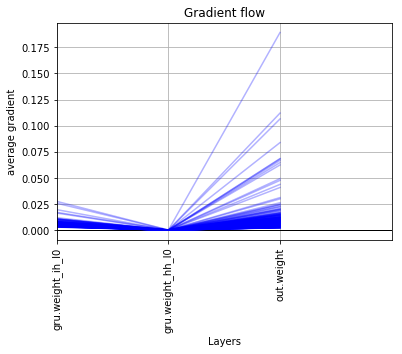

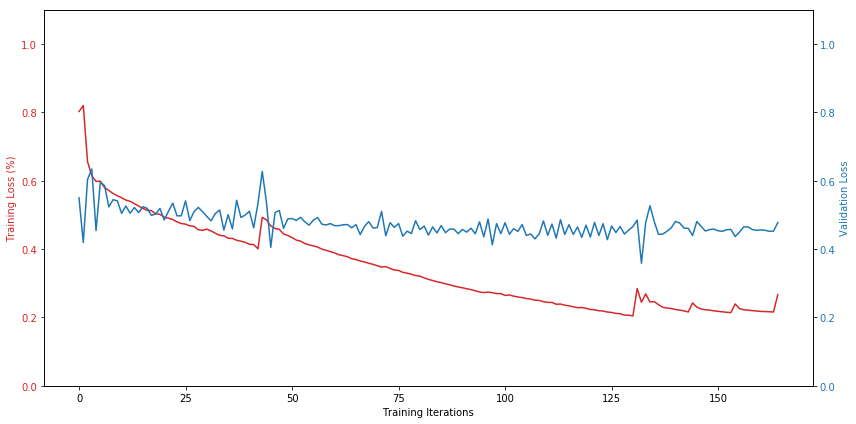

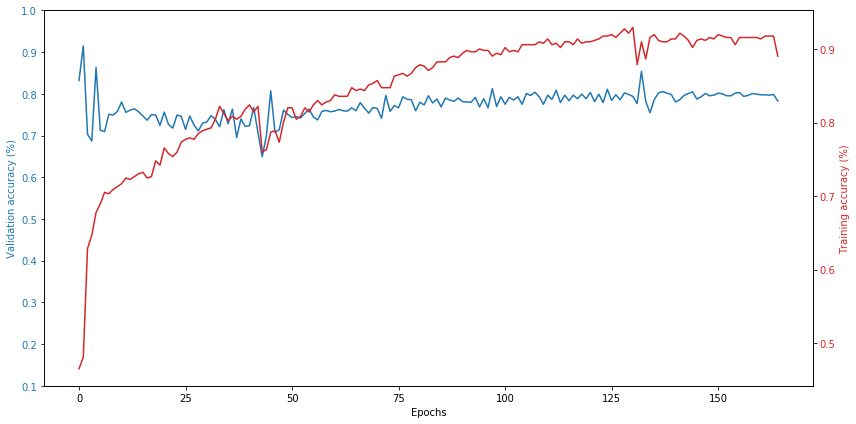

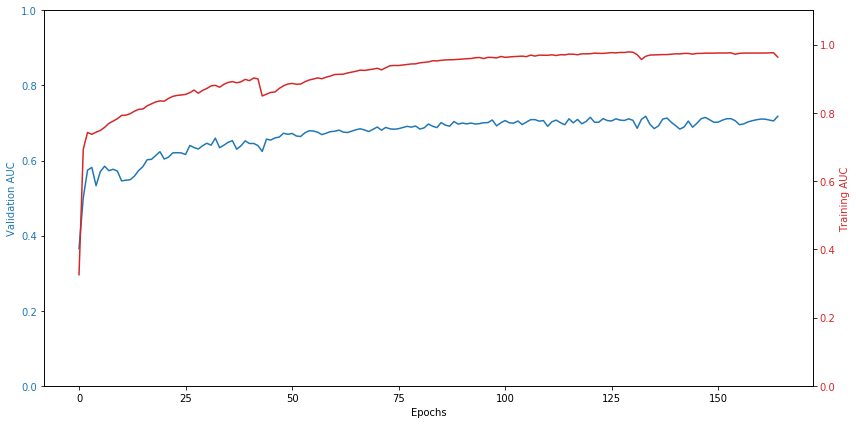

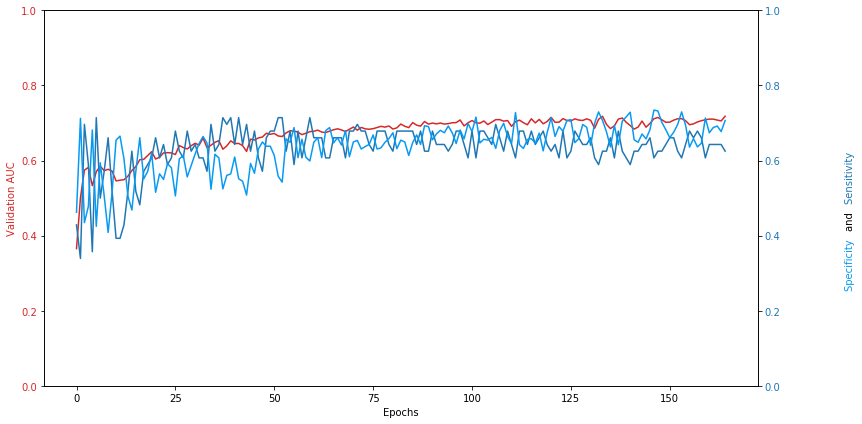


Fold  2
confused items in training set:  308
not_confused items in training set:  308
confused items in validation set:  32
not_confused items in validation set:  1252

Validation confused items:

['126a_V-SortTwoFactors-6-1.pkl', '126a_V-SortTwoFactors-6-2.pkl', '126a_V-SortTwoFactors-6-3.pkl', '126a_V-SortTwoFactors-6-4.pkl', '133a_H-CDV-16-1.pkl', '133a_H-CDV-16-2.pkl', '133a_H-CDV-16-3.pkl', '133a_H-CDV-16-4.pkl', '1b_V-CDV-17-1.pkl', '1b_V-CDV-17-2.pkl', '1b_V-CDV-17-3.pkl', '1b_V-CDV-17-4.pkl', '36a_V-SortTwoFactors-2-1.pkl', '36a_V-SortTwoFactors-2-2.pkl', '36a_V-SortTwoFactors-2-3.pkl', '36a_V-SortTwoFactors-2-4.pkl', '48a_V-SortTwoFactors-12-1.pkl', '48a_V-SortTwoFactors-12-2.pkl', '48a_V-SortTwoFactors-12-3.pkl', '48a_V-SortTwoFactors-12-4.pkl', '63a_H-SortTwoFactors-5-1.pkl', '63a_H-SortTwoFactors-5-2.pkl', '63a_H-SortTwoFactors-5-3.pkl', '63a_H-SortTwoFactors-5-4.pkl', '8a_V-SortTwoFactors-10-1.pkl', '8a_V-SortTwoFactors-10-2.pkl', '8a_V-SortTwoFactors-10-3.pkl', '8a_V-Sor

Training accuracy for epoch:  0.78515625
validation accuracy:  0.56328125
validation loss:  0.6984214544296264
validation recall:  0.6875
validation specificity:  0.6193910256410257
validation AUC:  0.6988181089743588
Epochs without improvement:  1
[epoch: 20, batches:     2] loss: 0.45423 | accuracy: 0.79688
Training accuracy for epoch:  0.796875
validation accuracy:  0.6546875
validation loss:  0.6004252433776855
validation recall:  0.84375
validation specificity:  0.5192307692307693
validation AUC:  0.642978766025641
Epochs without improvement:  2
[epoch: 21, batches:     2] loss: 0.45016 | accuracy: 0.80273
Training accuracy for epoch:  0.802734375
validation accuracy:  0.59296875
validation loss:  0.6533233284950256
validation recall:  0.78125
validation specificity:  0.5600961538461539
validation AUC:  0.6838817107371795
Epochs without improvement:  3
[epoch: 22, batches:     2] loss: 0.43943 | accuracy: 0.82031
Training accuracy for epoch:  0.8203125
validation accuracy:  0.6367

[epoch: 45, batches:     2] loss: 0.38653 | accuracy: 0.84180
Training accuracy for epoch:  0.841796875
validation accuracy:  0.56328125
validation loss:  0.7069076776504517
validation recall:  0.75
validation specificity:  0.5512820512820513
validation AUC:  0.6241736778846154
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.0015
New learning rate: 0.00075
Validation AUC:  0.7040514823717949
Validation Loss:  0.6334985971450806
Epochs without improvement:  20
[epoch: 46, batches:     2] loss: 0.42769 | accuracy: 0.80859
Training accuracy for epoch:  0.80859375
validation accuracy:  0.64140625
validation loss:  0.6103078722953796
validation recall:  0.8125
validation specificity:  0.5200320512820513
validation AUC:  0.6451322115384615
Epochs without improvement:  21
[epoch: 47, batches:     2] loss: 0.41594 | accuracy: 0.84180
Training accuracy for epoch:  0.841796875
validation accuracy:  0.6609375
validation loss:  0.5771257281303406
vali

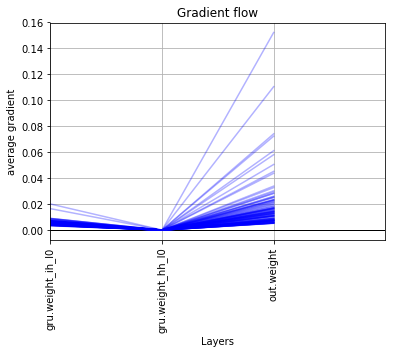

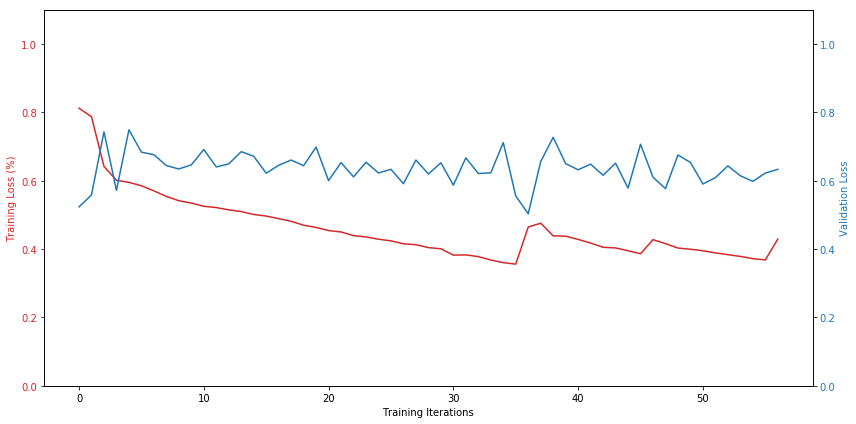

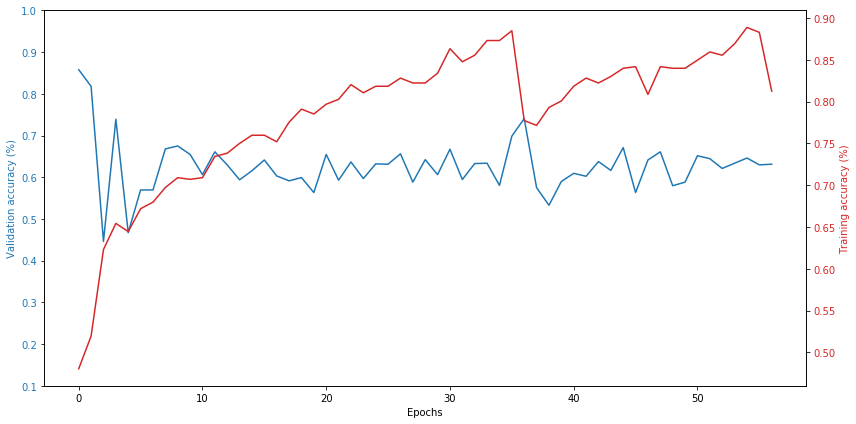

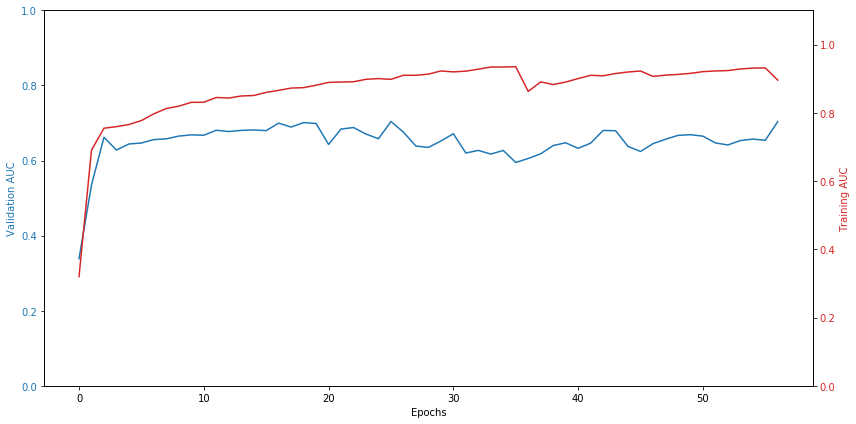

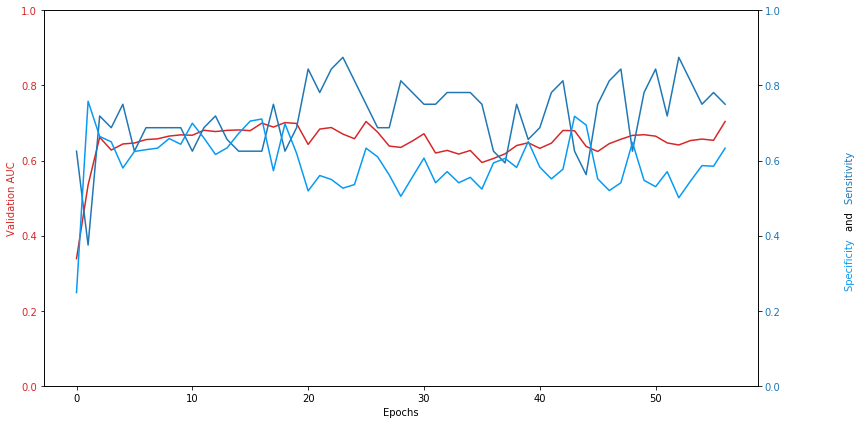


Fold  3
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  40
not_confused items in validation set:  1244

Validation confused items:

['111a_H-SortTwoFactors-3-1.pkl', '111a_H-SortTwoFactors-3-2.pkl', '111a_H-SortTwoFactors-3-3.pkl', '111a_H-SortTwoFactors-3-4.pkl', '137a_H-FE-4-1.pkl', '137a_H-FE-4-2.pkl', '137a_H-FE-4-3.pkl', '137a_H-FE-4-4.pkl', '137a_H-SortTwoFactors-2-1.pkl', '137a_H-SortTwoFactors-2-2.pkl', '137a_H-SortTwoFactors-2-3.pkl', '137a_H-SortTwoFactors-2-4.pkl', '137b_V-FE-20-1.pkl', '137b_V-FE-20-2.pkl', '137b_V-FE-20-3.pkl', '137b_V-FE-20-4.pkl', '145b_V-SortTwoFactors-10-1.pkl', '145b_V-SortTwoFactors-10-2.pkl', '145b_V-SortTwoFactors-10-3.pkl', '145b_V-SortTwoFactors-10-4.pkl', '145b_V-SortTwoFactors-24-1.pkl', '145b_V-SortTwoFactors-24-2.pkl', '145b_V-SortTwoFactors-24-3.pkl', '145b_V-SortTwoFactors-24-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-2.pkl', '14a_V-SortTwoFactors-3-3.pkl

[epoch: 19, batches:     2] loss: 0.48192 | accuracy: 0.77930
Training accuracy for epoch:  0.779296875
validation accuracy:  0.6015625
validation loss:  0.631821084022522
validation recall:  0.55
validation specificity:  0.8362903225806452
validation AUC:  0.7001612903225807
Epochs without improvement:  8
[epoch: 20, batches:     2] loss: 0.47547 | accuracy: 0.79883
Training accuracy for epoch:  0.798828125
validation accuracy:  0.7109375
validation loss:  0.5752281248569489
validation recall:  0.575
validation specificity:  0.7879032258064517
validation AUC:  0.6987701612903225
Epochs without improvement:  9
[epoch: 21, batches:     2] loss: 0.47405 | accuracy: 0.79297
Training accuracy for epoch:  0.79296875
validation accuracy:  0.5640625
validation loss:  0.6560178279876709
validation recall:  0.575
validation specificity:  0.7548387096774194
validation AUC:  0.6940524193548386
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New l

Training accuracy for epoch:  0.744140625
validation accuracy:  0.64921875
validation loss:  0.5964677691459656
validation recall:  0.6
validation specificity:  0.7556451612903226
validation AUC:  0.7306653225806451
Epochs without improvement:  13
[epoch: 44, batches:     2] loss: 0.47942 | accuracy: 0.77148
Training accuracy for epoch:  0.771484375
validation accuracy:  0.65625
validation loss:  0.5961180448532104
validation recall:  0.625
validation specificity:  0.7475806451612903
validation AUC:  0.7459879032258064
Epochs without improvement:  14
[epoch: 45, batches:     2] loss: 0.47132 | accuracy: 0.76953
Training accuracy for epoch:  0.76953125
validation accuracy:  0.62890625
validation loss:  0.6216259002685547
validation recall:  0.675
validation specificity:  0.682258064516129
validation AUC:  0.7595564516129032
Old best AUC:  0.7534879032258064
New best SUC:  0.7595564516129032
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 46, batches:     2] loss

[epoch: 68, batches:     2] loss: 0.45744 | accuracy: 0.78320
Training accuracy for epoch:  0.783203125
validation accuracy:  0.65078125
validation loss:  0.5970946907997131
validation recall:  0.575
validation specificity:  0.8290322580645161
validation AUC:  0.7478427419354838
Epochs without improvement:  2
[epoch: 69, batches:     2] loss: 0.45601 | accuracy: 0.78516
Training accuracy for epoch:  0.78515625
validation accuracy:  0.6265625
validation loss:  0.6187030076980591
validation recall:  0.575
validation specificity:  0.8346774193548387
validation AUC:  0.7507862903225807
Epochs without improvement:  3
[epoch: 70, batches:     2] loss: 0.45396 | accuracy: 0.78125
Training accuracy for epoch:  0.78125
validation accuracy:  0.62109375
validation loss:  0.6235894203186035
validation recall:  0.575
validation specificity:  0.8354838709677419
validation AUC:  0.7501612903225806
Epochs without improvement:  4
[epoch: 71, batches:     2] loss: 0.45198 | accuracy: 0.78516
Training ac

[epoch: 94, batches:     2] loss: 0.45448 | accuracy: 0.78125
Training accuracy for epoch:  0.78125
validation accuracy:  0.62734375
validation loss:  0.6182537078857422
validation recall:  0.575
validation specificity:  0.8330645161290322
validation AUC:  0.7523790322580646
Epochs without improvement:  28
[epoch: 95, batches:     2] loss: 0.45391 | accuracy: 0.78320
Training accuracy for epoch:  0.783203125
validation accuracy:  0.62734375
validation loss:  0.6180383086204528
validation recall:  0.575
validation specificity:  0.8330645161290322
validation AUC:  0.7523387096774193
Epochs without improvement:  29
[epoch: 96, batches:     2] loss: 0.45331 | accuracy: 0.78320
Training accuracy for epoch:  0.783203125
validation accuracy:  0.62890625
validation loss:  0.6175664663314819
validation recall:  0.575
validation specificity:  0.8330645161290322
validation AUC:  0.7524395161290323
No decrease in validation loss in 30 epochs. Stopping training early.
Finished Training
validation a

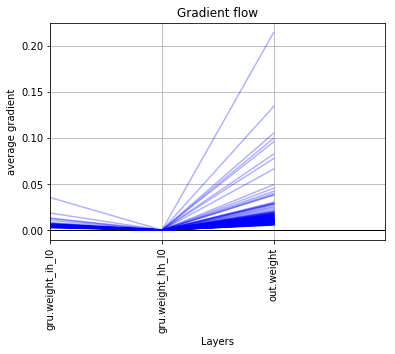

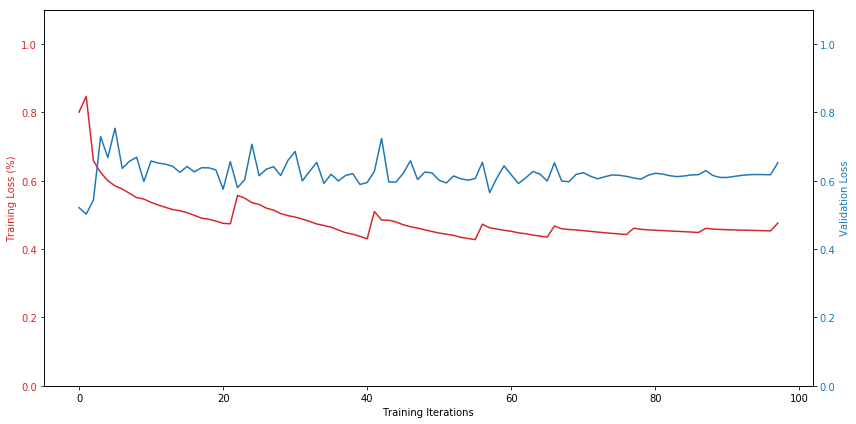

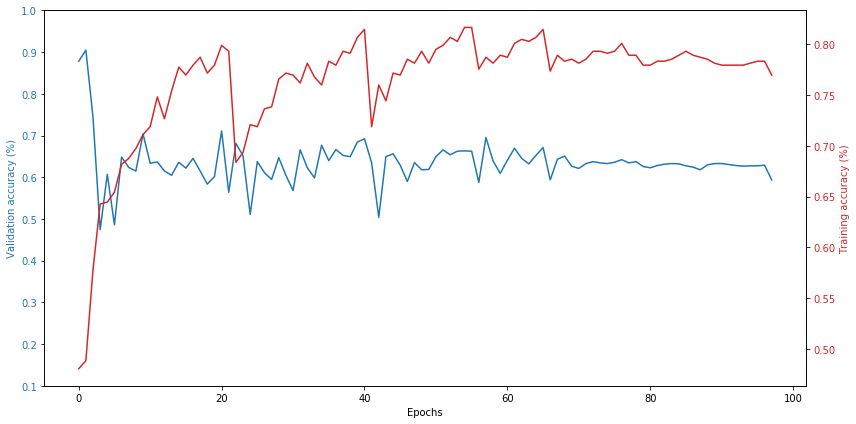

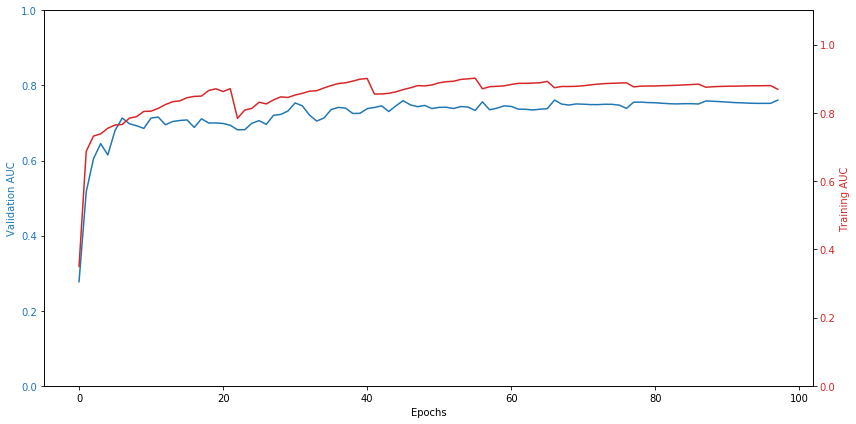

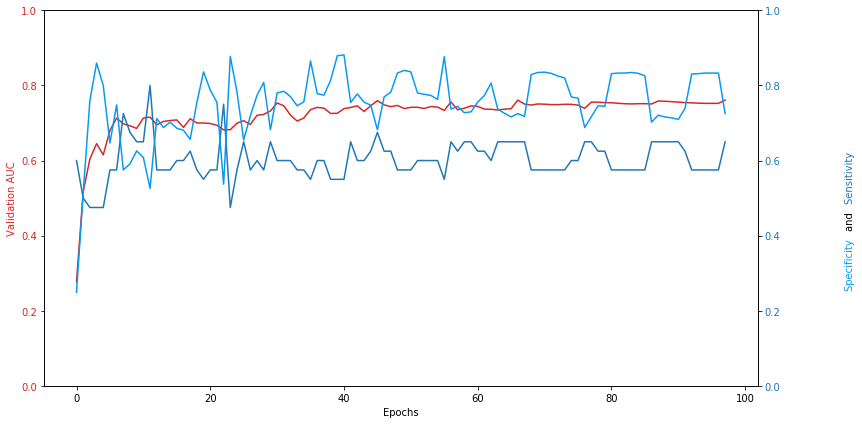


Fold  4
confused items in training set:  316
not_confused items in training set:  316
confused items in validation set:  24
not_confused items in validation set:  1260

Validation confused items:

['58a_V-SortTwoFactors-14-1.pkl', '58a_V-SortTwoFactors-14-2.pkl', '58a_V-SortTwoFactors-14-3.pkl', '58a_V-SortTwoFactors-14-4.pkl', '58a_V-SortTwoFactors-23-1.pkl', '58a_V-SortTwoFactors-23-2.pkl', '58a_V-SortTwoFactors-23-3.pkl', '58a_V-SortTwoFactors-23-4.pkl', '58a_V-SortTwoFactors-6-1.pkl', '58a_V-SortTwoFactors-6-2.pkl', '58a_V-SortTwoFactors-6-3.pkl', '58a_V-SortTwoFactors-6-4.pkl', '86a_V-FE-10-1.pkl', '86a_V-FE-10-2.pkl', '86a_V-FE-10-3.pkl', '86a_V-FE-10-4.pkl', '86a_V-SortTwoFactors-4-1.pkl', '86a_V-SortTwoFactors-4-2.pkl', '86a_V-SortTwoFactors-4-3.pkl', '86a_V-SortTwoFactors-4-4.pkl', '86b_H-CDV-6-1.pkl', '86b_H-CDV-6-2.pkl', '86b_H-CDV-6-3.pkl', '86b_H-CDV-6-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 632
    Root Location: ./dataset/augmented/train

[epoch: 19, batches:     2] loss: 0.58648 | accuracy: 0.68555
Training accuracy for epoch:  0.685546875
validation accuracy:  0.55703125
validation loss:  0.6391532301902771
validation recall:  0.75
validation specificity:  0.64171974522293
validation AUC:  0.7624071125265393
Epochs without improvement:  1
[epoch: 20, batches:     2] loss: 0.55758 | accuracy: 0.71289
Training accuracy for epoch:  0.712890625
validation accuracy:  0.82109375
validation loss:  0.48419228196144104
validation recall:  0.5833333333333334
validation specificity:  0.7571656050955414
validation AUC:  0.716129246284501
Epochs without improvement:  2
[epoch: 21, batches:     2] loss: 0.55164 | accuracy: 0.71094
Training accuracy for epoch:  0.7109375
validation accuracy:  0.7703125
validation loss:  0.5198166847229004
validation recall:  0.5833333333333334
validation specificity:  0.76671974522293
validation AUC:  0.7011345541401275
Epochs without improvement:  3
[epoch: 22, batches:     2] loss: 0.53545 | accur

Training accuracy for epoch:  0.7421875
validation accuracy:  0.65625
validation loss:  0.5983390808105469
validation recall:  0.5833333333333334
validation specificity:  0.7484076433121019
validation AUC:  0.7298633227176221
Epochs without improvement:  25
[epoch: 44, batches:     2] loss: 0.53117 | accuracy: 0.73828
Training accuracy for epoch:  0.73828125
validation accuracy:  0.621875
validation loss:  0.6183801174163819
validation recall:  0.5833333333333334
validation specificity:  0.7515923566878981
validation AUC:  0.7280387473460722
Epochs without improvement:  26
[epoch: 45, batches:     2] loss: 0.52904 | accuracy: 0.74219
Training accuracy for epoch:  0.7421875
validation accuracy:  0.64765625
validation loss:  0.6053796410560608
validation recall:  0.5833333333333334
validation specificity:  0.7547770700636943
validation AUC:  0.7257829087048833
Epochs without improvement:  27
[epoch: 46, batches:     2] loss: 0.52530 | accuracy: 0.74023
Training accuracy for epoch:  0.740

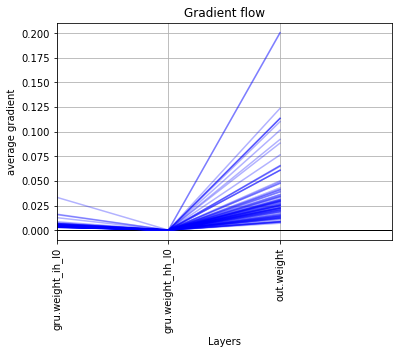

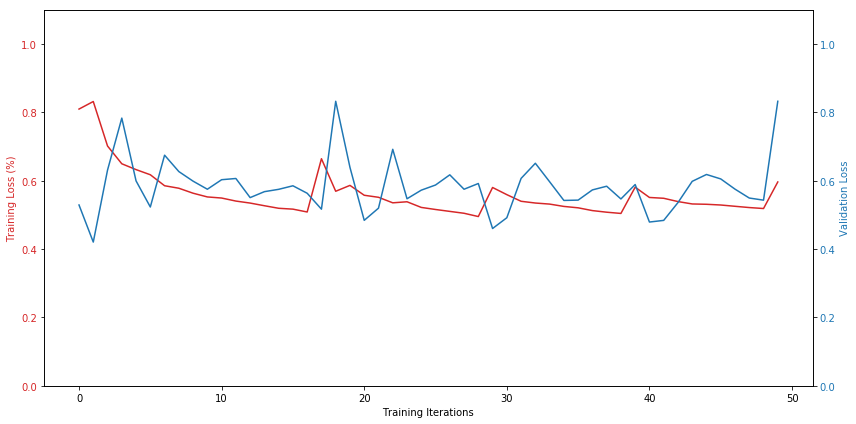

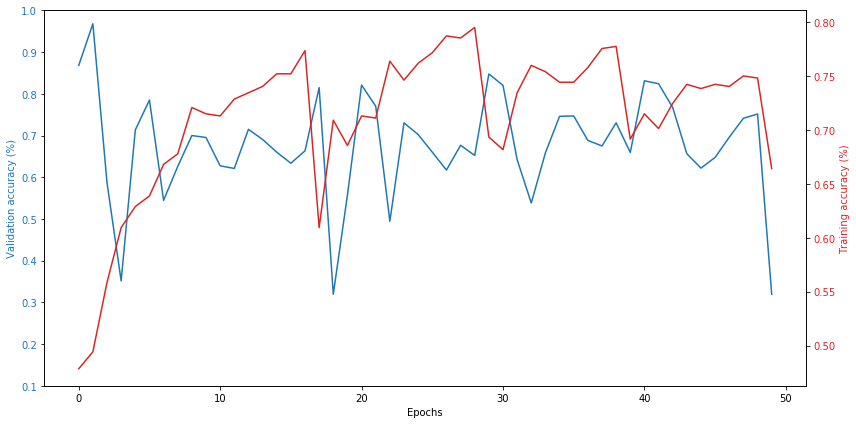

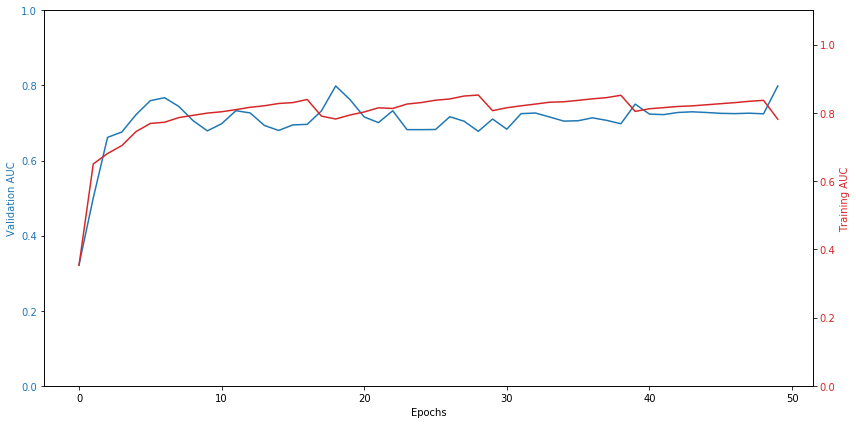

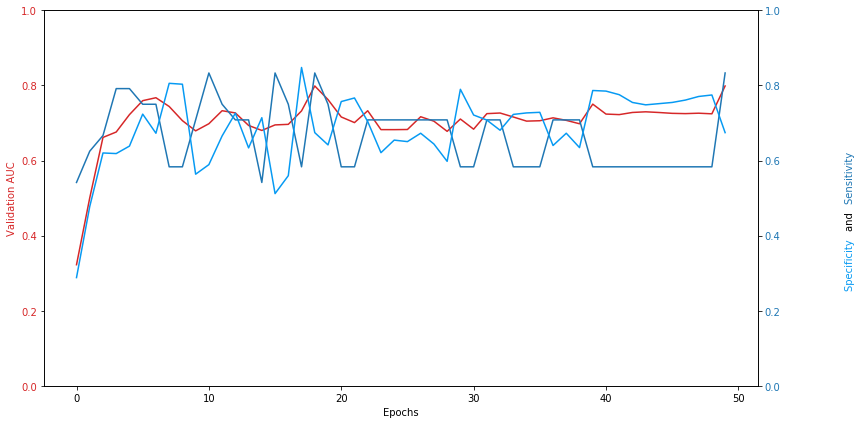


Fold  5
confused items in training set:  316
not_confused items in training set:  316
confused items in validation set:  24
not_confused items in validation set:  1260

Validation confused items:

['122a_V-SortTwoFactors-4-1.pkl', '122a_V-SortTwoFactors-4-2.pkl', '122a_V-SortTwoFactors-4-3.pkl', '122a_V-SortTwoFactors-4-4.pkl', '142a_V-CDV-15-1.pkl', '142a_V-CDV-15-2.pkl', '142a_V-CDV-15-3.pkl', '142a_V-CDV-15-4.pkl', '142b_H-CDV-22-1.pkl', '142b_H-CDV-22-2.pkl', '142b_H-CDV-22-3.pkl', '142b_H-CDV-22-4.pkl', '25a_H-RV-22-1.pkl', '25a_H-RV-22-2.pkl', '25a_H-RV-22-3.pkl', '25a_H-RV-22-4.pkl', '32a_V-SortTwoFactors-11-1.pkl', '32a_V-SortTwoFactors-11-2.pkl', '32a_V-SortTwoFactors-11-3.pkl', '32a_V-SortTwoFactors-11-4.pkl', '82a_V-SortTwoFactors-4-1.pkl', '82a_V-SortTwoFactors-4-2.pkl', '82a_V-SortTwoFactors-4-3.pkl', '82a_V-SortTwoFactors-4-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 632
    Root Location: ./dataset/augmented/train/
    Transforms (if any): N

[epoch: 21, batches:     2] loss: 0.50236 | accuracy: 0.77148
Training accuracy for epoch:  0.771484375
validation accuracy:  0.73515625
validation loss:  0.5150006651878357
validation recall:  0.4583333333333333
validation specificity:  0.7109872611464968
validation AUC:  0.5739450636942676
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.0015
New learning rate: 0.00075
Validation AUC:  0.6794055201698513
Validation Loss:  0.3920044779777527
Epochs without improvement:  20
[epoch: 22, batches:     2] loss: 0.69223 | accuracy: 0.55859
Training accuracy for epoch:  0.55859375
validation accuracy:  0.26484375
validation loss:  0.8191343545913696
validation recall:  0.4166666666666667
validation specificity:  0.7969745222929936
validation AUC:  0.5447186836518046
Epochs without improvement:  21
[epoch: 23, batches:     2] loss: 0.63241 | accuracy: 0.62500
Training accuracy for epoch:  0.625
validation accuracy:  0.4734375
validation loss:  0.7

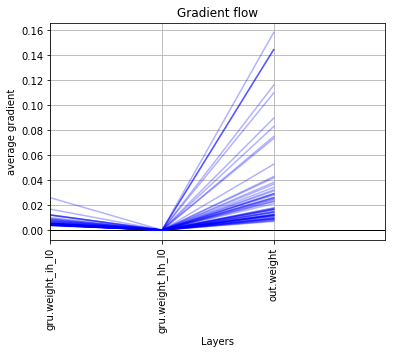

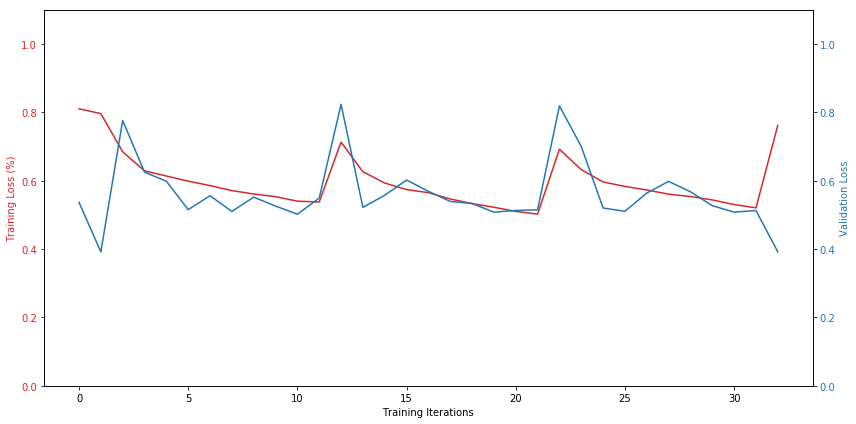

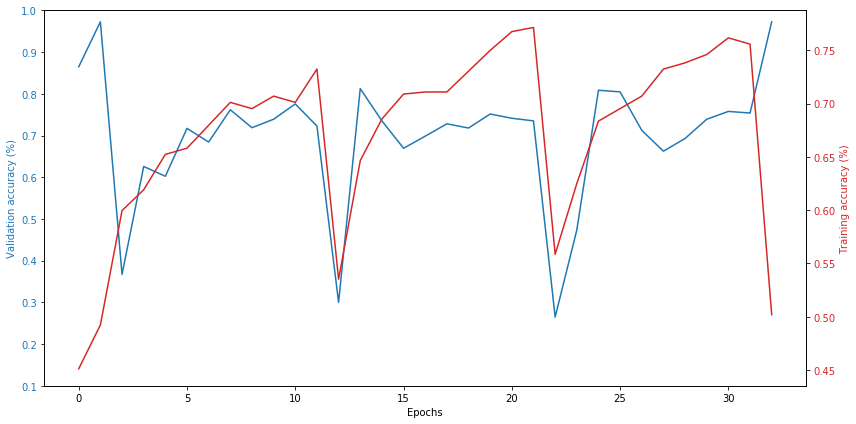

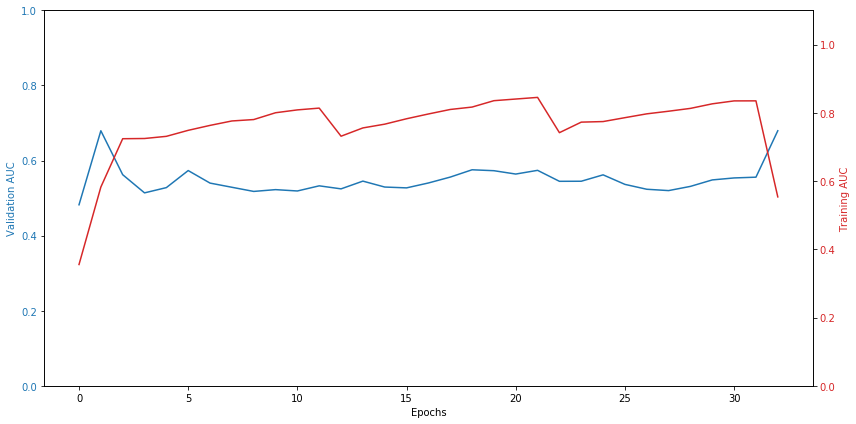

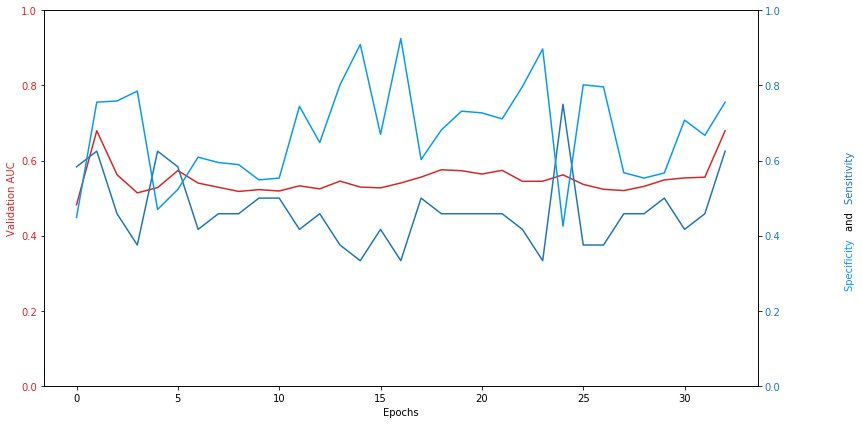


Fold  6
confused items in training set:  324
not_confused items in training set:  324
confused items in validation set:  16
not_confused items in validation set:  1272

Validation confused items:

['10a_V-CDV-2-1.pkl', '10a_V-CDV-2-2.pkl', '10a_V-CDV-2-3.pkl', '10a_V-CDV-2-4.pkl', '12b_H-CDV-5-1.pkl', '12b_H-CDV-5-2.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-4.pkl', '3a_H-SortTwoFactors-11-1.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '3a_H-SortTwoFactors-11-4.pkl', '9a_H-SortTwoFactors-12-1.pkl', '9a_H-SortTwoFactors-12-2.pkl', '9a_H-SortTwoFactors-12-3.pkl', '9a_H-SortTwoFactors-12-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 648
    Root Location: ./dataset/augmented/train/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 1288
    Root Location: ./dataset/augmented/val/
    Transforms (if any): None
    Target Transforms (if any): None
ConfusionGRU(

[epoch: 21, batches:     2] loss: 0.46320 | accuracy: 0.79297
Training accuracy for epoch:  0.79296875
validation accuracy:  0.76171875
validation loss:  0.5022220194339753
validation recall:  0.625
validation specificity:  0.944620253164557
validation AUC:  0.8050830696202531
Epochs without improvement:  5
[epoch: 22, batches:     2] loss: 0.45525 | accuracy: 0.80664
Training accuracy for epoch:  0.806640625
validation accuracy:  0.7171875
validation loss:  0.5341216325759888
validation recall:  0.875
validation specificity:  0.6740506329113924
validation AUC:  0.8363330696202532
Epochs without improvement:  6
[epoch: 23, batches:     2] loss: 0.44769 | accuracy: 0.78906
Training accuracy for epoch:  0.7890625
validation accuracy:  0.76640625
validation loss:  0.49158190488815307
validation recall:  0.6875
validation specificity:  0.7745253164556962
validation AUC:  0.8006329113924051
Epochs without improvement:  7
[epoch: 24, batches:     2] loss: 0.44346 | accuracy: 0.81836
Training

Training accuracy for epoch:  0.818359375
validation accuracy:  0.74765625
validation loss:  0.5055973112583161
validation recall:  0.875
validation specificity:  0.6558544303797469
validation AUC:  0.828668908227848
No decrease in validation loss in 30 epochs. Stopping training early.
Finished Training
validation accuracy:  0.75
validation loss:  0.5214507758617402
validation recall:  0.8125
validation specificity:  0.7412974683544303
validation AUC:  0.8567049050632912


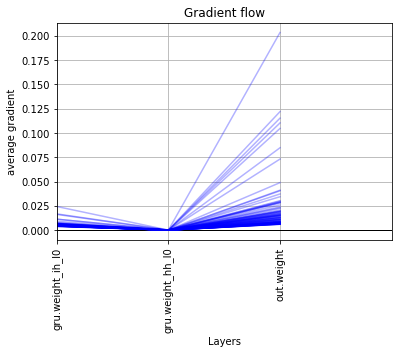

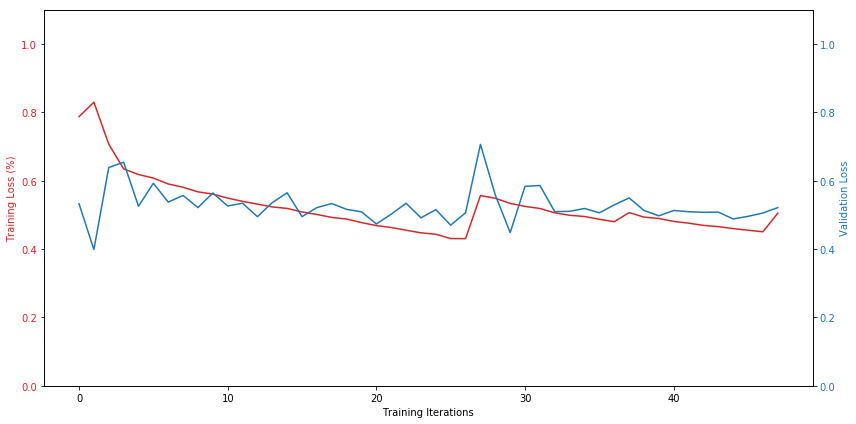

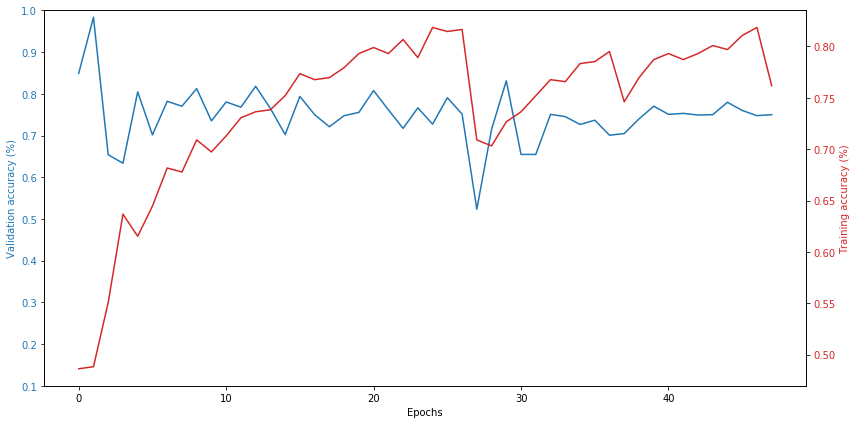

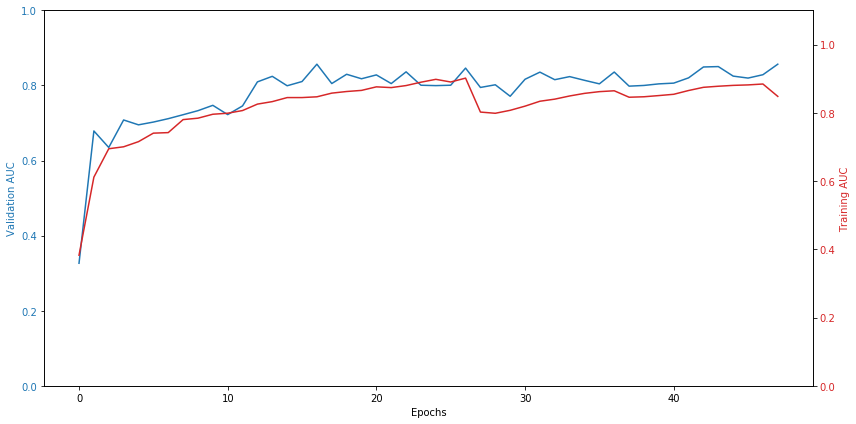

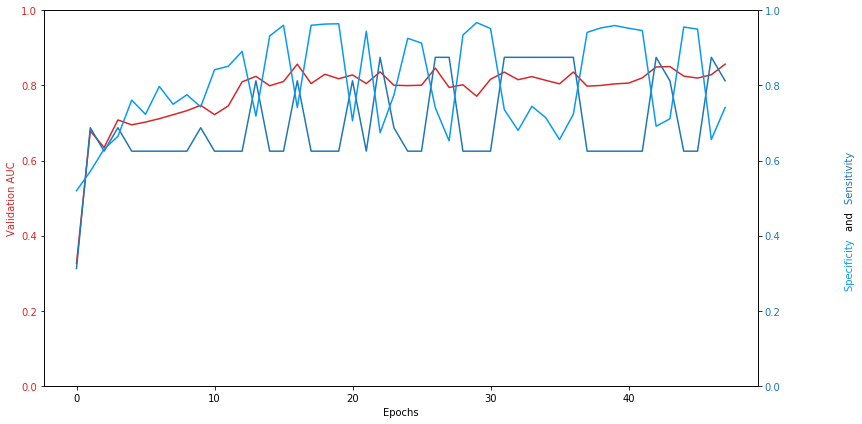


Fold  7
confused items in training set:  296
not_confused items in training set:  296
confused items in validation set:  44
not_confused items in validation set:  1240

Validation confused items:

['105a_H-FE-17-1.pkl', '105a_H-FE-17-2.pkl', '105a_H-FE-17-3.pkl', '105a_H-FE-17-4.pkl', '105a_H-RV-22-1.pkl', '105a_H-RV-22-2.pkl', '105a_H-RV-22-3.pkl', '105a_H-RV-22-4.pkl', '105a_H-RV-8-1.pkl', '105a_H-RV-8-2.pkl', '105a_H-RV-8-3.pkl', '105a_H-RV-8-4.pkl', '105b_V-FE-20-1.pkl', '105b_V-FE-20-2.pkl', '105b_V-FE-20-3.pkl', '105b_V-FE-20-4.pkl', '105b_V-FE-8-1.pkl', '105b_V-FE-8-2.pkl', '105b_V-FE-8-3.pkl', '105b_V-FE-8-4.pkl', '105b_V-RV-5-1.pkl', '105b_V-RV-5-2.pkl', '105b_V-RV-5-3.pkl', '105b_V-RV-5-4.pkl', '134b_H-CDV-15-1.pkl', '134b_H-CDV-15-2.pkl', '134b_H-CDV-15-3.pkl', '134b_H-CDV-15-4.pkl', '134b_H-CDV-4-1.pkl', '134b_H-CDV-4-2.pkl', '134b_H-CDV-4-3.pkl', '134b_H-CDV-4-4.pkl', '50a_V-SortTwoFactors-22-1.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '50a_V

Validation AUC:  0.6453920270667843
Validation Loss:  0.63192298412323
Epochs without improvement:  10
[epoch: 19, batches:     2] loss: 0.61112 | accuracy: 0.66406
Training accuracy for epoch:  0.6640625
validation accuracy:  0.746875
validation loss:  0.5780898094177246
validation recall:  0.6363636363636364
validation specificity:  0.669093851132686
validation AUC:  0.6308105325095617
Epochs without improvement:  11
[epoch: 20, batches:     2] loss: 0.56789 | accuracy: 0.69531
Training accuracy for epoch:  0.6953125
validation accuracy:  0.39765625
validation loss:  0.8557370901107788
validation recall:  0.75
validation specificity:  0.5436893203883495
validation AUC:  0.609149749926449
Epochs without improvement:  12
[epoch: 21, batches:     2] loss: 0.56309 | accuracy: 0.70508
Training accuracy for epoch:  0.705078125
validation accuracy:  0.67265625
validation loss:  0.6147545099258422
validation recall:  0.8181818181818182
validation specificity:  0.5355987055016181
validation A

Validation AUC:  0.6609664607237422
Validation Loss:  0.5007834434509277
Epochs without improvement:  20
[epoch: 43, batches:     2] loss: 0.53317 | accuracy: 0.72266
Training accuracy for epoch:  0.72265625
validation accuracy:  0.60390625
validation loss:  0.6537747740745544
validation recall:  0.7954545454545454
validation specificity:  0.5493527508090615
validation AUC:  0.6286407766990292
Epochs without improvement:  21
[epoch: 44, batches:     2] loss: 0.52224 | accuracy: 0.73242
Training accuracy for epoch:  0.732421875
validation accuracy:  0.57890625
validation loss:  0.6666279554367065
validation recall:  0.7954545454545454
validation specificity:  0.551779935275081
validation AUC:  0.6215614886731392
Epochs without improvement:  22
[epoch: 45, batches:     2] loss: 0.51734 | accuracy: 0.72852
Training accuracy for epoch:  0.728515625
validation accuracy:  0.66796875
validation loss:  0.604171884059906
validation recall:  0.7954545454545454
validation specificity:  0.56796116

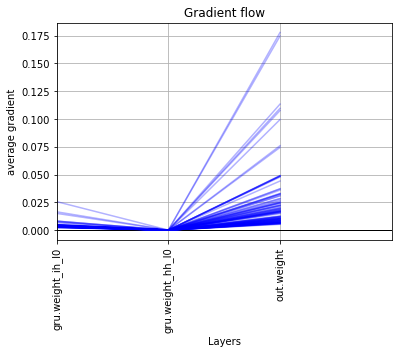

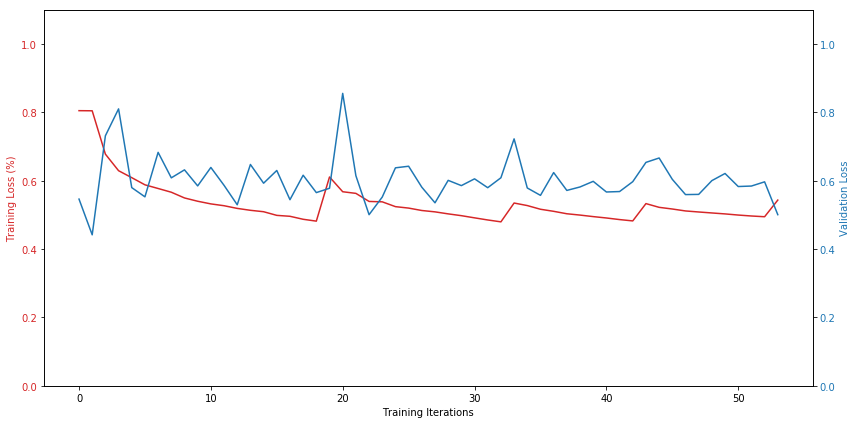

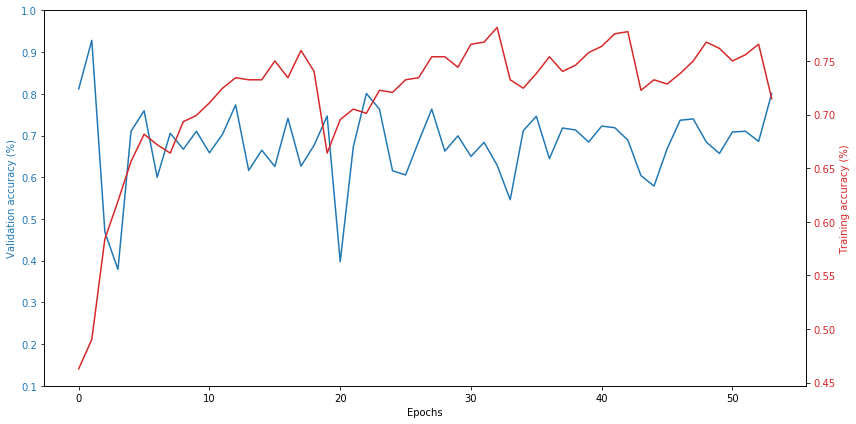

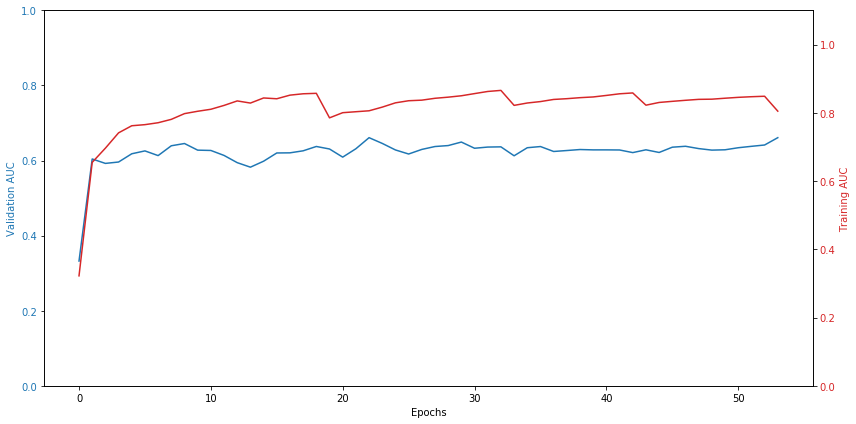

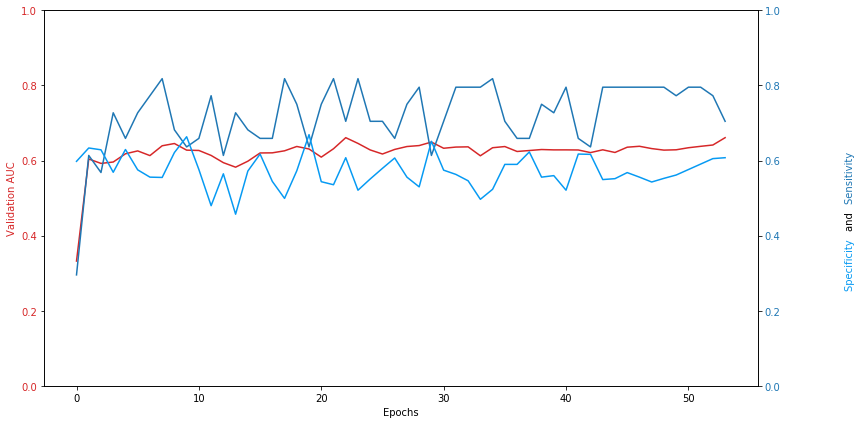


Fold  8
confused items in training set:  304
not_confused items in training set:  304
confused items in validation set:  36
not_confused items in validation set:  1248

Validation confused items:

['121a_H-CDV-9-1.pkl', '121a_H-CDV-9-2.pkl', '121a_H-CDV-9-3.pkl', '121a_H-CDV-9-4.pkl', '121a_H-SortTwoFactors-20-1.pkl', '121a_H-SortTwoFactors-20-2.pkl', '121a_H-SortTwoFactors-20-3.pkl', '121a_H-SortTwoFactors-20-4.pkl', '121b_V-FE-2-1.pkl', '121b_V-FE-2-2.pkl', '121b_V-FE-2-3.pkl', '121b_V-FE-2-4.pkl', '121b_V-SortTwoFactors-11-1.pkl', '121b_V-SortTwoFactors-11-2.pkl', '121b_V-SortTwoFactors-11-3.pkl', '121b_V-SortTwoFactors-11-4.pkl', '129b_V-SortTwoFactors-23-1.pkl', '129b_V-SortTwoFactors-23-2.pkl', '129b_V-SortTwoFactors-23-3.pkl', '129b_V-SortTwoFactors-23-4.pkl', '141a_H-RV-18-1.pkl', '141a_H-RV-18-2.pkl', '141a_H-RV-18-3.pkl', '141a_H-RV-18-4.pkl', '141a_H-SortTwoFactors-22-1.pkl', '141a_H-SortTwoFactors-22-2.pkl', '141a_H-SortTwoFactors-22-3.pkl', '141a_H-SortTwoFactors-22-4.pkl

[epoch: 19, batches:     2] loss: 0.52455 | accuracy: 0.73438
Training accuracy for epoch:  0.734375
validation accuracy:  0.665625
validation loss:  0.6259904146194458
validation recall:  0.6944444444444444
validation specificity:  0.4847266881028939
validation AUC:  0.5712977849231868
Epochs without improvement:  15
[epoch: 20, batches:     2] loss: 0.51193 | accuracy: 0.74023
Training accuracy for epoch:  0.740234375
validation accuracy:  0.55625
validation loss:  0.6878068685531616
validation recall:  0.6666666666666666
validation specificity:  0.5329581993569131
validation AUC:  0.5774160414433727
Epochs without improvement:  16
[epoch: 21, batches:     2] loss: 0.50582 | accuracy: 0.75586
Training accuracy for epoch:  0.755859375
validation accuracy:  0.57734375
validation loss:  0.6546863555908203
validation recall:  0.7222222222222222
validation specificity:  0.48231511254019294
validation AUC:  0.5726598785280457
Epochs without improvement:  17
[epoch: 22, batches:     2] loss

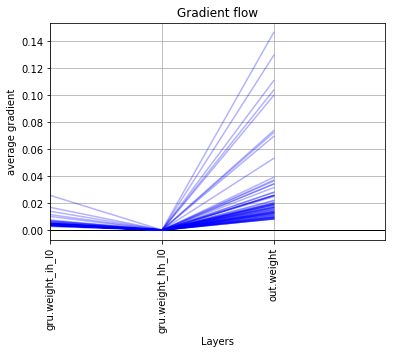

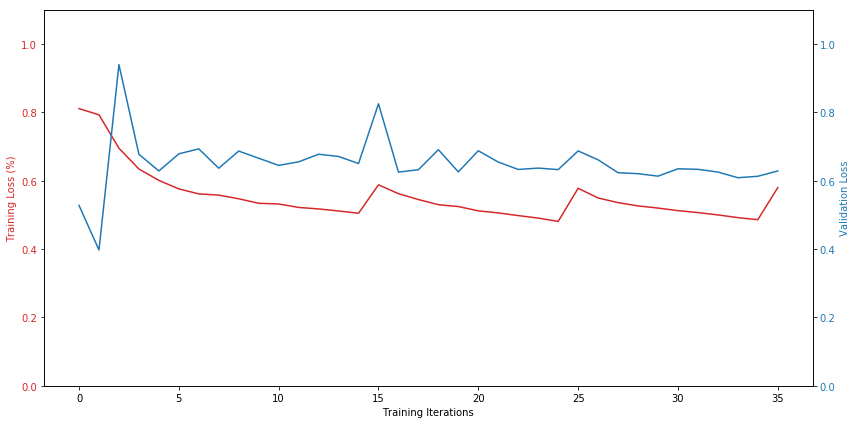

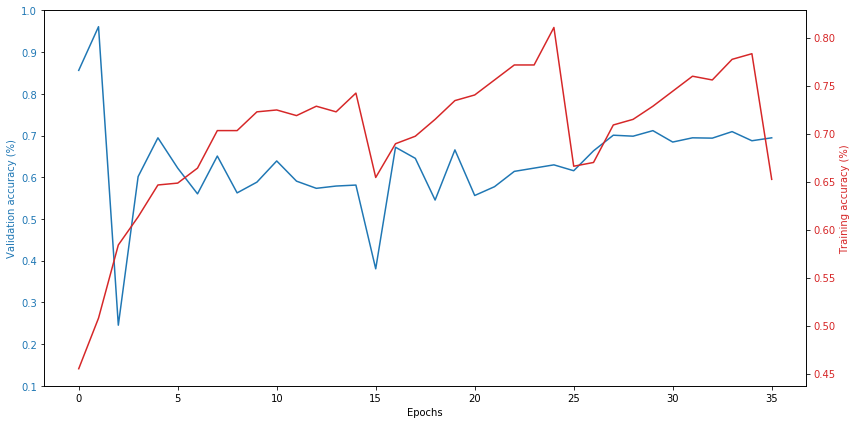

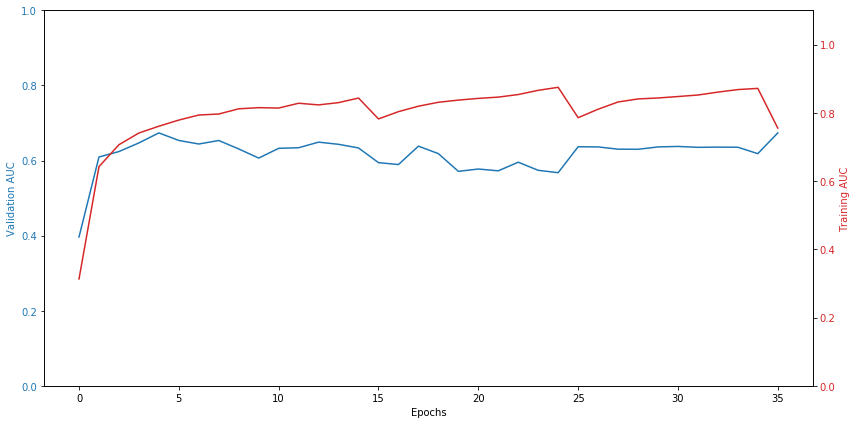

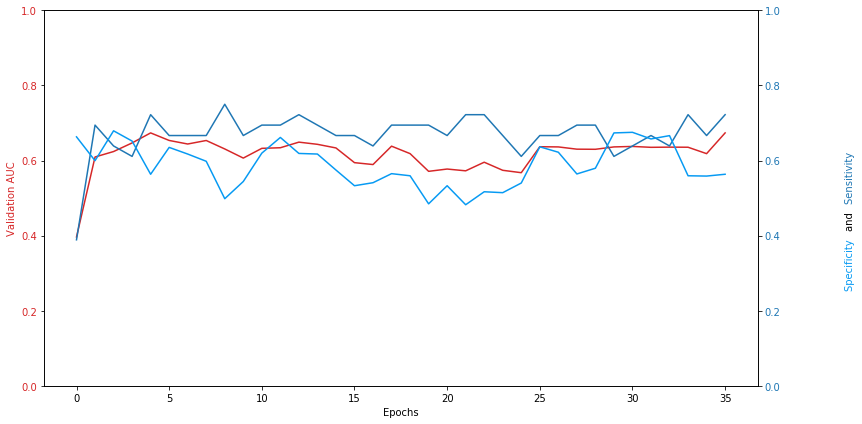


Fold  9
confused items in training set:  324
not_confused items in training set:  324
confused items in validation set:  16
not_confused items in validation set:  1268

Validation confused items:

['103a_H-CDV-12-1.pkl', '103a_H-CDV-12-2.pkl', '103a_H-CDV-12-3.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-4.pkl', '11a_H-SortTwoFactors-5-1.pkl', '11a_H-SortTwoFactors-5-2.pkl', '11a_H-SortTwoFactors-5-3.pkl', '11a_H-SortTwoFactors-5-4.pkl', '143a_H-CDV-17-1.pkl', '143a_H-CDV-17-2.pkl', '143a_H-CDV-17-3.pkl', '143a_H-CDV-17-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 648
    Root Location: ./dataset/augmented/train/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 1284
    Root Location: ./dataset/augmented/val/
    Transforms (if any): None
    Target Transforms (if any): None
ConfusionGRU(
  (gru): GRU(14, 25

Training accuracy for epoch:  0.734375
validation accuracy:  0.69609375
validation loss:  0.5575222849845887
validation recall:  0.375
validation specificity:  0.7737341772151899
validation AUC:  0.4891712816455696
Epochs without improvement:  15
[epoch: 22, batches:     2] loss: 0.53250 | accuracy: 0.72852
Training accuracy for epoch:  0.728515625
validation accuracy:  0.71015625
validation loss:  0.5401321411132812
validation recall:  0.375
validation specificity:  0.8006329113924051
validation AUC:  0.4940170094936709
Epochs without improvement:  16
[epoch: 23, batches:     2] loss: 0.52625 | accuracy: 0.73633
Training accuracy for epoch:  0.736328125
validation accuracy:  0.68203125
validation loss:  0.5594947874546051
validation recall:  0.375
validation specificity:  0.8496835443037974
validation AUC:  0.5024723101265822
Old best AUC:  0.495253164556962
New best SUC:  0.5024723101265822
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 24, batches:     2] l

[epoch: 45, batches:     2] loss: 0.39825 | accuracy: 0.82422
Training accuracy for epoch:  0.82421875
validation accuracy:  0.74453125
validation loss:  0.5383063971996307
validation recall:  0.375
validation specificity:  0.7072784810126582
validation AUC:  0.5291238132911393
Epochs without improvement:  1
[epoch: 46, batches:     2] loss: 0.39263 | accuracy: 0.82812
Training accuracy for epoch:  0.828125
validation accuracy:  0.790625
validation loss:  0.5069632411003113
validation recall:  0.3125
validation specificity:  0.9295886075949367
validation AUC:  0.5289754746835442
Epochs without improvement:  2
[epoch: 47, batches:     2] loss: 0.38617 | accuracy: 0.83008
Training accuracy for epoch:  0.830078125
validation accuracy:  0.78515625
validation loss:  0.5059368133544921
validation recall:  0.3125
validation specificity:  0.9256329113924051
validation AUC:  0.5318433544303798
Epochs without improvement:  3
[epoch: 48, batches:     2] loss: 0.37887 | accuracy: 0.83203
Training 

[epoch: 70, batches:     2] loss: 0.28538 | accuracy: 0.91797
Training accuracy for epoch:  0.91796875
validation accuracy:  0.76015625
validation loss:  0.5160695493221283
validation recall:  0.625
validation specificity:  0.5142405063291139
validation AUC:  0.613973496835443
Epochs without improvement:  9
[epoch: 71, batches:     2] loss: 0.28503 | accuracy: 0.91797
Training accuracy for epoch:  0.91796875
validation accuracy:  0.75390625
validation loss:  0.5231767117977142
validation recall:  0.625
validation specificity:  0.5514240506329114
validation AUC:  0.619412579113924
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.0015
New learning rate: 0.00075
Validation AUC:  0.620549841772152
Validation Loss:  0.41613146662712097
Epochs without improvement:  10
[epoch: 72, batches:     2] loss: 0.38177 | accuracy: 0.84570
Training accuracy for epoch:  0.845703125
validation accuracy:  0.71015625
validation loss:  0.5907465517520905
validat

[epoch: 95, batches:     2] loss: 0.31770 | accuracy: 0.88281
Training accuracy for epoch:  0.8828125
validation accuracy:  0.70234375
validation loss:  0.5942822515964508
validation recall:  0.5
validation specificity:  0.6170886075949367
validation AUC:  0.5849980221518988
Epochs without improvement:  22
[epoch: 96, batches:     2] loss: 0.31243 | accuracy: 0.89453
Training accuracy for epoch:  0.89453125
validation accuracy:  0.7609375
validation loss:  0.5282181918621063
validation recall:  0.6875
validation specificity:  0.46914556962025317
validation AUC:  0.5926621835443038
Epochs without improvement:  23
[epoch: 97, batches:     2] loss: 0.30717 | accuracy: 0.88477
Training accuracy for epoch:  0.884765625
validation accuracy:  0.79921875
validation loss:  0.47470020651817324
validation recall:  0.75
validation specificity:  0.46281645569620256
validation AUC:  0.6010185917721519
Epochs without improvement:  24
[epoch: 98, batches:     2] loss: 0.30521 | accuracy: 0.88672
Train

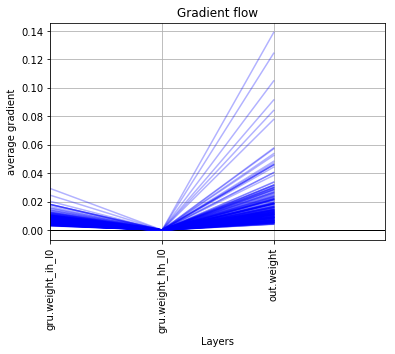

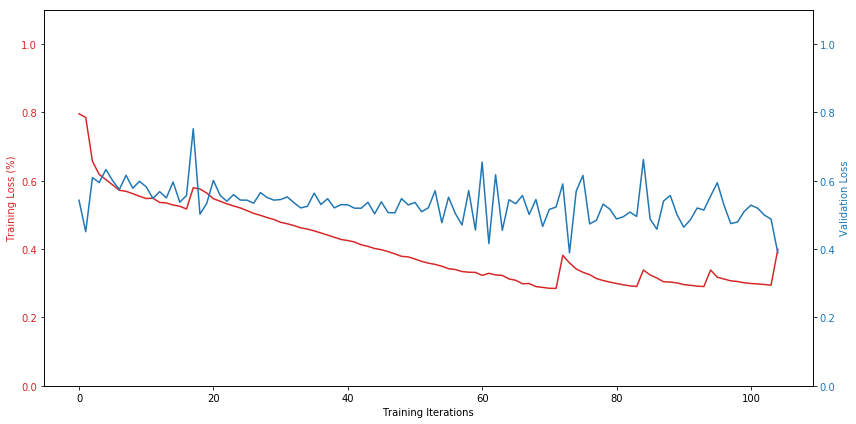

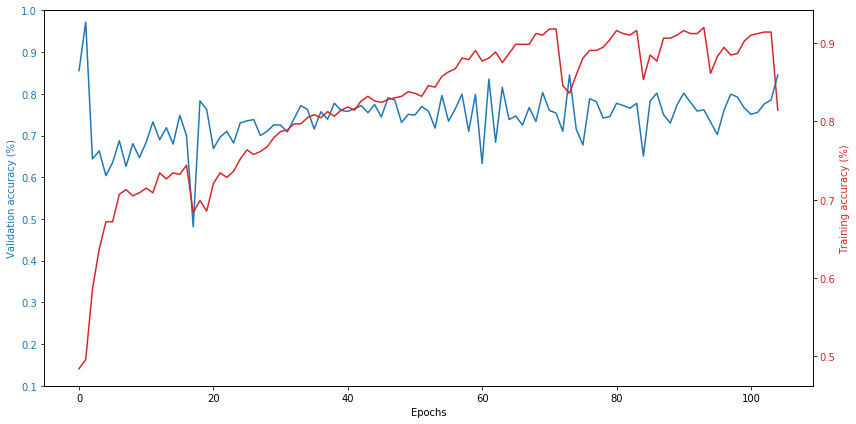

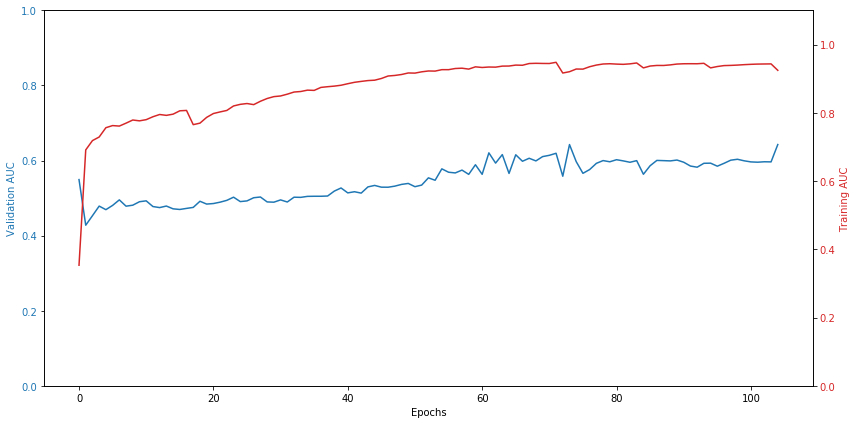

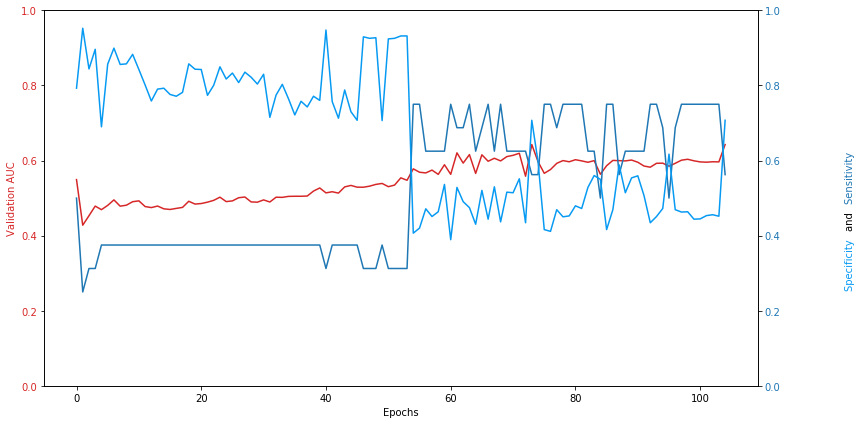


Fold  10
confused items in training set:  288
not_confused items in training set:  288
confused items in validation set:  52
not_confused items in validation set:  1228

Validation confused items:

['112a_V-SortTwoFactors-5-1.pkl', '112a_V-SortTwoFactors-5-2.pkl', '112a_V-SortTwoFactors-5-3.pkl', '112a_V-SortTwoFactors-5-4.pkl', '114a_V-SortTwoFactors-12-1.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '114a_V-SortTwoFactors-12-4.pkl', '130a_V-RV-10-1.pkl', '130a_V-RV-10-2.pkl', '130a_V-RV-10-3.pkl', '130a_V-RV-10-4.pkl', '35a_H-SortTwoFactors-15-1.pkl', '35a_H-SortTwoFactors-15-2.pkl', '35a_H-SortTwoFactors-15-3.pkl', '35a_H-SortTwoFactors-15-4.pkl', '35a_H-SortTwoFactors-22-1.pkl', '35a_H-SortTwoFactors-22-2.pkl', '35a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-22-4.pkl', '35a_H-SortTwoFactors-4-1.pkl', '35a_H-SortTwoFactors-4-2.pkl', '35a_H-SortTwoFactors-4-3.pkl', '35a_H-SortTwoFactors-4-4.pkl', '39a_H-SortTwoFactors-10-1.pkl', '39a_H-SortTwoFacto

Training accuracy for epoch:  0.771484375
validation accuracy:  0.7203125
validation loss:  0.5437110304832459
validation recall:  0.6923076923076923
validation specificity:  0.8167752442996743
validation AUC:  0.8381201453269858
Epochs without improvement:  8
[epoch: 18, batches:     2] loss: 0.50443 | accuracy: 0.79492
Training accuracy for epoch:  0.794921875
validation accuracy:  0.74765625
validation loss:  0.5228613495826722
validation recall:  0.7307692307692307
validation specificity:  0.8086319218241043
validation AUC:  0.847250062640942
Epochs without improvement:  9
[epoch: 19, batches:     2] loss: 0.49732 | accuracy: 0.77148
Training accuracy for epoch:  0.771484375
validation accuracy:  0.771875
validation loss:  0.5008160054683686
validation recall:  0.7115384615384616
validation specificity:  0.8452768729641694
validation AUC:  0.843507266349286
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015
V

Validation AUC:  0.8831120020045102
Validation Loss:  0.5993292927742004
Epochs without improvement:  10
[epoch: 42, batches:     2] loss: 0.54889 | accuracy: 0.75781
Training accuracy for epoch:  0.7578125
validation accuracy:  0.8375
validation loss:  0.4929441809654236
validation recall:  0.7692307692307693
validation specificity:  0.8452768729641694
validation AUC:  0.8732460536206464
Epochs without improvement:  11
[epoch: 43, batches:     2] loss: 0.53754 | accuracy: 0.78320
Training accuracy for epoch:  0.783203125
validation accuracy:  0.77109375
validation loss:  0.5202141463756561
validation recall:  0.75
validation specificity:  0.8819218241042345
validation AUC:  0.8713824855925832
Epochs without improvement:  12
[epoch: 44, batches:     2] loss: 0.53128 | accuracy: 0.76562
Training accuracy for epoch:  0.765625
validation accuracy:  0.73359375
validation loss:  0.5509387016296386
validation recall:  0.75
validation specificity:  0.8762214983713354
validation AUC:  0.872447

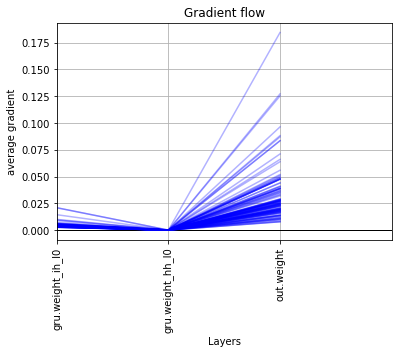

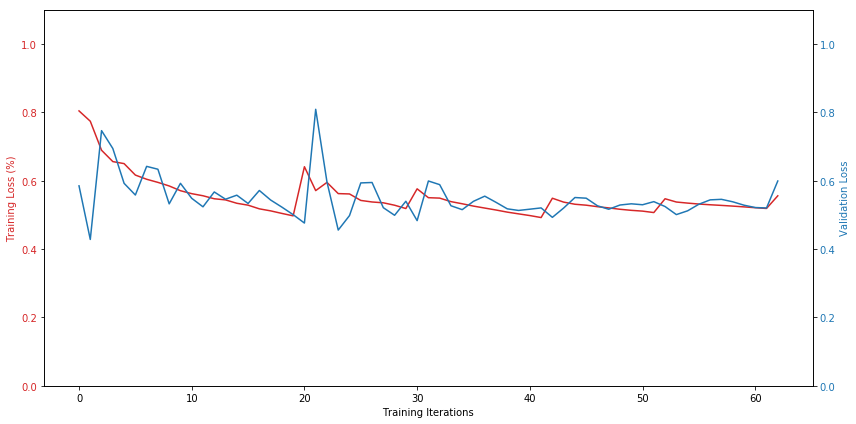

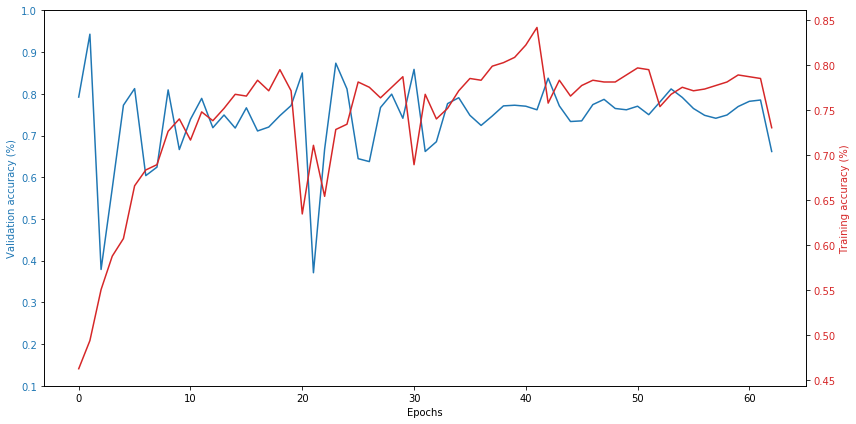

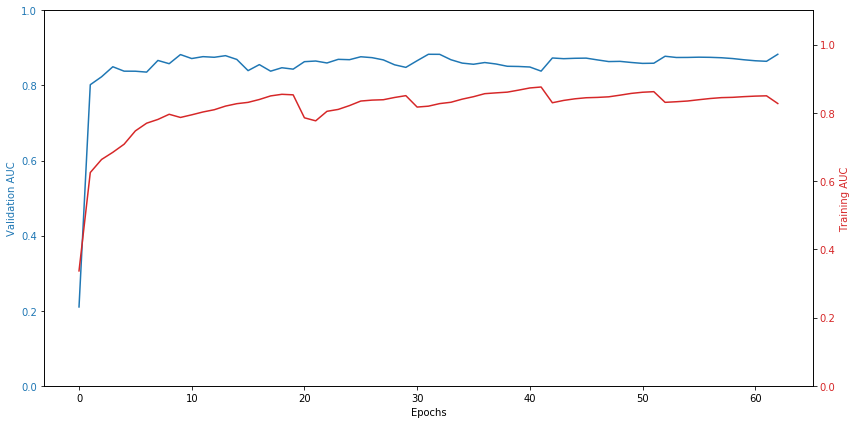

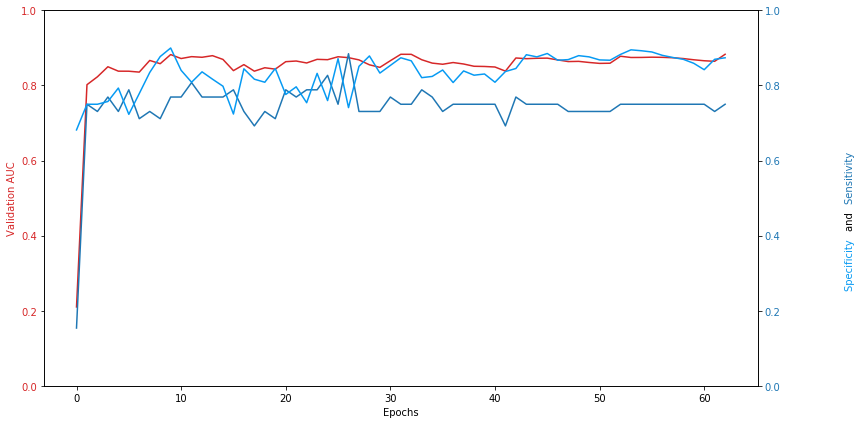


10-fold CV accuracy: 0.705234
10-fold CV sensitivity: 0.703510 
10-fold CV specificity: 0.698811 
10-fold CV AUC: 0.737837 


([0.7828125,
  0.63125,
  0.59375,
  0.31953125,
  0.97265625,
  0.75,
  0.80078125,
  0.69453125,
  0.8453125,
  0.66171875],
 [0.625,
  0.75,
  0.65,
  0.8333333333333334,
  0.625,
  0.8125,
  0.7045454545454546,
  0.7222222222222222,
  0.5625,
  0.75],
 [0.7066993464052288,
  0.6330128205128205,
  0.725,
  0.6743630573248408,
  0.7555732484076433,
  0.7412974683544303,
  0.6076051779935275,
  0.5635048231511254,
  0.7072784810126582,
  0.8737785016286646],
 [0.7180059523809524,
  0.7040514823717949,
  0.7610887096774194,
  0.7986995753715498,
  0.6794055201698513,
  0.8567049050632912,
  0.6609664607237422,
  0.673678099321186,
  0.6426522943037974,
  0.8831120020045102])

In [11]:
np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

cross_validate(model_type='gru',
                   folds=10,
                   epochs=300,
                   criterion_type='NLLLoss',
                   optimizer_type='Adam',
                   confused_path='./dataset/augmented/confused_highly_valid/',
                   not_confused_path='./dataset/augmented/not_confused_highly_valid/',
                   print_every=2,
                   plot_every=2,
                   hidden_size=256,
                   num_layers=1,
                   early_stopping=True,
                   early_stopping_patience=30,
                   rate_decay=True,
                   rate_decay_patience=10,
                   initial_learning_rate=0.003,
                   verbose=True)

#previous
# 10-fold CV accuracy: 0.629844
# 10-fold CV sensitivity: 0.705208 
# 10-fold CV specificity: 0.697121 
# 10-fold CV AUC: 0.726446 

## RNN CV:


Fold  1
confused items in training set:  284
not_confused items in training set:  284
confused items in validation set:  56
not_confused items in validation set:  1228

Validation confused items:

['131a_H-CDV-5-1.pkl', '131a_H-CDV-5-2.pkl', '131a_H-CDV-5-3.pkl', '131a_H-CDV-5-4.pkl', '131a_H-SortTwoFactors-12-1.pkl', '131a_H-SortTwoFactors-12-2.pkl', '131a_H-SortTwoFactors-12-3.pkl', '131a_H-SortTwoFactors-12-4.pkl', '131b_V-SortTwoFactors-21-1.pkl', '131b_V-SortTwoFactors-21-2.pkl', '131b_V-SortTwoFactors-21-3.pkl', '131b_V-SortTwoFactors-21-4.pkl', '132a_V-CDV-2-1.pkl', '132a_V-CDV-2-2.pkl', '132a_V-CDV-2-3.pkl', '132a_V-CDV-2-4.pkl', '132a_V-SortOverall-21-1.pkl', '132a_V-SortOverall-21-2.pkl', '132a_V-SortOverall-21-3.pkl', '132a_V-SortOverall-21-4.pkl', '132a_V-SortOverall-9-1.pkl', '132a_V-SortOverall-9-2.pkl', '132a_V-SortOverall-9-3.pkl', '132a_V-SortOverall-9-4.pkl', '132a_V-SortTwoFactors-6-1.pkl', '132a_V-SortTwoFactors-6-2.pkl', '132a_V-SortTwoFactors-6-3.pkl', '132a_V-So

[epoch: 18, batches:     2] loss: 0.57066 | accuracy: 0.70703
Training accuracy for epoch:  0.70703125
validation accuracy:  0.753125
validation loss:  0.555675494670868
validation recall:  0.5178571428571429
validation specificity:  0.5277777777777778
validation AUC:  0.5283759337068161
Epochs without improvement:  2
[epoch: 19, batches:     2] loss: 0.56820 | accuracy: 0.70508
Training accuracy for epoch:  0.705078125
validation accuracy:  0.75390625
validation loss:  0.5511552274227143
validation recall:  0.7142857142857143
validation specificity:  0.4297385620915033
validation AUC:  0.550952672735761
Epochs without improvement:  3
[epoch: 20, batches:     2] loss: 0.56620 | accuracy: 0.71094
Training accuracy for epoch:  0.7109375
validation accuracy:  0.72890625
validation loss:  0.5974414944648743
validation recall:  0.6428571428571429
validation specificity:  0.5212418300653595
validation AUC:  0.5691599556489262
Epochs without improvement:  4
[epoch: 21, batches:     2] loss: 0

[epoch: 43, batches:     2] loss: 0.53014 | accuracy: 0.73828
Training accuracy for epoch:  0.73828125
validation accuracy:  0.74921875
validation loss:  0.580955958366394
validation recall:  0.6071428571428571
validation specificity:  0.5915032679738562
validation AUC:  0.6103670634920635
Epochs without improvement:  5
[epoch: 44, batches:     2] loss: 0.52784 | accuracy: 0.73438
Training accuracy for epoch:  0.734375
validation accuracy:  0.77421875
validation loss:  0.5374802947044373
validation recall:  0.8035714285714286
validation specificity:  0.4918300653594771
validation AUC:  0.6198135504201682
Epochs without improvement:  6
[epoch: 45, batches:     2] loss: 0.52395 | accuracy: 0.74219
Training accuracy for epoch:  0.7421875
validation accuracy:  0.7859375
validation loss:  0.5100078344345093
validation recall:  0.75
validation specificity:  0.4738562091503268
validation AUC:  0.5888480392156864
Epochs without improvement:  7
[epoch: 46, batches:     2] loss: 0.52653 | accura

[epoch: 68, batches:     2] loss: 0.52394 | accuracy: 0.73438
Training accuracy for epoch:  0.734375
validation accuracy:  0.77734375
validation loss:  0.5171134173870087
validation recall:  0.6607142857142857
validation specificity:  0.440359477124183
validation AUC:  0.5721653244631186
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.0015
New learning rate: 0.00075
Validation AUC:  0.6319590336134454
Validation Loss:  0.511086905002594
Epochs without improvement:  20
[epoch: 69, batches:     2] loss: 0.53405 | accuracy: 0.73828
Training accuracy for epoch:  0.73828125
validation accuracy:  0.80234375
validation loss:  0.548280680179596
validation recall:  0.6428571428571429
validation specificity:  0.5449346405228758
validation AUC:  0.6076170051353874
Epochs without improvement:  21
[epoch: 70, batches:     2] loss: 0.52440 | accuracy: 0.74414
Training accuracy for epoch:  0.744140625
validation accuracy:  0.790625
validation loss:  0.48

[epoch: 92, batches:     2] loss: 0.48728 | accuracy: 0.75391
Training accuracy for epoch:  0.75390625
validation accuracy:  0.78125
validation loss:  0.5210030019283295
validation recall:  0.7857142857142857
validation specificity:  0.5
validation AUC:  0.6435574229691876
Old best AUC:  0.6428352591036415
New best SUC:  0.6435574229691876
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 93, batches:     2] loss: 0.48645 | accuracy: 0.75586
Training accuracy for epoch:  0.755859375
validation accuracy:  0.78046875
validation loss:  0.5228755176067352
validation recall:  0.8035714285714286
validation specificity:  0.49754901960784315
validation AUC:  0.6450017507002801
Old best AUC:  0.6435574229691876
New best SUC:  0.6450017507002801
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 94, batches:     2] loss: 0.48551 | accuracy: 0.75586
Training accuracy for epoch:  0.755859375
validation accuracy:  0.78046875
validation loss:  0.521126323

[epoch: 114, batches:     2] loss: 0.47143 | accuracy: 0.76758
Training accuracy for epoch:  0.767578125
validation accuracy:  0.8109375
validation loss:  0.5170748710632325
validation recall:  0.7678571428571429
validation specificity:  0.5253267973856209
validation AUC:  0.6532883986928104
Old best AUC:  0.6522525676937442
New best SUC:  0.6532883986928104
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 115, batches:     2] loss: 0.47079 | accuracy: 0.76953
Training accuracy for epoch:  0.76953125
validation accuracy:  0.81171875
validation loss:  0.51308553814888
validation recall:  0.8392857142857143
validation specificity:  0.4820261437908497
validation AUC:  0.6507936507936507
Epochs without improvement:  1
[epoch: 116, batches:     2] loss: 0.47035 | accuracy: 0.76758
Training accuracy for epoch:  0.767578125
validation accuracy:  0.80859375
validation loss:  0.519746720790863
validation recall:  0.7678571428571429
validation specificity:  0.529411764705

[epoch: 138, batches:     2] loss: 0.46997 | accuracy: 0.76562
Training accuracy for epoch:  0.765625
validation accuracy:  0.77421875
validation loss:  0.5240805149078369
validation recall:  0.8035714285714286
validation specificity:  0.5155228758169934
validation AUC:  0.6524276377217554
Epochs without improvement:  4
[epoch: 139, batches:     2] loss: 0.46892 | accuracy: 0.76367
Training accuracy for epoch:  0.763671875
validation accuracy:  0.8015625
validation loss:  0.5156087279319763
validation recall:  0.8035714285714286
validation specificity:  0.4861111111111111
validation AUC:  0.6419672035480859
Epochs without improvement:  5
[epoch: 140, batches:     2] loss: 0.46763 | accuracy: 0.76758
Training accuracy for epoch:  0.767578125
validation accuracy:  0.803125
validation loss:  0.524954640865326
validation recall:  0.8035714285714286
validation specificity:  0.49264705882352944
validation AUC:  0.6434552987861811
Epochs without improvement:  6
[epoch: 141, batches:     2] lo

[epoch: 162, batches:     2] loss: 0.46398 | accuracy: 0.76758
Training accuracy for epoch:  0.767578125
validation accuracy:  0.8078125
validation loss:  0.5190786182880401
validation recall:  0.7857142857142857
validation specificity:  0.5138888888888888
validation AUC:  0.6571253501400561
Epochs without improvement:  15
[epoch: 163, batches:     2] loss: 0.46363 | accuracy: 0.76953
Training accuracy for epoch:  0.76953125
validation accuracy:  0.80859375
validation loss:  0.5169970154762268
validation recall:  0.7678571428571429
validation specificity:  0.5261437908496732
validation AUC:  0.6569794584500467
Epochs without improvement:  16
[epoch: 164, batches:     2] loss: 0.46347 | accuracy: 0.77148
Training accuracy for epoch:  0.771484375
validation accuracy:  0.8078125
validation loss:  0.5163949966430664
validation recall:  0.7678571428571429
validation specificity:  0.5326797385620915
validation AUC:  0.6549077964519141
Epochs without improvement:  17
[epoch: 165, batches:    

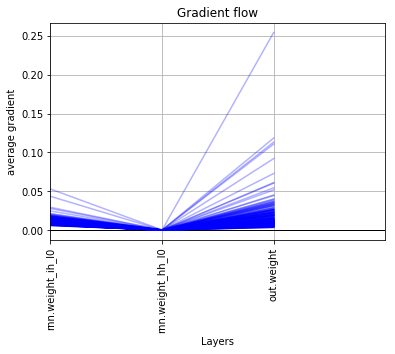

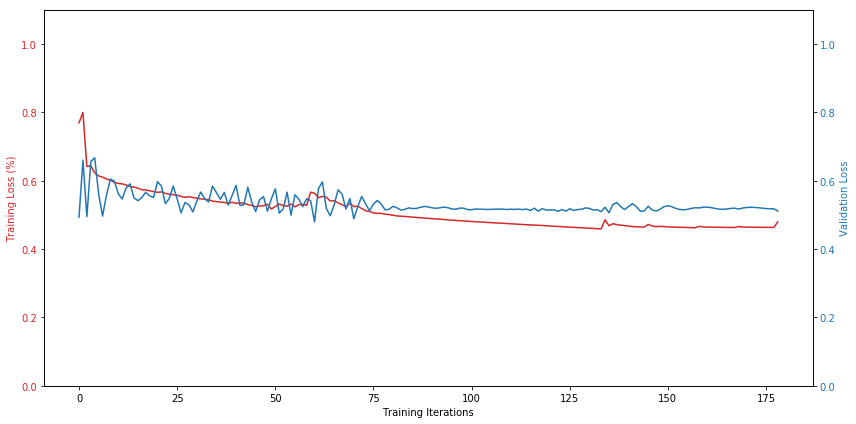

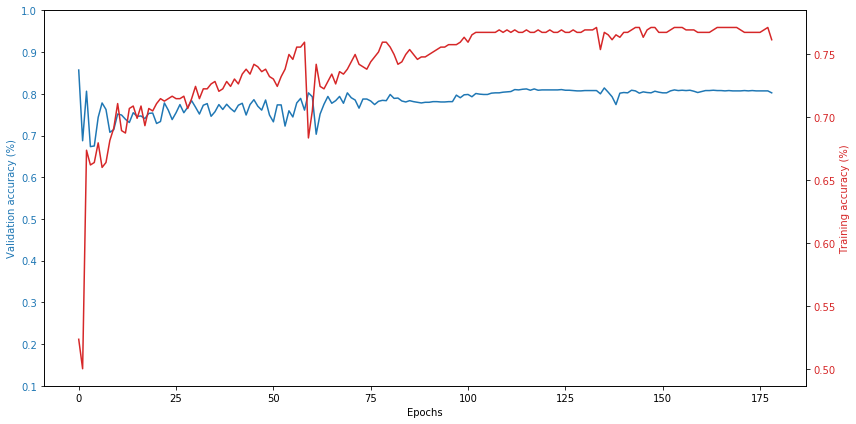

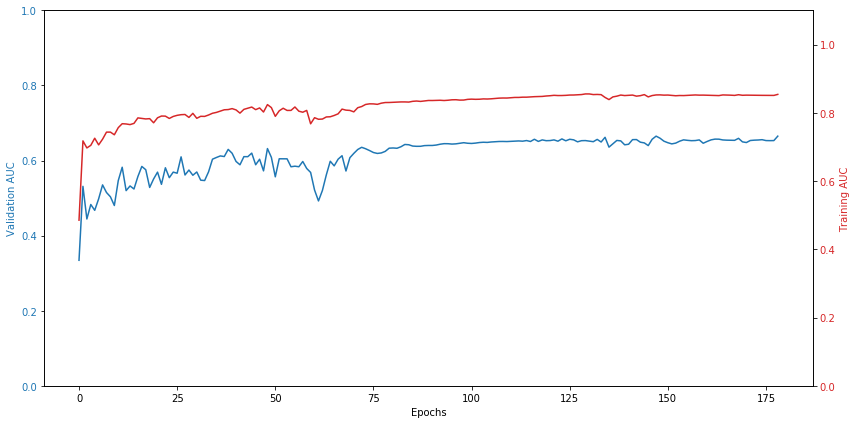

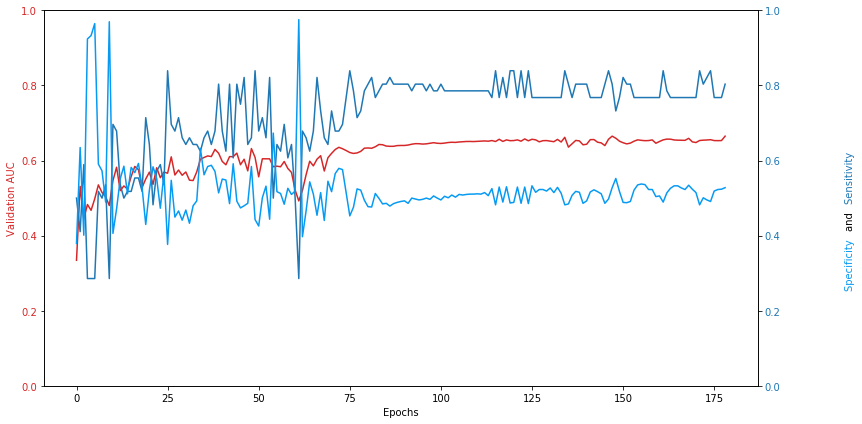


Fold  2
confused items in training set:  308
not_confused items in training set:  308
confused items in validation set:  32
not_confused items in validation set:  1252

Validation confused items:

['126a_V-SortTwoFactors-6-1.pkl', '126a_V-SortTwoFactors-6-2.pkl', '126a_V-SortTwoFactors-6-3.pkl', '126a_V-SortTwoFactors-6-4.pkl', '133a_H-CDV-16-1.pkl', '133a_H-CDV-16-2.pkl', '133a_H-CDV-16-3.pkl', '133a_H-CDV-16-4.pkl', '1b_V-CDV-17-1.pkl', '1b_V-CDV-17-2.pkl', '1b_V-CDV-17-3.pkl', '1b_V-CDV-17-4.pkl', '36a_V-SortTwoFactors-2-1.pkl', '36a_V-SortTwoFactors-2-2.pkl', '36a_V-SortTwoFactors-2-3.pkl', '36a_V-SortTwoFactors-2-4.pkl', '48a_V-SortTwoFactors-12-1.pkl', '48a_V-SortTwoFactors-12-2.pkl', '48a_V-SortTwoFactors-12-3.pkl', '48a_V-SortTwoFactors-12-4.pkl', '63a_H-SortTwoFactors-5-1.pkl', '63a_H-SortTwoFactors-5-2.pkl', '63a_H-SortTwoFactors-5-3.pkl', '63a_H-SortTwoFactors-5-4.pkl', '8a_V-SortTwoFactors-10-1.pkl', '8a_V-SortTwoFactors-10-2.pkl', '8a_V-SortTwoFactors-10-3.pkl', '8a_V-Sor

[epoch: 20, batches:     2] loss: 0.59595 | accuracy: 0.67188
Training accuracy for epoch:  0.671875
validation accuracy:  0.74140625
validation loss:  0.6501712322235107
validation recall:  0.59375
validation specificity:  0.7716346153846154
validation AUC:  0.6679937900641025
Epochs without improvement:  16
[epoch: 21, batches:     2] loss: 0.59097 | accuracy: 0.67773
Training accuracy for epoch:  0.677734375
validation accuracy:  0.784375
validation loss:  0.6105780363082886
validation recall:  0.71875
validation specificity:  0.6266025641025641
validation AUC:  0.6483874198717948
Epochs without improvement:  17
[epoch: 22, batches:     2] loss: 0.58676 | accuracy: 0.66406
Training accuracy for epoch:  0.6640625
validation accuracy:  0.7703125
validation loss:  0.6168423533439636
validation recall:  0.6875
validation specificity:  0.592948717948718
validation AUC:  0.6290564903846153
Epochs without improvement:  18
[epoch: 23, batches:     2] loss: 0.58189 | accuracy: 0.66602
Traini

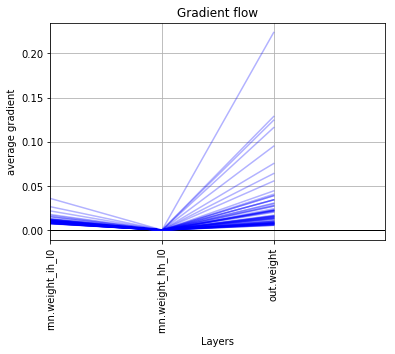

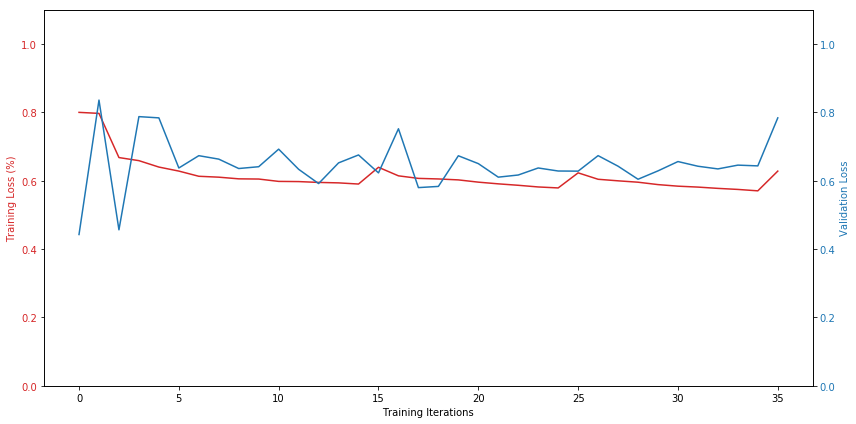

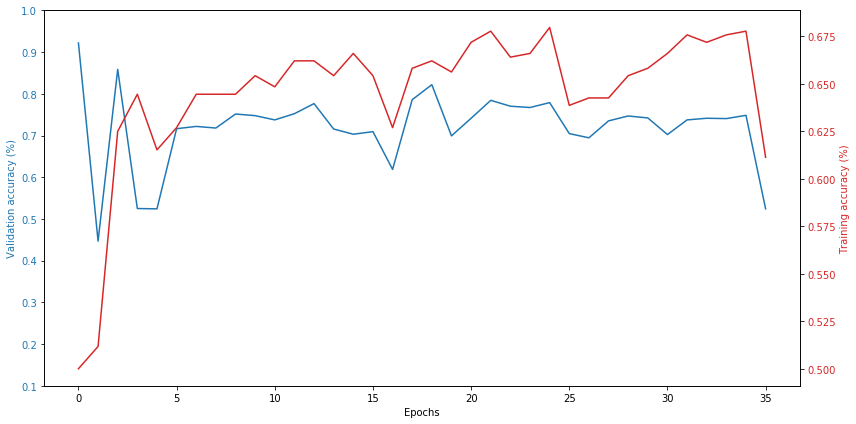

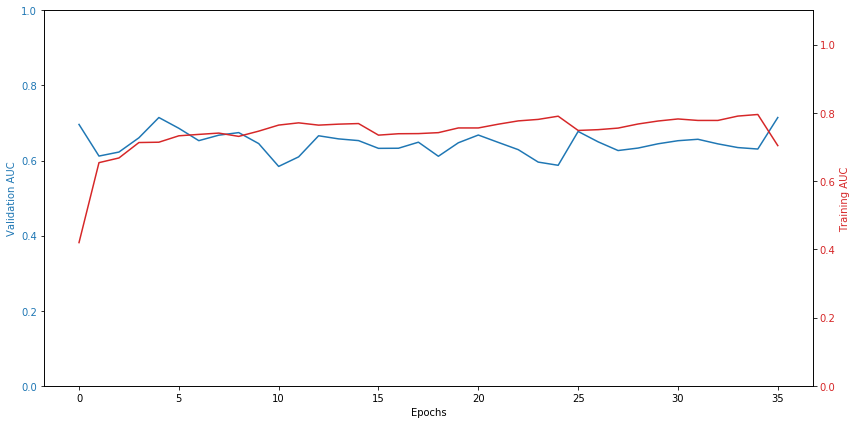

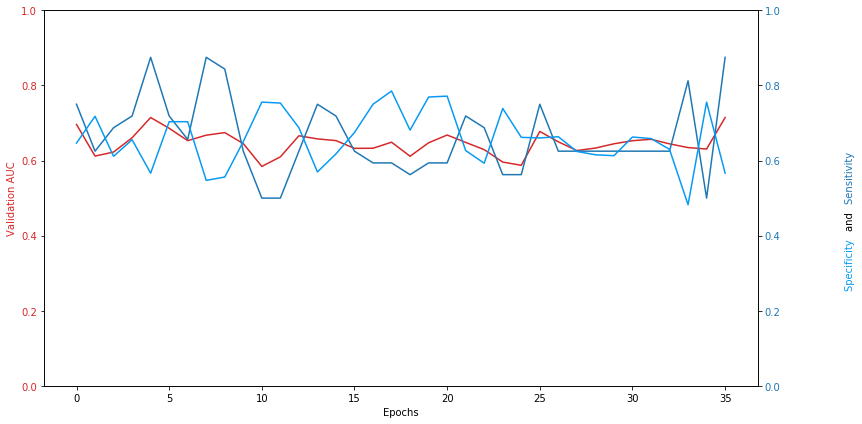


Fold  3
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  40
not_confused items in validation set:  1244

Validation confused items:

['111a_H-SortTwoFactors-3-1.pkl', '111a_H-SortTwoFactors-3-2.pkl', '111a_H-SortTwoFactors-3-3.pkl', '111a_H-SortTwoFactors-3-4.pkl', '137a_H-FE-4-1.pkl', '137a_H-FE-4-2.pkl', '137a_H-FE-4-3.pkl', '137a_H-FE-4-4.pkl', '137a_H-SortTwoFactors-2-1.pkl', '137a_H-SortTwoFactors-2-2.pkl', '137a_H-SortTwoFactors-2-3.pkl', '137a_H-SortTwoFactors-2-4.pkl', '137b_V-FE-20-1.pkl', '137b_V-FE-20-2.pkl', '137b_V-FE-20-3.pkl', '137b_V-FE-20-4.pkl', '145b_V-SortTwoFactors-10-1.pkl', '145b_V-SortTwoFactors-10-2.pkl', '145b_V-SortTwoFactors-10-3.pkl', '145b_V-SortTwoFactors-10-4.pkl', '145b_V-SortTwoFactors-24-1.pkl', '145b_V-SortTwoFactors-24-2.pkl', '145b_V-SortTwoFactors-24-3.pkl', '145b_V-SortTwoFactors-24-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-2.pkl', '14a_V-SortTwoFactors-3-3.pkl

[epoch: 20, batches:     2] loss: 0.58388 | accuracy: 0.66797
Training accuracy for epoch:  0.66796875
validation accuracy:  0.703125
validation loss:  0.6113282680511475
validation recall:  0.475
validation specificity:  0.7870967741935484
validation AUC:  0.5800403225806452
Epochs without improvement:  18
[epoch: 21, batches:     2] loss: 0.57549 | accuracy: 0.67188
Training accuracy for epoch:  0.671875
validation accuracy:  0.64609375
validation loss:  0.6633795499801636
validation recall:  0.55
validation specificity:  0.6411290322580645
validation AUC:  0.574274193548387
Epochs without improvement:  19
[epoch: 22, batches:     2] loss: 0.57363 | accuracy: 0.67383
Training accuracy for epoch:  0.673828125
validation accuracy:  0.68359375
validation loss:  0.6220526576042176
validation recall:  0.45
validation specificity:  0.8016129032258065
validation AUC:  0.5808064516129032
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.0015
New l

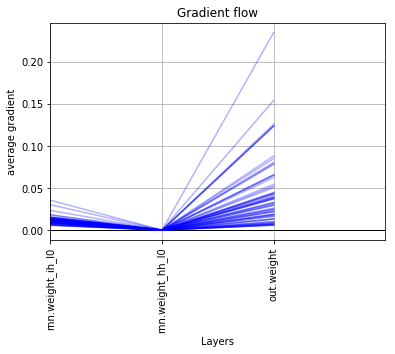

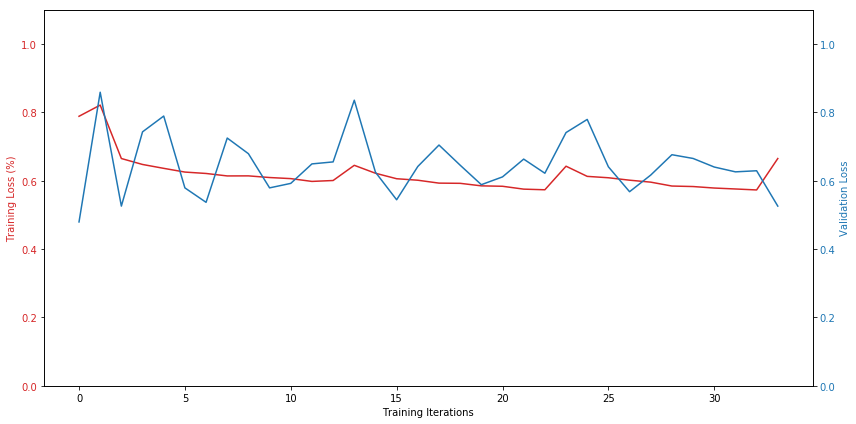

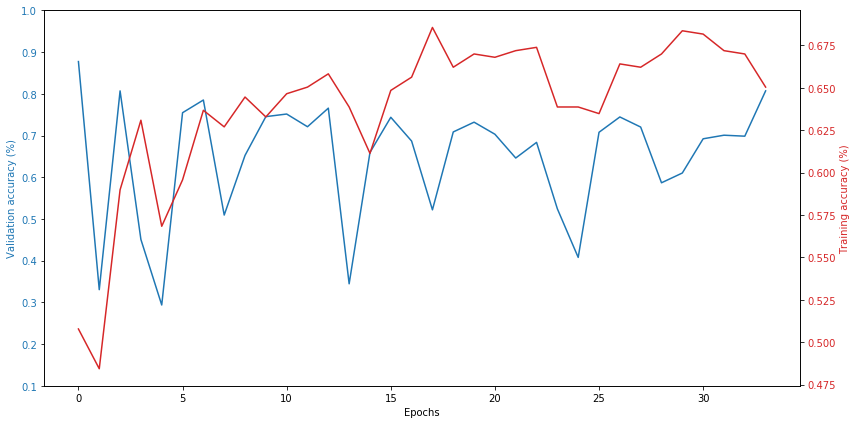

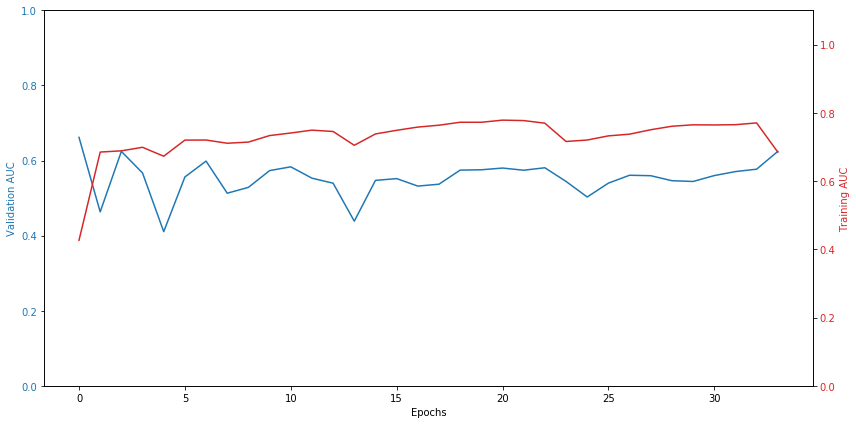

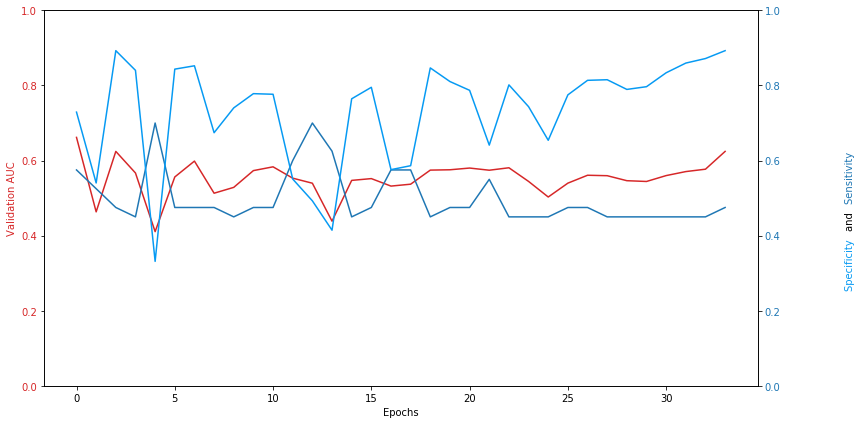


Fold  4
confused items in training set:  316
not_confused items in training set:  316
confused items in validation set:  24
not_confused items in validation set:  1260

Validation confused items:

['58a_V-SortTwoFactors-14-1.pkl', '58a_V-SortTwoFactors-14-2.pkl', '58a_V-SortTwoFactors-14-3.pkl', '58a_V-SortTwoFactors-14-4.pkl', '58a_V-SortTwoFactors-23-1.pkl', '58a_V-SortTwoFactors-23-2.pkl', '58a_V-SortTwoFactors-23-3.pkl', '58a_V-SortTwoFactors-23-4.pkl', '58a_V-SortTwoFactors-6-1.pkl', '58a_V-SortTwoFactors-6-2.pkl', '58a_V-SortTwoFactors-6-3.pkl', '58a_V-SortTwoFactors-6-4.pkl', '86a_V-FE-10-1.pkl', '86a_V-FE-10-2.pkl', '86a_V-FE-10-3.pkl', '86a_V-FE-10-4.pkl', '86a_V-SortTwoFactors-4-1.pkl', '86a_V-SortTwoFactors-4-2.pkl', '86a_V-SortTwoFactors-4-3.pkl', '86a_V-SortTwoFactors-4-4.pkl', '86b_H-CDV-6-1.pkl', '86b_H-CDV-6-2.pkl', '86b_H-CDV-6-3.pkl', '86b_H-CDV-6-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 632
    Root Location: ./dataset/augmented/train

[epoch: 21, batches:     2] loss: 0.60365 | accuracy: 0.64844
Training accuracy for epoch:  0.6484375
validation accuracy:  0.77265625
validation loss:  0.621647834777832
validation recall:  0.5833333333333334
validation specificity:  0.785828025477707
validation AUC:  0.734076433121019
Epochs without improvement:  18
[epoch: 22, batches:     2] loss: 0.60138 | accuracy: 0.65820
Training accuracy for epoch:  0.658203125
validation accuracy:  0.84140625
validation loss:  0.5751749157905579
validation recall:  0.7916666666666666
validation specificity:  0.7253184713375797
validation AUC:  0.7853635881104034
Epochs without improvement:  19
[epoch: 23, batches:     2] loss: 0.59784 | accuracy: 0.67188
Training accuracy for epoch:  0.671875
validation accuracy:  0.84921875
validation loss:  0.5481801509857178
validation recall:  0.75
validation specificity:  0.697452229299363
validation AUC:  0.7715299893842887
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old le

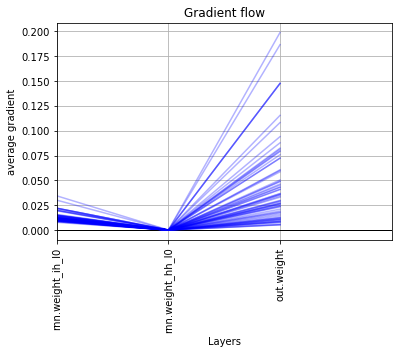

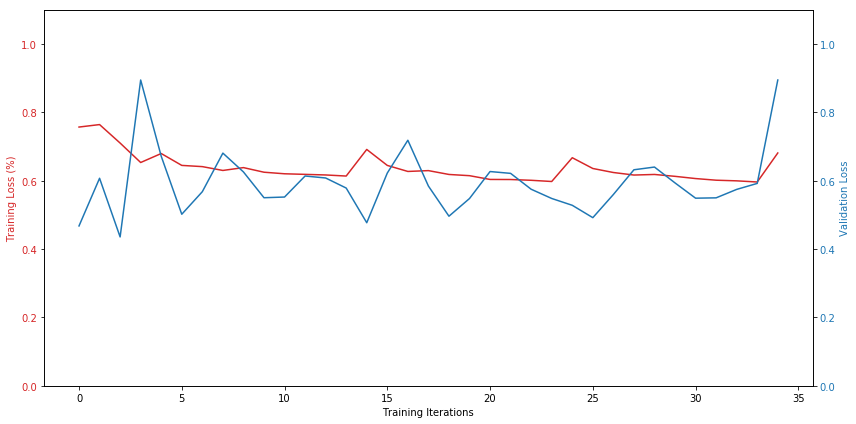

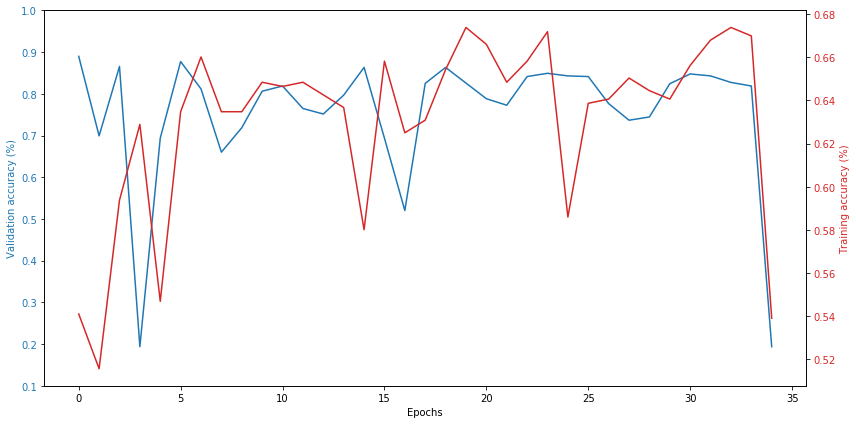

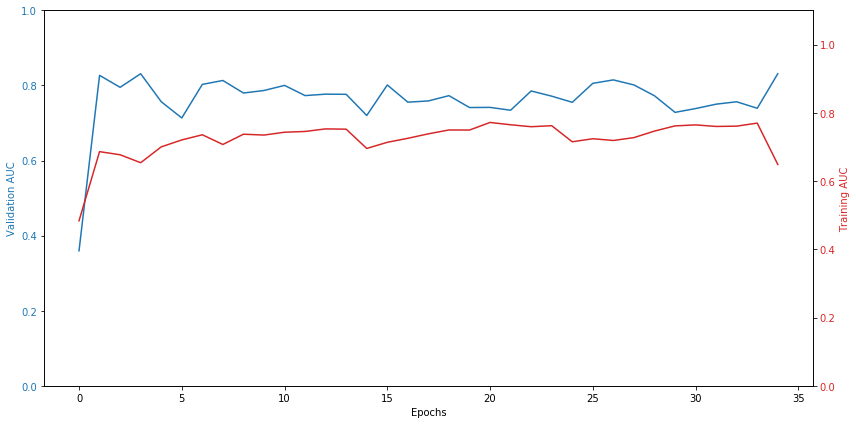

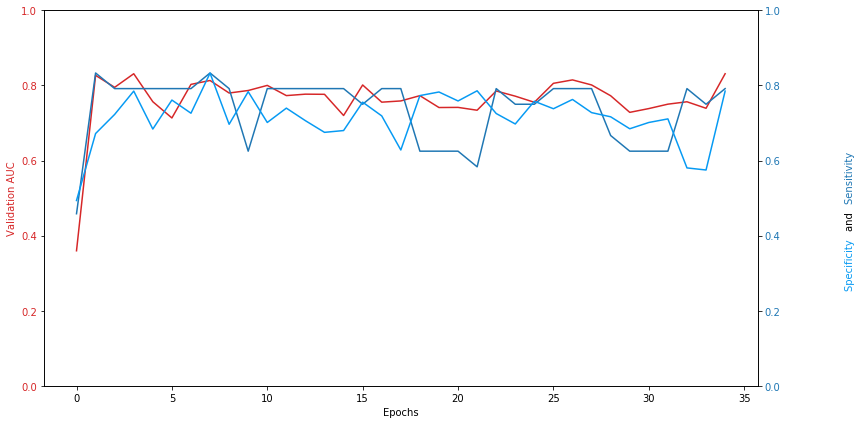


Fold  5
confused items in training set:  316
not_confused items in training set:  316
confused items in validation set:  24
not_confused items in validation set:  1260

Validation confused items:

['122a_V-SortTwoFactors-4-1.pkl', '122a_V-SortTwoFactors-4-2.pkl', '122a_V-SortTwoFactors-4-3.pkl', '122a_V-SortTwoFactors-4-4.pkl', '142a_V-CDV-15-1.pkl', '142a_V-CDV-15-2.pkl', '142a_V-CDV-15-3.pkl', '142a_V-CDV-15-4.pkl', '142b_H-CDV-22-1.pkl', '142b_H-CDV-22-2.pkl', '142b_H-CDV-22-3.pkl', '142b_H-CDV-22-4.pkl', '25a_H-RV-22-1.pkl', '25a_H-RV-22-2.pkl', '25a_H-RV-22-3.pkl', '25a_H-RV-22-4.pkl', '32a_V-SortTwoFactors-11-1.pkl', '32a_V-SortTwoFactors-11-2.pkl', '32a_V-SortTwoFactors-11-3.pkl', '32a_V-SortTwoFactors-11-4.pkl', '82a_V-SortTwoFactors-4-1.pkl', '82a_V-SortTwoFactors-4-2.pkl', '82a_V-SortTwoFactors-4-3.pkl', '82a_V-SortTwoFactors-4-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 632
    Root Location: ./dataset/augmented/train/
    Transforms (if any): N

Training accuracy for epoch:  0.705078125
validation accuracy:  0.7734375
validation loss:  0.6014354586601257
validation recall:  0.3333333333333333
validation specificity:  0.9307324840764332
validation AUC:  0.5291766188959661
Epochs without improvement:  7
[epoch: 21, batches:     2] loss: 0.57501 | accuracy: 0.68555
Training accuracy for epoch:  0.685546875
validation accuracy:  0.78125
validation loss:  0.5713405609130859
validation recall:  0.6666666666666666
validation specificity:  0.4434713375796178
validation AUC:  0.5669121549893843
Epochs without improvement:  8
[epoch: 22, batches:     2] loss: 0.57328 | accuracy: 0.69727
Training accuracy for epoch:  0.697265625
validation accuracy:  0.70703125
validation loss:  0.6026821136474609
validation recall:  0.3333333333333333
validation specificity:  0.9410828025477707
validation AUC:  0.5325437898089173
Epochs without improvement:  9
[epoch: 23, batches:     2] loss: 0.57244 | accuracy: 0.68750
Training accuracy for epoch:  0.

[epoch: 45, batches:     2] loss: 0.56232 | accuracy: 0.71484
Training accuracy for epoch:  0.71484375
validation accuracy:  0.8
validation loss:  0.579560649394989
validation recall:  0.3333333333333333
validation specificity:  0.927547770700637
validation AUC:  0.5311836518046709
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.00075
New learning rate: 0.000375
Validation AUC:  0.6455181794055201
Validation Loss:  0.5268154740333557
Epochs without improvement:  20
[epoch: 46, batches:     2] loss: 0.59311 | accuracy: 0.66602
Training accuracy for epoch:  0.666015625
validation accuracy:  0.74140625
validation loss:  0.6279652953147888
validation recall:  0.75
validation specificity:  0.4896496815286624
validation AUC:  0.590266719745223
Epochs without improvement:  21
[epoch: 47, batches:     2] loss: 0.58497 | accuracy: 0.69727
Training accuracy for epoch:  0.697265625
validation accuracy:  0.7796875
validation loss:  0.5969478607177734


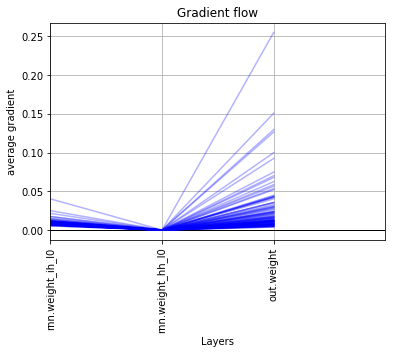

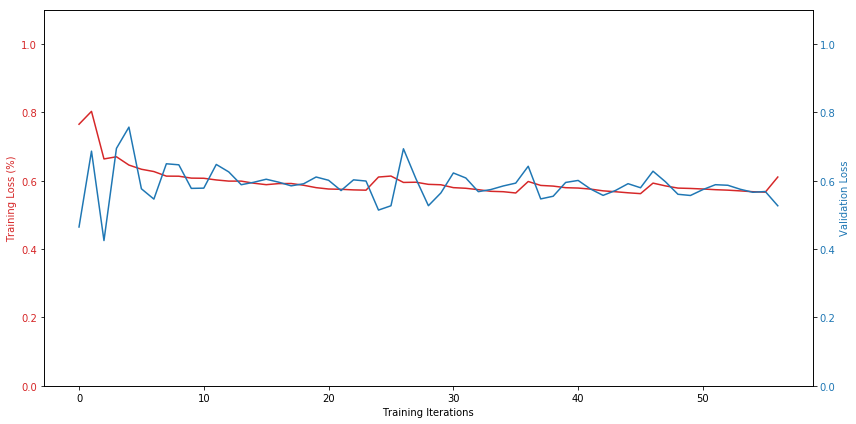

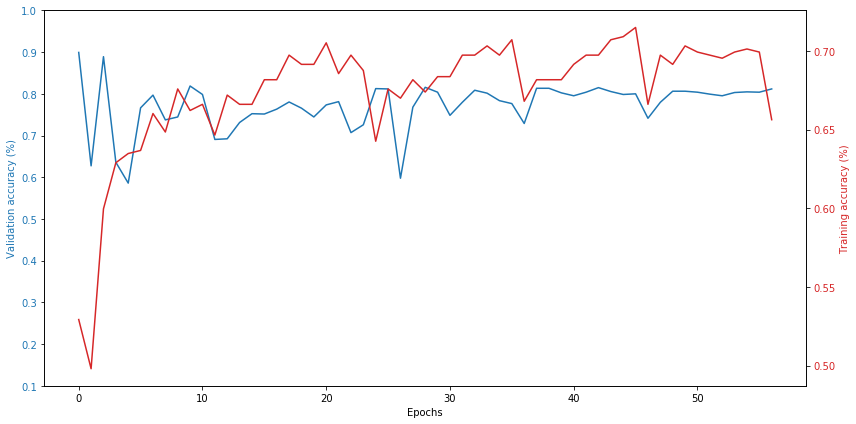

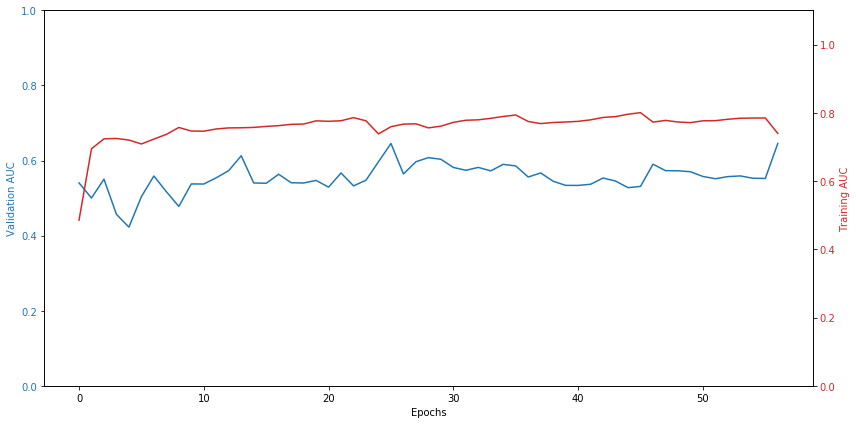

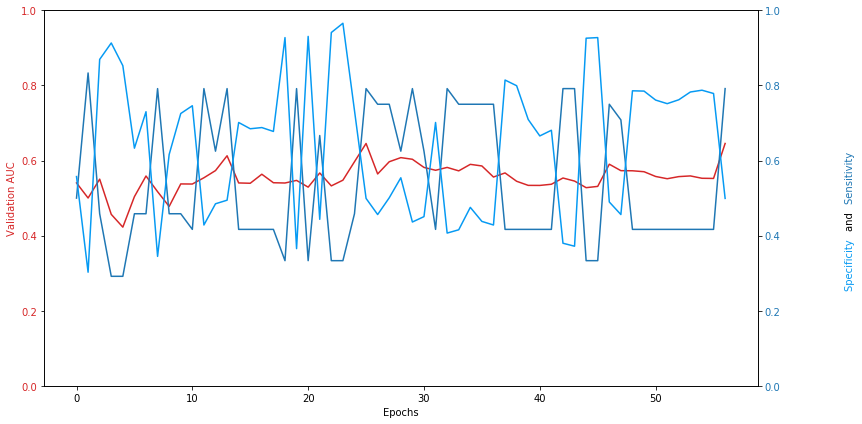


Fold  6
confused items in training set:  324
not_confused items in training set:  324
confused items in validation set:  16
not_confused items in validation set:  1272

Validation confused items:

['10a_V-CDV-2-1.pkl', '10a_V-CDV-2-2.pkl', '10a_V-CDV-2-3.pkl', '10a_V-CDV-2-4.pkl', '12b_H-CDV-5-1.pkl', '12b_H-CDV-5-2.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-4.pkl', '3a_H-SortTwoFactors-11-1.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '3a_H-SortTwoFactors-11-4.pkl', '9a_H-SortTwoFactors-12-1.pkl', '9a_H-SortTwoFactors-12-2.pkl', '9a_H-SortTwoFactors-12-3.pkl', '9a_H-SortTwoFactors-12-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 648
    Root Location: ./dataset/augmented/train/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 1288
    Root Location: ./dataset/augmented/val/
    Transforms (if any): None
    Target Transforms (if any): None
ConfusionRNN(

[epoch: 22, batches:     2] loss: 0.63702 | accuracy: 0.64258
Training accuracy for epoch:  0.642578125
validation accuracy:  0.80625
validation loss:  0.5213568687438965
validation recall:  0.75
validation specificity:  0.7468354430379747
validation AUC:  0.7895075158227849
Epochs without improvement:  12
[epoch: 23, batches:     2] loss: 0.62101 | accuracy: 0.64258
Training accuracy for epoch:  0.642578125
validation accuracy:  0.76796875
validation loss:  0.694082510471344
validation recall:  0.75
validation specificity:  0.8813291139240507
validation AUC:  0.8458761867088608
Old best AUC:  0.8397943037974684
New best SUC:  0.8458761867088608
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 24, batches:     2] loss: 0.62390 | accuracy: 0.64453
Training accuracy for epoch:  0.64453125
validation accuracy:  0.7265625
validation loss:  0.6700249075889587
validation recall:  0.75
validation specificity:  0.884493670886076
validation AUC:  0.797715585443038
Epochs

[epoch: 47, batches:     2] loss: 0.60276 | accuracy: 0.66211
Training accuracy for epoch:  0.662109375
validation accuracy:  0.77109375
validation loss:  0.6156893491744995
validation recall:  0.75
validation specificity:  0.7895569620253164
validation AUC:  0.8258010284810127
Epochs without improvement:  24
[epoch: 48, batches:     2] loss: 0.60050 | accuracy: 0.66992
Training accuracy for epoch:  0.669921875
validation accuracy:  0.74921875
validation loss:  0.6336983799934387
validation recall:  0.75
validation specificity:  0.8251582278481012
validation AUC:  0.824910996835443
Epochs without improvement:  25
[epoch: 49, batches:     2] loss: 0.59942 | accuracy: 0.66992
Training accuracy for epoch:  0.669921875
validation accuracy:  0.76171875
validation loss:  0.6236702919006347
validation recall:  0.75
validation specificity:  0.8322784810126582
validation AUC:  0.8206091772151898
Epochs without improvement:  26
[epoch: 50, batches:     2] loss: 0.59768 | accuracy: 0.67188
Traini

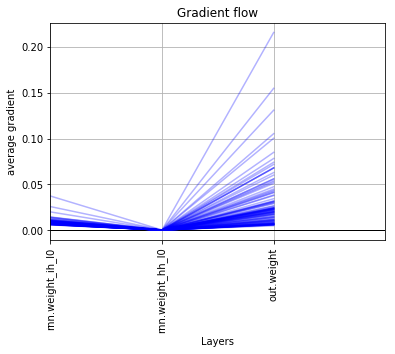

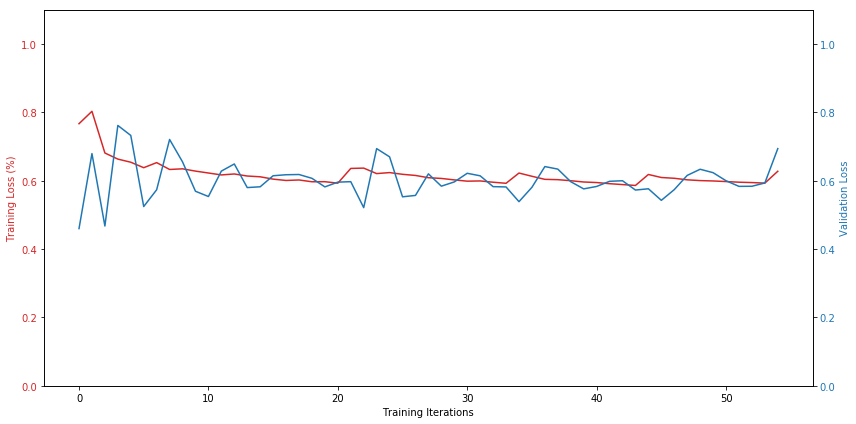

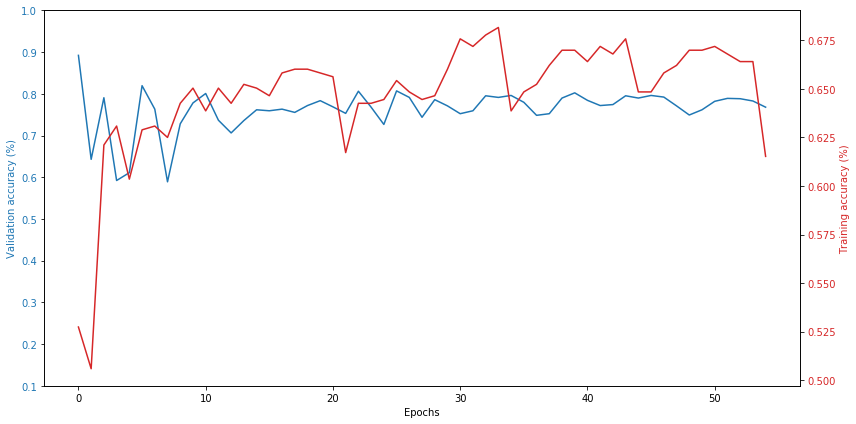

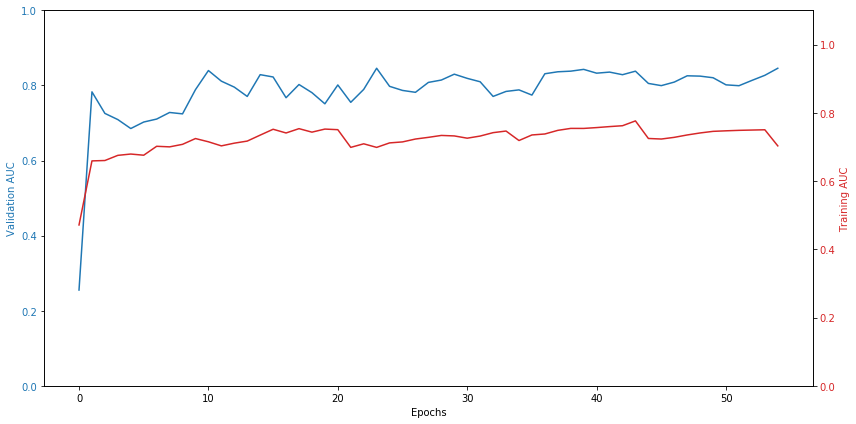

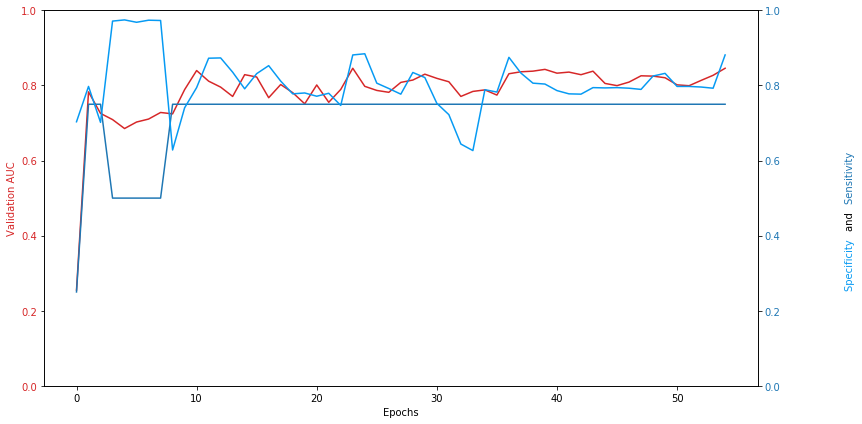


Fold  7
confused items in training set:  296
not_confused items in training set:  296
confused items in validation set:  44
not_confused items in validation set:  1240

Validation confused items:

['105a_H-FE-17-1.pkl', '105a_H-FE-17-2.pkl', '105a_H-FE-17-3.pkl', '105a_H-FE-17-4.pkl', '105a_H-RV-22-1.pkl', '105a_H-RV-22-2.pkl', '105a_H-RV-22-3.pkl', '105a_H-RV-22-4.pkl', '105a_H-RV-8-1.pkl', '105a_H-RV-8-2.pkl', '105a_H-RV-8-3.pkl', '105a_H-RV-8-4.pkl', '105b_V-FE-20-1.pkl', '105b_V-FE-20-2.pkl', '105b_V-FE-20-3.pkl', '105b_V-FE-20-4.pkl', '105b_V-FE-8-1.pkl', '105b_V-FE-8-2.pkl', '105b_V-FE-8-3.pkl', '105b_V-FE-8-4.pkl', '105b_V-RV-5-1.pkl', '105b_V-RV-5-2.pkl', '105b_V-RV-5-3.pkl', '105b_V-RV-5-4.pkl', '134b_H-CDV-15-1.pkl', '134b_H-CDV-15-2.pkl', '134b_H-CDV-15-3.pkl', '134b_H-CDV-15-4.pkl', '134b_H-CDV-4-1.pkl', '134b_H-CDV-4-2.pkl', '134b_H-CDV-4-3.pkl', '134b_H-CDV-4-4.pkl', '50a_V-SortTwoFactors-22-1.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '50a_V

[epoch: 19, batches:     2] loss: 0.58688 | accuracy: 0.65820
Training accuracy for epoch:  0.658203125
validation accuracy:  0.7296875
validation loss:  0.6590305924415588
validation recall:  0.75
validation specificity:  0.6747572815533981
validation AUC:  0.6834363047955282
Epochs without improvement:  2
[epoch: 20, batches:     2] loss: 0.58247 | accuracy: 0.66797
Training accuracy for epoch:  0.66796875
validation accuracy:  0.7421875
validation loss:  0.643231999874115
validation recall:  0.7045454545454546
validation specificity:  0.7168284789644013
validation AUC:  0.6918303177405117
Epochs without improvement:  3
[epoch: 21, batches:     2] loss: 0.58334 | accuracy: 0.65820
Training accuracy for epoch:  0.658203125
validation accuracy:  0.77734375
validation loss:  0.6190352201461792
validation recall:  0.7272727272727273
validation specificity:  0.7071197411003236
validation AUC:  0.6949930126507797
Epochs without improvement:  4
[epoch: 22, batches:     2] loss: 0.57775 | ac

[epoch: 44, batches:     2] loss: 0.56769 | accuracy: 0.68555
Training accuracy for epoch:  0.685546875
validation accuracy:  0.7890625
validation loss:  0.6376023173332215
validation recall:  0.7727272727272727
validation specificity:  0.6909385113268608
validation AUC:  0.6995164018829068
Epochs without improvement:  27
[epoch: 45, batches:     2] loss: 0.56613 | accuracy: 0.69141
Training accuracy for epoch:  0.69140625
validation accuracy:  0.78984375
validation loss:  0.6212260842323303
validation recall:  0.7954545454545454
validation specificity:  0.6561488673139159
validation AUC:  0.6975581053250957
Epochs without improvement:  28
[epoch: 46, batches:     2] loss: 0.56350 | accuracy: 0.67969
Training accuracy for epoch:  0.6796875
validation accuracy:  0.8125
validation loss:  0.5967500805854797
validation recall:  0.8181818181818182
validation specificity:  0.610032362459547
validation AUC:  0.696261768167108
Epochs without improvement:  29
[epoch: 47, batches:     2] loss: 0

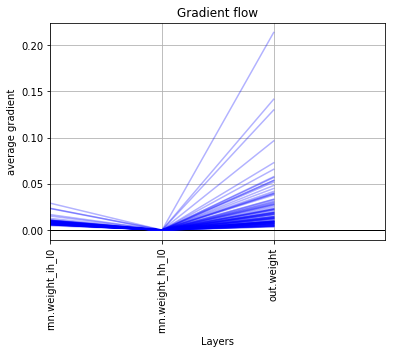

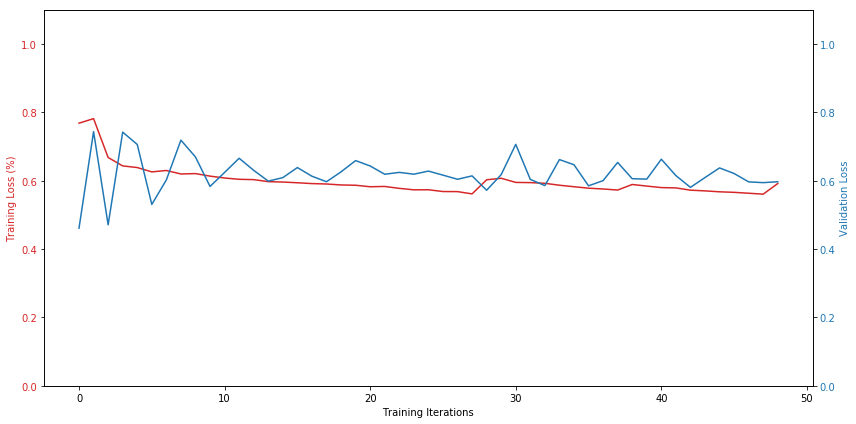

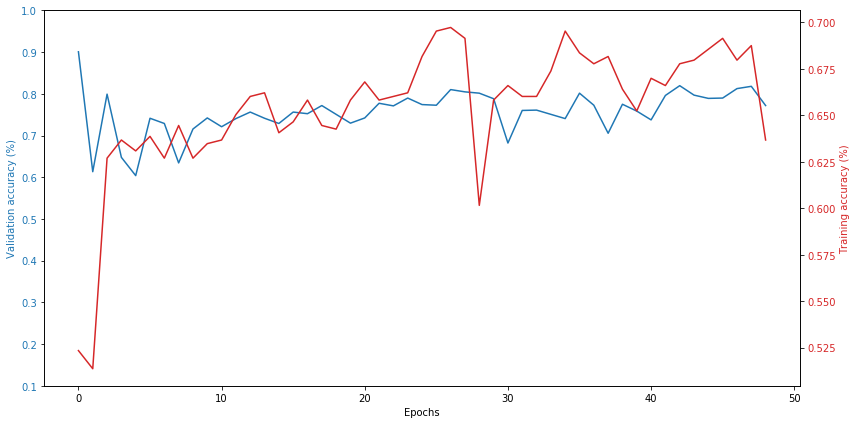

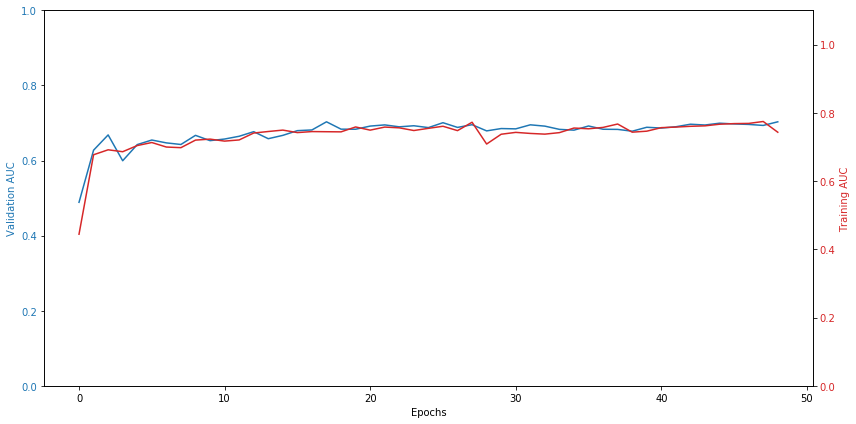

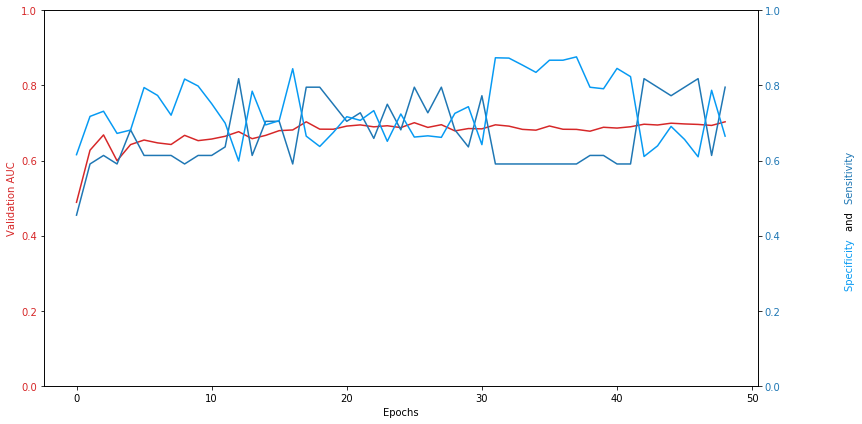


Fold  8
confused items in training set:  304
not_confused items in training set:  304
confused items in validation set:  36
not_confused items in validation set:  1248

Validation confused items:

['121a_H-CDV-9-1.pkl', '121a_H-CDV-9-2.pkl', '121a_H-CDV-9-3.pkl', '121a_H-CDV-9-4.pkl', '121a_H-SortTwoFactors-20-1.pkl', '121a_H-SortTwoFactors-20-2.pkl', '121a_H-SortTwoFactors-20-3.pkl', '121a_H-SortTwoFactors-20-4.pkl', '121b_V-FE-2-1.pkl', '121b_V-FE-2-2.pkl', '121b_V-FE-2-3.pkl', '121b_V-FE-2-4.pkl', '121b_V-SortTwoFactors-11-1.pkl', '121b_V-SortTwoFactors-11-2.pkl', '121b_V-SortTwoFactors-11-3.pkl', '121b_V-SortTwoFactors-11-4.pkl', '129b_V-SortTwoFactors-23-1.pkl', '129b_V-SortTwoFactors-23-2.pkl', '129b_V-SortTwoFactors-23-3.pkl', '129b_V-SortTwoFactors-23-4.pkl', '141a_H-RV-18-1.pkl', '141a_H-RV-18-2.pkl', '141a_H-RV-18-3.pkl', '141a_H-RV-18-4.pkl', '141a_H-SortTwoFactors-22-1.pkl', '141a_H-SortTwoFactors-22-2.pkl', '141a_H-SortTwoFactors-22-3.pkl', '141a_H-SortTwoFactors-22-4.pkl

[epoch: 20, batches:     2] loss: 0.57120 | accuracy: 0.68945
Training accuracy for epoch:  0.689453125
validation accuracy:  0.7921875
validation loss:  0.6149924159049988
validation recall:  0.5
validation specificity:  0.6728295819935691
validation AUC:  0.5723807609860665
Epochs without improvement:  18
[epoch: 21, batches:     2] loss: 0.56995 | accuracy: 0.68945
Training accuracy for epoch:  0.689453125
validation accuracy:  0.7890625
validation loss:  0.6139651775360108
validation recall:  0.3888888888888889
validation specificity:  0.8046623794212219
validation AUC:  0.5620645766345124
Epochs without improvement:  19
[epoch: 22, batches:     2] loss: 0.56578 | accuracy: 0.69141
Training accuracy for epoch:  0.69140625
validation accuracy:  0.8015625
validation loss:  0.5915749192237854
validation recall:  0.3888888888888889
validation specificity:  0.7741157556270096
validation AUC:  0.5494819578420864
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Ol

[epoch: 44, batches:     2] loss: 0.55193 | accuracy: 0.69336
Training accuracy for epoch:  0.693359375
validation accuracy:  0.8
validation loss:  0.6073138236999511
validation recall:  0.6388888888888888
validation specificity:  0.657556270096463
validation AUC:  0.6421936405859235
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.000375
New learning rate: 0.0001875
Validation AUC:  0.7194980350125044
Validation Loss:  0.5633684992790222
Epochs without improvement:  10
[epoch: 45, batches:     2] loss: 0.58125 | accuracy: 0.68359
Training accuracy for epoch:  0.68359375
validation accuracy:  0.75859375
validation loss:  0.6224369406700134
validation recall:  0.6944444444444444
validation specificity:  0.6736334405144695
validation AUC:  0.6788138620936048
Epochs without improvement:  11
[epoch: 46, batches:     2] loss: 0.57472 | accuracy: 0.68555
Training accuracy for epoch:  0.685546875
validation accuracy:  0.7625
validation loss:  0.61

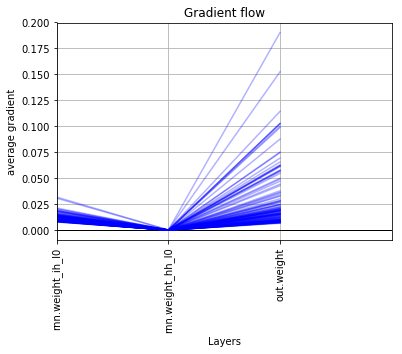

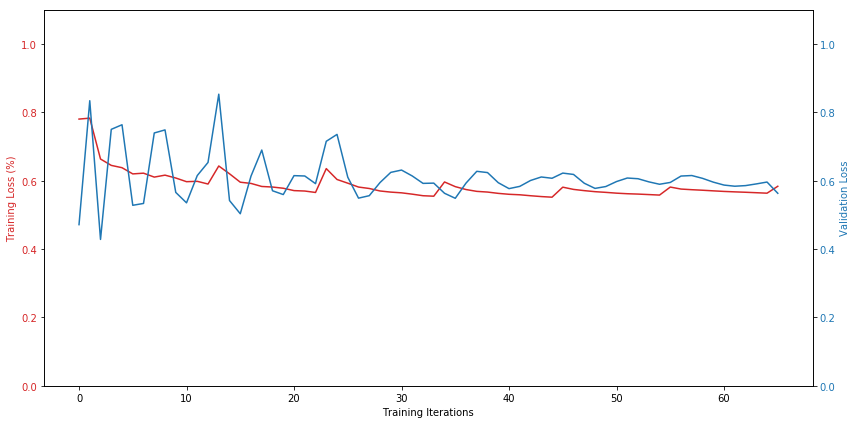

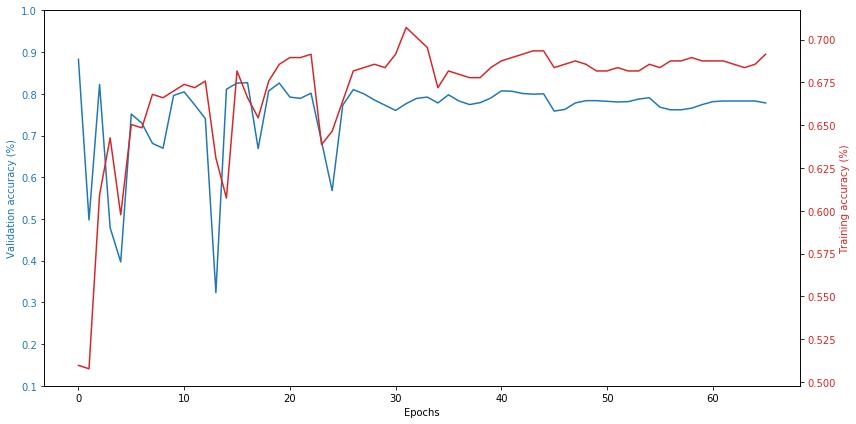

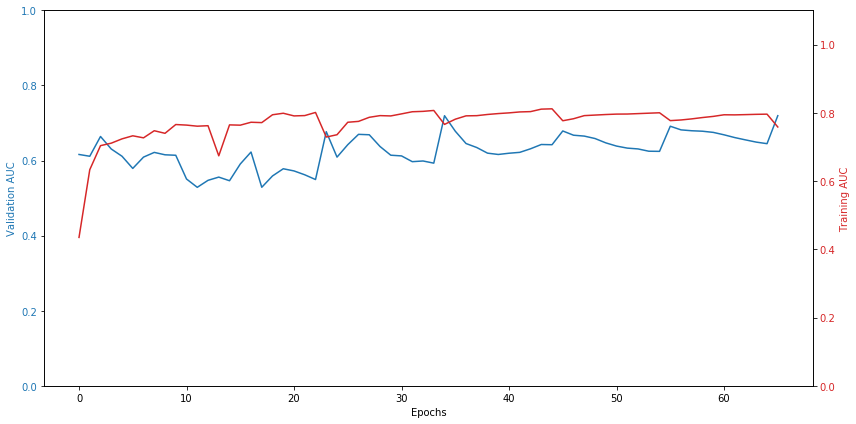

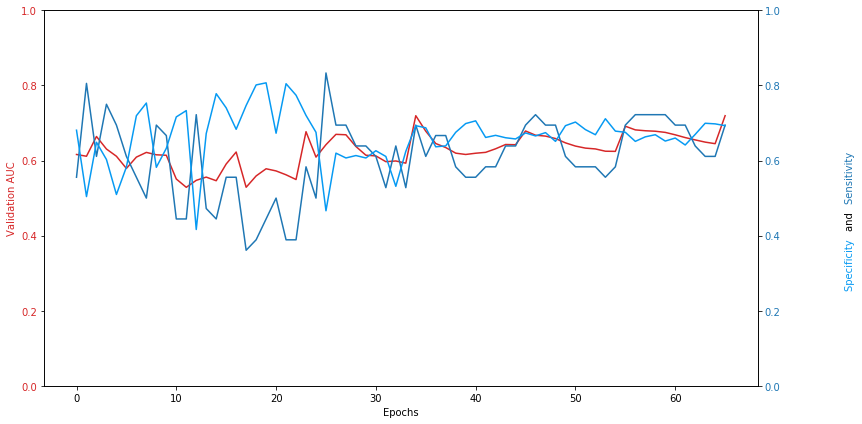


Fold  9
confused items in training set:  324
not_confused items in training set:  324
confused items in validation set:  16
not_confused items in validation set:  1268

Validation confused items:

['103a_H-CDV-12-1.pkl', '103a_H-CDV-12-2.pkl', '103a_H-CDV-12-3.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-4.pkl', '11a_H-SortTwoFactors-5-1.pkl', '11a_H-SortTwoFactors-5-2.pkl', '11a_H-SortTwoFactors-5-3.pkl', '11a_H-SortTwoFactors-5-4.pkl', '143a_H-CDV-17-1.pkl', '143a_H-CDV-17-2.pkl', '143a_H-CDV-17-3.pkl', '143a_H-CDV-17-4.pkl']

Training data:  Dataset DatasetFolder
    Number of datapoints: 648
    Root Location: ./dataset/augmented/train/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 1284
    Root Location: ./dataset/augmented/val/
    Transforms (if any): None
    Target Transforms (if any): None
ConfusionRNN(
  (rnn): RNN(14, 25

[epoch: 22, batches:     2] loss: 0.59208 | accuracy: 0.65820
Training accuracy for epoch:  0.658203125
validation accuracy:  0.8328125
validation loss:  0.6053940296173096
validation recall:  0.4375
validation specificity:  0.9430379746835443
validation AUC:  0.4962915348101266
Epochs without improvement:  1
[epoch: 23, batches:     2] loss: 0.59102 | accuracy: 0.65430
Training accuracy for epoch:  0.654296875
validation accuracy:  0.84140625
validation loss:  0.5702082991600037
validation recall:  0.4375
validation specificity:  0.946993670886076
validation AUC:  0.5039556962025317
Old best AUC:  0.4972804588607595
New best SUC:  0.5039556962025317
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 24, batches:     2] loss: 0.58542 | accuracy: 0.66602
Training accuracy for epoch:  0.666015625
validation accuracy:  0.83828125
validation loss:  0.5917252898216248
validation recall:  0.4375
validation specificity:  0.9359177215189873
validation AUC:  0.496835443037

[epoch: 46, batches:     2] loss: 0.53088 | accuracy: 0.73828
Training accuracy for epoch:  0.73828125
validation accuracy:  0.75234375
validation loss:  0.5734024584293366
validation recall:  0.4375
validation specificity:  0.9375
validation AUC:  0.5102848101265823
Epochs without improvement:  3
[epoch: 47, batches:     2] loss: 0.54202 | accuracy: 0.70898
Training accuracy for epoch:  0.708984375
validation accuracy:  0.63203125
validation loss:  0.6198378324508667
validation recall:  0.4375
validation specificity:  0.944620253164557
validation AUC:  0.5194323575949367
Epochs without improvement:  4
[epoch: 48, batches:     2] loss: 0.54639 | accuracy: 0.69531
Training accuracy for epoch:  0.6953125
validation accuracy:  0.76171875
validation loss:  0.5740752816200256
validation recall:  0.4375
validation specificity:  0.9493670886075949
validation AUC:  0.5243769778481012
Epochs without improvement:  5
[epoch: 49, batches:     2] loss: 0.55201 | accuracy: 0.71875
Training accuracy 

[epoch: 71, batches:     2] loss: 0.51879 | accuracy: 0.74609
Training accuracy for epoch:  0.74609375
validation accuracy:  0.83828125
validation loss:  0.5349793314933777
validation recall:  0.5
validation specificity:  0.7966772151898734
validation AUC:  0.6000791139240507
Epochs without improvement:  5
[epoch: 72, batches:     2] loss: 0.51543 | accuracy: 0.74219
Training accuracy for epoch:  0.7421875
validation accuracy:  0.83515625
validation loss:  0.5442377507686615
validation recall:  0.5
validation specificity:  0.8322784810126582
validation AUC:  0.5972606803797469
Epochs without improvement:  6
[epoch: 73, batches:     2] loss: 0.51093 | accuracy: 0.73828
Training accuracy for epoch:  0.73828125
validation accuracy:  0.8328125
validation loss:  0.557909083366394
validation recall:  0.5
validation specificity:  0.8362341772151899
validation AUC:  0.5881131329113924
Epochs without improvement:  7
[epoch: 74, batches:     2] loss: 0.51026 | accuracy: 0.73633
Training accuracy

validation accuracy:  0.83984375
validation loss:  0.5468329548835754
validation recall:  0.5
validation specificity:  0.8401898734177216
validation AUC:  0.6182258702531646


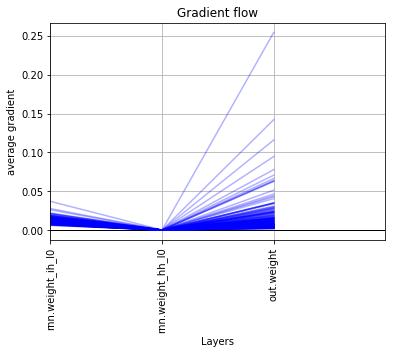

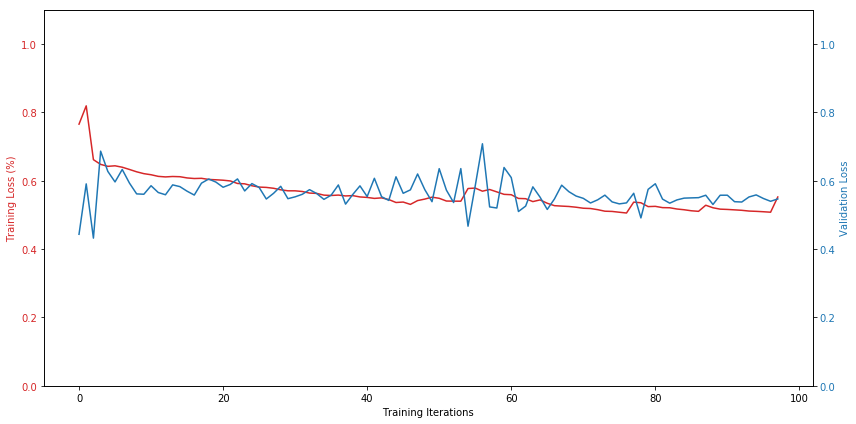

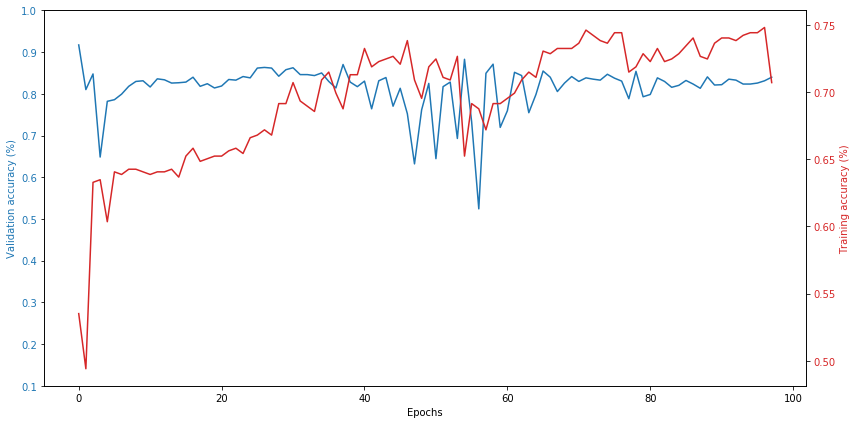

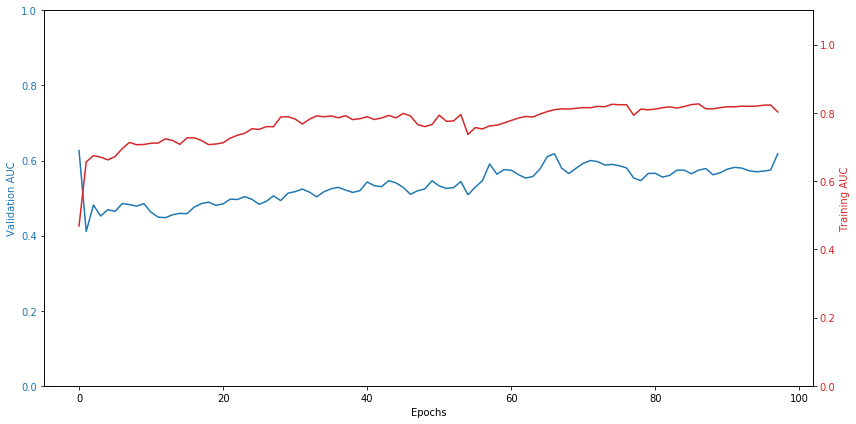

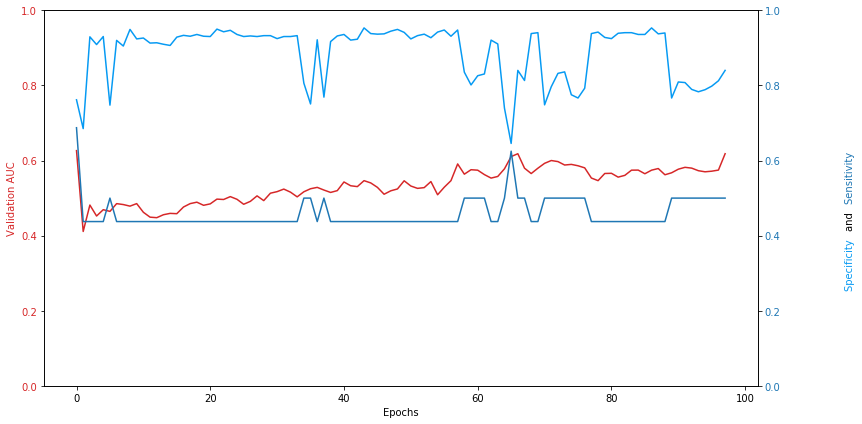


Fold  10
confused items in training set:  288
not_confused items in training set:  288
confused items in validation set:  52
not_confused items in validation set:  1228

Validation confused items:

['112a_V-SortTwoFactors-5-1.pkl', '112a_V-SortTwoFactors-5-2.pkl', '112a_V-SortTwoFactors-5-3.pkl', '112a_V-SortTwoFactors-5-4.pkl', '114a_V-SortTwoFactors-12-1.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '114a_V-SortTwoFactors-12-4.pkl', '130a_V-RV-10-1.pkl', '130a_V-RV-10-2.pkl', '130a_V-RV-10-3.pkl', '130a_V-RV-10-4.pkl', '35a_H-SortTwoFactors-15-1.pkl', '35a_H-SortTwoFactors-15-2.pkl', '35a_H-SortTwoFactors-15-3.pkl', '35a_H-SortTwoFactors-15-4.pkl', '35a_H-SortTwoFactors-22-1.pkl', '35a_H-SortTwoFactors-22-2.pkl', '35a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-22-4.pkl', '35a_H-SortTwoFactors-4-1.pkl', '35a_H-SortTwoFactors-4-2.pkl', '35a_H-SortTwoFactors-4-3.pkl', '35a_H-SortTwoFactors-4-4.pkl', '39a_H-SortTwoFactors-10-1.pkl', '39a_H-SortTwoFacto

Training accuracy for epoch:  0.626953125
validation accuracy:  0.82890625
validation loss:  0.5712299823760987
validation recall:  0.7884615384615384
validation specificity:  0.8420195439739414
validation AUC:  0.8457936607366574
Epochs without improvement:  13
[epoch: 18, batches:     2] loss: 0.62969 | accuracy: 0.63867
Training accuracy for epoch:  0.638671875
validation accuracy:  0.85234375
validation loss:  0.5087109804153442
validation recall:  0.7692307692307693
validation specificity:  0.8493485342019544
validation AUC:  0.8215907667251315
Epochs without improvement:  14
[epoch: 19, batches:     2] loss: 0.62035 | accuracy: 0.64453
Training accuracy for epoch:  0.64453125
validation accuracy:  0.7015625
validation loss:  0.6054383277893066
validation recall:  0.8461538461538461
validation specificity:  0.8216612377850163
validation AUC:  0.8744910423452769
Epochs without improvement:  15
[epoch: 20, batches:     2] loss: 0.61280 | accuracy: 0.65625
Training accuracy for epoch

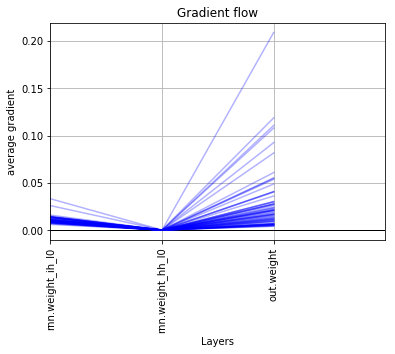

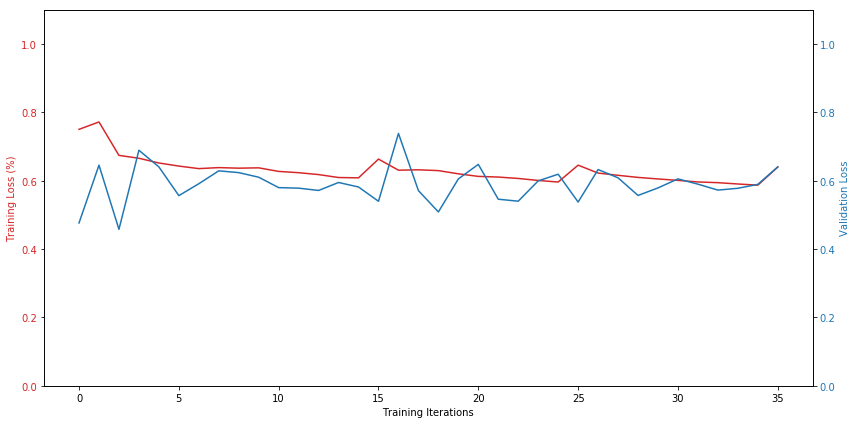

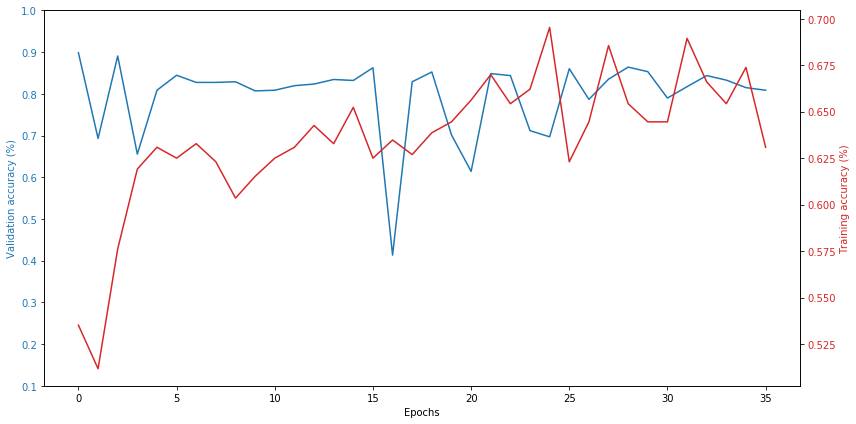

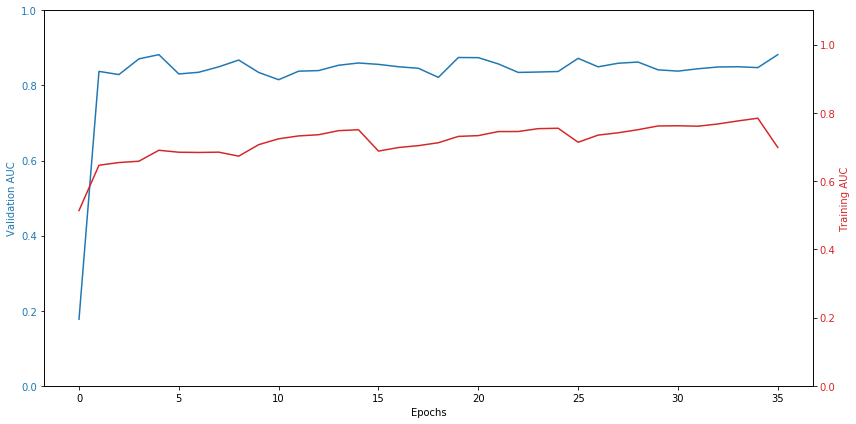

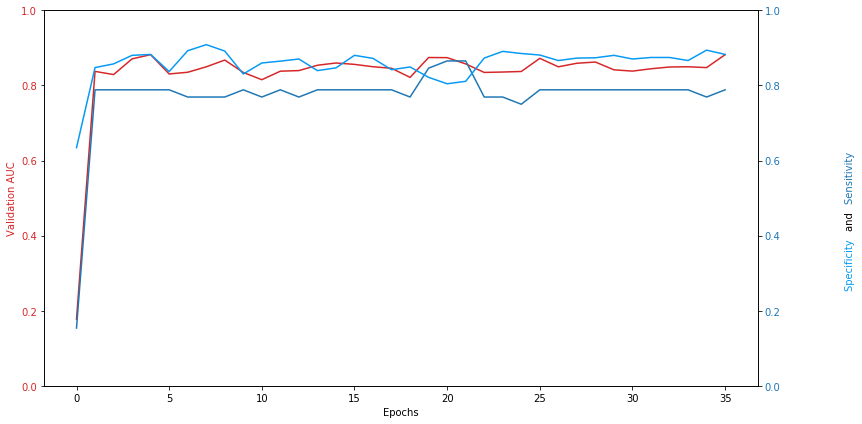


10-fold CV accuracy: 0.710547
10-fold CV sensitivity: 0.726527 
10-fold CV specificity: 0.723349 
10-fold CV AUC: 0.724982 


([0.80234375,
  0.52421875,
  0.80703125,
  0.19375,
  0.81171875,
  0.76796875,
  0.771875,
  0.778125,
  0.83984375,
  0.80859375],
 [0.8035714285714286,
  0.875,
  0.475,
  0.7916666666666666,
  0.7916666666666666,
  0.75,
  0.7954545454545454,
  0.6944444444444444,
  0.5,
  0.7884615384615384],
 [0.5277777777777778,
  0.5665064102564102,
  0.8927419354838709,
  0.785031847133758,
  0.49920382165605093,
  0.8813291139240507,
  0.6650485436893204,
  0.6929260450160771,
  0.8401898734177216,
  0.8827361563517915],
 [0.665047268907563,
  0.7146434294871795,
  0.6243951612903226,
  0.8312765392781316,
  0.6455181794055201,
  0.8458761867088608,
  0.7032307296263607,
  0.7194980350125044,
  0.6182258702531646,
  0.8821097469305939])

In [10]:
np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

cross_validate(model_type='rnn',
                   folds=10,
                   epochs=300,
                   criterion_type='NLLLoss',
                   optimizer_type='Adam',
                   confused_path='./dataset/augmented/confused_highly_valid/',
                   not_confused_path='./dataset/augmented/not_confused_highly_valid/',
                   print_every=2,
                   plot_every=2,
                   hidden_size=256,
                   num_layers=1,
                   early_stopping=True,
                   early_stopping_patience=30,
                   rate_decay=True,
                   rate_decay_patience=10,
                   initial_learning_rate=0.003,
                   verbose=True)